# Citation

Please cite this notebook as follows.

Lagerquist, R., 2019: "Deep learning for prediction of synoptic-scale atmospheric fronts: Keras tutorial". https://github.com/thunderhoser/aiml_symposium/blob/2019_branch/aiml_symposium/aiml_symposium.ipynb.

This notebook was used for the deep-learning tutorial at the University of Oklahoma's [2019 Artificial Intelligence and Machine Learning Symposium](http://www.ou.edu/coe/ai-ml).  Related journal articles are listed below.

Lagerquist, R., A. McGovern, and D.J. Gagne, 2019: "Deep learning for spatially explicit prediction of synoptic-scale fronts." *Weather and Forecasting*, **34 (4)**, 1137-1160.

Lagerquist, R., J.T. Allen, and A. McGovern, 2019: "Climatology and variability of warm and cold fronts over North America from 1979-2018." *Journal of Climate*, **under review**.

# Setup

To use this notebook, you will need Python 3 and the following packages:

 - TensorFlow
 - Keras
 - [GewitterGefahr](https://github.com/thunderhoser/GewitterGefahr)
 - [GeneralExam](https://github.com/thunderhoser/GeneralExam) (make sure to use the branch called `era5_branch`, not `master`)

Instructions for installing TensorFlow and Keras can be found [here](https://keras.io/#installation).  On most systems it should suffice to install them with the Anaconda command `pip` in a Unix terminal, as follows:

`pip install tensorflow` <br />
`pip install keras`

To install GewitterGefahr, open a Unix terminal and enter the following commands (where `PACKAGE_DIR_NAME` is the name of top-level directory in which you want both packages; the `git clone` command will create subdirectories therein, called `gewittergefahr` and `generalexam`).

`git clone https://github.com/thunderhoser/GewitterGefahr` <br />
`cd gewittergefahr` <br />
`python setup.py install` <br />
`git clone https://github.com/thunderhoser/GeneralExam` <br />
`cd generalexam` <br />
`git checkout era5_branch` <br />
`python setup.py install`

# Background

The repository [contains a PDF](https://github.com/thunderhoser/aiml_symposium/blob/master/aiml_symposium/aiml_symposium.pdf) with background info on the problem domain (identifying warm and cold fronts) and method (CNNs).  Some background info is provided in this notebook as well.

This notebook uses deep learning to identify warm and cold fronts in weather grids.  The predictors are spatial grids (images) of wind velocity ($u$ is the eastward component; $v$ is the northward component), temperature, specific humidity, geopotential height, and wet-bulb potential temperature.  These grids come from the North American Regional Reanalysis (NARR) and have 32-km resolution -- in other words, each grid cell is 32 $\times$ 32 km.  Verification data (or "labels" or "ground truth" or "target values") come from Weather Prediction Center (WPC) surface bulletins, which contain warm and cold fronts drawn by human meteorologists.  Both the NARR and WPC data are created every 3 hours (at 0000, 0300, ..., 2100 UTC every day).

The data used in this notebook have undergone a lot of pre-processing (done by the GeneralExam library).  There should soon be a paper in *Weather and Forecasting* on this project, discussing the pre-processing and many other aspects.  When the paper has been accepted we will post a link here.

Our chosen deep-learning model is convolutional neural nets (CNN).  Each input to the CNN is called an "example".  Each example consists of one or more predictor variables, each defined over the same spatial grid, and the target value.  The target value is the label at the center grid cell (the grid dimensions are always odd -- *e.g.*, $65 \times 65$ -- so that there is one grid cell exactly at the center).  This label is 0 if the center grid cell is **not** intersected by a front, 1 if intersected by a warm front, 2 if intersected by a cold front.  Thus, the problem is 3-class classification.  The following notation will be used throughout this notebook, especially in the code.

 - $E$ = number of examples
 - $M$ = number of rows (latitudes) in each grid
 - $N$ = number of columns (longitudes) in each grid
 - $C$ = number of channels (predictor variables) for each example
 - $K$ = number of target classes = 3 (no front, warm front, and cold front)

# Data

Before running this notebook, you must perform the following steps.

1. Download the following `.tar` files:

 - [Training data](https://drive.google.com/open?id=1iZSHyZhBECyXn2PrmGsZRWLKPYrlfI6g)
 - [Validation data](https://drive.google.com/open?id=12mKjHtb9ngB2iliPHiF_8BnEY440rd_e)
 - [Testing data](https://drive.google.com/open?id=1B0I3QG6tymv5mqNAXZZ5gxBnMJklI70C)
 - [Pre-trained CNN](https://drive.google.com/open?id=1wr8M5Kfp1irCkQL6FoF5XhDAXjn4r8YS)

2. Extract all `.tar` files to the same directory (call it `TOP_INPUT_DIR_NAME`).
3. Ensure that `TOP_INPUT_DIR_NAME` contains the following subdirectories:

 - `training`
 - `validation`
 - `testing`
 - `pretrained_model`

4. Change `TOP_INPUT_DIR_NAME` in the code (a few cells below, titled "Constants").

# Imports

The following cell imports all third-party code that will be used in this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
"""Code for 2019 AI/ML symposium at University of Oklahoma.

AI/ML = artificial intelligence and machine learning

--- NOTATION ---

The following letters will be used throughout this notebook.

E = number of examples
M = number of spatial rows (latitudes) in grid
N = number of spatial columns (longitudes) in grid
C = number of channels (predictor variables)
K = number of target classes = 3 (no front, warm front, and cold front)
"""

%matplotlib inline
import copy
import glob
import random
import os.path
import collections
import numpy
import netCDF4
import keras.layers
import keras.backend as K
import keras.callbacks
import matplotlib.colors
import matplotlib.pyplot as pyplot
from gewittergefahr.gg_utils import time_conversion
from gewittergefahr.gg_utils import model_evaluation as binary_eval
from gewittergefahr.gg_utils import file_system_utils
from gewittergefahr.gg_utils import error_checking
from generalexam.machine_learning import keras_metrics
from generalexam.machine_learning import cnn
from generalexam.machine_learning import evaluation_utils as eval_utils

print('Keras version = {0:s}'.format(str(keras.__version__)))

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan.lagerquis

Keras version = 2.2.4


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GeneralExam-0.1-py3.6.egg/generalexam/machine_learning/evaluation_utils.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Constants

The following cell defines all the constants used in this notebook.  You must change `TOP_INPUT_DIR_NAME` and `OUTPUT_DIR_NAME`.

In [3]:
# Input and output directories.
TOP_INPUT_DIR_NAME = '/localdata/ryan.lagerquist/aiml_symposium/data'
OUTPUT_DIR_NAME = '/localdata/ryan.lagerquist/aiml_symposium/output'
file_system_utils.mkdir_recursive_if_necessary(directory_name=OUTPUT_DIR_NAME)

TOP_TRAINING_DIR_NAME = '{0:s}/training'.format(TOP_INPUT_DIR_NAME)
TOP_VALIDATION_DIR_NAME = '{0:s}/validation'.format(TOP_INPUT_DIR_NAME)
TOP_TESTING_DIR_NAME = '{0:s}/testing'.format(TOP_INPUT_DIR_NAME)
BEST_MODEL_FILE_NAME = '{0:s}/pretrained_model/model.h5'.format(
    TOP_INPUT_DIR_NAME)

# These constants help to find input data.
TIME_FORMAT = '%Y%m%d%H'
TIME_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9][0-2][0-9]'
BATCH_NUMBER_REGEX = '[0-9][0-9][0-9][0-9][0-9][0-9][0-9]'
NUM_BATCHES_PER_DIRECTORY = 1000

# Target values.
NO_FRONT_ENUM = 0
WARM_FRONT_ENUM = 1
COLD_FRONT_ENUM = 2

# Valid pooling types.
MAX_POOLING_TYPE_STRING = 'max'
MEAN_POOLING_TYPE_STRING = 'avg'
VALID_POOLING_TYPE_STRINGS = [MAX_POOLING_TYPE_STRING, MEAN_POOLING_TYPE_STRING]

# Valid activation functions.
SIGMOID_FUNCTION_NAME = 'sigmoid'
TANH_FUNCTION_NAME = 'tanh'
RELU_FUNCTION_NAME = 'relu'
SELU_FUNCTION_NAME = 'selu'
ELU_FUNCTION_NAME = 'elu'
LEAKY_RELU_FUNCTION_NAME = 'leaky_relu'
VALID_ACTIVATION_FUNCTION_NAMES = [
    SIGMOID_FUNCTION_NAME, TANH_FUNCTION_NAME, RELU_FUNCTION_NAME,
    SELU_FUNCTION_NAME, ELU_FUNCTION_NAME, LEAKY_RELU_FUNCTION_NAME
]

# Predictor variables.
TEMPERATURE_NAME = 'temperature_kelvins'
HEIGHT_NAME = 'height_m_asl'
SPECIFIC_HUMIDITY_NAME = 'specific_humidity_kg_kg01'
WET_BULB_THETA_NAME = 'wet_bulb_potential_temperature_kelvins'
U_WIND_GRID_RELATIVE_NAME = 'u_wind_grid_relative_m_s01'
V_WIND_GRID_RELATIVE_NAME = 'v_wind_grid_relative_m_s01'

VALID_PREDICTOR_NAMES = [
    TEMPERATURE_NAME, HEIGHT_NAME, SPECIFIC_HUMIDITY_NAME, WET_BULB_THETA_NAME,
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME
]

DUMMY_SURFACE_PRESSURE_MB = 1013

# Dictionary keys.
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_MATRIX_KEY = 'target_matrix'
VALID_TIMES_KEY = 'target_times_unix_sec'
ROW_INDICES_KEY = 'row_indices'
COLUMN_INDICES_KEY = 'column_indices'
NORMALIZATION_TYPE_KEY = 'normalization_type_string'
PREDICTOR_NAMES_KEY = 'narr_predictor_names'
PRESSURE_LEVELS_KEY = 'pressure_levels_mb'
DILATION_DISTANCE_KEY = 'dilation_distance_metres'
MASK_MATRIX_KEY = 'narr_mask_matrix'

FIRST_NORM_PARAM_KEY = 'first_normalization_param_matrix'
SECOND_NORM_PARAM_KEY = 'second_normalization_param_matrix'

# Constants for plotting.
WIND_COLOUR_MAP_OBJECT = pyplot.get_cmap('binary')
FEATURE_COLOUR_MAP_OBJECT = pyplot.get_cmap('seismic')

FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15

FONT_SIZE = 30
pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

LEVELS_FOR_CSI_CONTOURS = numpy.array([
    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
])
LEVELS_FOR_BIAS_CONTOURS = numpy.array([0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5])

# Convolutional kernels.
EDGE_DETECTOR_MATRIX1 = numpy.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
], dtype=float)

EDGE_DETECTOR_MATRIX2 = numpy.array([
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
], dtype=float)

EDGE_DETECTOR_MATRIX3 = numpy.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
], dtype=float)

# These metrics will be reported during training of a CNN (convolutional neural
# network).
LIST_OF_METRIC_FUNCTIONS = [
    keras_metrics.accuracy, keras_metrics.binary_pod,
    keras_metrics.binary_pofd, keras_metrics.binary_peirce_score,
    keras_metrics.binary_csi, keras_metrics.binary_frequency_bias,
    keras_metrics.binary_success_ratio
]

# Helper Methods

The following cell defines "helper methods" used throughout this notebook.  All the methods are defined as private (with an underscore at the beginning of the name).  Since this is a notebook and not a real Python package, there is no distinction between public and private methods.  However, if I define a method as private (*e.g.*, `_check_predictor_name` rather than `check_predictor_name`), it means that I am trying to draw your attention away from it, because either (a) it performs a very low-level task like error-checking or (b) it performs a very complicated task that is outside the scope of this notebook, which is to learn about deep learning.

In [4]:
def _check_predictor_name(predictor_name):
    """Error-checks name of predictor variable.

    :param predictor_name: Name of predictor variable.
    :raises: ValueError: if name is unrecognized.
    """

    error_checking.assert_is_string(predictor_name)

    if predictor_name not in VALID_PREDICTOR_NAMES:
        error_string = (
            '\n{0:s}\nValid predictor names (listed above) do not include '
            '"{1:s}".'
        ).format(str(VALID_PREDICTOR_NAMES), predictor_name)

        raise ValueError(error_string)


def _check_pooling_type(pooling_type_string):
    """Error-checks pooling type.

    :param pooling_type_string: Pooling type ("max" or "avg").
    :raises: ValueError: if pooling type is unrecognized.
    """

    error_checking.assert_is_string(pooling_type_string)

    if pooling_type_string not in VALID_POOLING_TYPE_STRINGS:
        error_string = (
            '\n{0:s}\nValid pooling types (listed above) do not include '
            '"{1:s}".'
        ).format(str(VALID_POOLING_TYPE_STRINGS), pooling_type_string)

        raise ValueError(error_string)


def _check_activation_function(function_name):
    """Error-checks activation function.

    :param function_name: Name of activation function.
    :raises: ValueError: if activation function is unrecognized.
    """

    error_checking.assert_is_string(function_name)

    if function_name not in VALID_ACTIVATION_FUNCTION_NAMES:
        error_string = (
            '\n{0:s}\nValid activation functions (listed above) do not '
            'include "{1:s}".'
        ).format(str(VALID_ACTIVATION_FUNCTION_NAMES), function_name)

        raise ValueError(error_string)


def _floor_to_nearest(input_value, rounding_base):
    """Rounds number(s) *down* to the nearest multiple of `rounding_base`.

    :param input_value: Scalar or numpy array of real numbers.
    :param rounding_base: Number(s) will be rounded down to the nearest multiple
        of this base.
    :return: output_value: Rounded version of `input_value`.
    """

    if isinstance(input_value, collections.Iterable):
        error_checking.assert_is_real_numpy_array(input_value)
    else:
        error_checking.assert_is_real_number(input_value)

    error_checking.assert_is_greater(rounding_base, 0)
    return rounding_base * numpy.floor(input_value / rounding_base)


def _add_colour_bar(
        axes_object, colour_map_object, values_to_colour, min_colour_value,
        max_colour_value, colour_norm_object=None,
        orientation_string='vertical', extend_min=True, extend_max=True,
        fraction_of_axis_length=1., font_size=FONT_SIZE):
    """Adds colour bar to existing axes.

    :param axes_object: Existing axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param colour_map_object: Colour scheme (instance of
        `matplotlib.pyplot.cm`).
    :param values_to_colour: numpy array of values to colour.
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :param colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.  If `colour_norm_object is None`,
        will assume that scale is linear.
    :param orientation_string: Orientation of colour bar ("vertical" or
        "horizontal").
    :param extend_min: Boolean flag.  If True, the bottom of the colour bar will
        have an arrow.  If False, it will be a flat line, suggesting that lower
        values are not possible.
    :param extend_max: Same but for top of colour bar.
    :param fraction_of_axis_length: Fraction of axis length (y-axis if
        orientation is "vertical", x-axis if orientation is "horizontal")
        occupied by colour bar.
    :param font_size: Font size for labels on colour bar.
    :return: colour_bar_object: Colour bar (instance of
        `matplotlib.pyplot.colorbar`) created by this method.
    """

    error_checking.assert_is_real_numpy_array(values_to_colour)
    error_checking.assert_is_greater(max_colour_value, min_colour_value)
    error_checking.assert_is_string(orientation_string)
    error_checking.assert_is_boolean(extend_min)
    error_checking.assert_is_boolean(extend_max)
    error_checking.assert_is_greater(fraction_of_axis_length, 0.)
    error_checking.assert_is_leq(fraction_of_axis_length, 1.)

    if colour_norm_object is None:
        colour_norm_object = matplotlib.colors.Normalize(
            vmin=min_colour_value, vmax=max_colour_value, clip=False)

    scalar_mappable_object = pyplot.cm.ScalarMappable(
        cmap=colour_map_object, norm=colour_norm_object)
    scalar_mappable_object.set_array(values_to_colour)

    if extend_min and extend_max:
        extend_string = 'both'
    elif extend_min:
        extend_string = 'min'
    elif extend_max:
        extend_string = 'max'
    else:
        extend_string = 'neither'

    if orientation_string == 'horizontal':
        padding = 0.01
        tick_rotation_deg = 90.
    else:
        padding = 0.02
        tick_rotation_deg = 0.

    colour_bar_object = pyplot.colorbar(
        ax=axes_object, mappable=scalar_mappable_object,
        orientation=orientation_string, pad=padding, extend=extend_string,
        shrink=fraction_of_axis_length)

    colour_bar_object.ax.tick_params(
        labelsize=font_size, rotation=tick_rotation_deg)

    return colour_bar_object


def create_paneled_figure(
        num_rows, num_columns, horizontal_spacing=0.05, vertical_spacing=0.05,
        shared_x_axis=False, shared_y_axis=False, keep_aspect_ratio=True):
    """Creates paneled figure.

    This method only initializes the panels.  It does not plot anything.

    J = number of panel rows
    K = number of panel columns

    :param num_rows: J in the above discussion.
    :param num_columns: K in the above discussion.
    :param horizontal_spacing: Spacing (in figure-relative coordinates, from
        0...1) between adjacent panel columns.
    :param vertical_spacing: Spacing (in figure-relative coordinates, from
        0...1) between adjacent panel rows.
    :param shared_x_axis: Boolean flag.  If True, all panels will share the same
        x-axis.
    :param shared_y_axis: Boolean flag.  If True, all panels will share the same
        y-axis.
    :param keep_aspect_ratio: Boolean flag.  If True, the aspect ratio of each
        panel will be preserved (reflect the aspect ratio of the data plotted
        therein).
    :return: figure_object: Figure handle (instance of
        `matplotlib.figure.Figure`).
    :return: axes_object_matrix: J-by-K numpy array of axes handles (instances
        of `matplotlib.axes._subplots.AxesSubplot`).
    """

    error_checking.assert_is_geq(horizontal_spacing, 0.)
    error_checking.assert_is_less_than(horizontal_spacing, 1.)
    error_checking.assert_is_geq(vertical_spacing, 0.)
    error_checking.assert_is_less_than(vertical_spacing, 1.)
    error_checking.assert_is_boolean(shared_x_axis)
    error_checking.assert_is_boolean(shared_y_axis)
    error_checking.assert_is_boolean(keep_aspect_ratio)

    figure_object, axes_object_matrix = pyplot.subplots(
        num_rows, num_columns, sharex=shared_x_axis, sharey=shared_y_axis,
        figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    if num_rows == num_columns == 1:
        axes_object_matrix = numpy.full(
            (1, 1), axes_object_matrix, dtype=object
        )

    if num_rows == 1 or num_columns == 1:
        axes_object_matrix = numpy.reshape(
            axes_object_matrix, (num_rows, num_columns)
        )

    pyplot.subplots_adjust(
        left=0.02, bottom=0.02, right=0.98, top=0.95,
        hspace=horizontal_spacing, wspace=vertical_spacing)

    if not keep_aspect_ratio:
        return figure_object, axes_object_matrix

    for i in range(num_rows):
        for j in range(num_columns):
            axes_object_matrix[i, j].set(aspect='equal')

    return figure_object, axes_object_matrix

# Training and Testing Data

In this notebook you will see training and testing files.  They have the same basic format (both can be read via `read_input_examples`), but the training data have undergone two additional processing steps.

1. Shuffling.  Each testing file contains data for a continuous portion of the testing period (2017).  The example, the file named `downsized_3d_examples_2017021000-2017021021.nc` contains data for all time steps (0000, 0300, 0600, 0900, 1200, 1500, 1800, and 2100 UTC) on Feb 10 2017.  Conversely, each training file contains 512 examples from random times throughout the training period (1500 UTC 5 Nov 2008 - 2100 UTC 24 Dec 2014).  An average training file contains data from 64 time steps, with 8 examples per time step.  Thus, the data within each training file are more diverse (less correlated) than the data within each testing file.  This is important, because it makes the training process more stable and less prone to overfitting (*i.e.*, being unduly influenced by a small number of highly correlated training examples).

  For example, suppose that you train a model without shuffling, where each batch consists of examples from the same time step.  The labels at each time step (in the WPC bulletins) are created by one human meteorologist, and different meteorologists have different tendencies (ways of defining and drawing fronts).  Since each weight update is based on one batch, each weight update will be based on labels from one human meteorologist, which could allow the model to overfit the tendencies of one human.

2. Downsampling.  In the raw dataset the vast majority of labels are NF (no front), as opposed to WF (warm front) or CF (cold front).  Keep in mind that "label" for each example is based on which type of front, if any, intersects the center grid cell.  In the raw dataset, only 0.27% are intersected by a warm front and 0.78% are intersected by a cold front, so there are 0.27% WF labels and 0.78% CF labels.  The other 98.95% of labels are NF.  In other words, the class distribution is extremely imbalanced.  In cases of extreme imbalance, machine learning tends to perform badly.  The model has very little incentive to predict the minority classes (WF and CF), because these predictions are usually wrong.  Predicting the majority class (NF) is a much safer bet and tends to maximize accuracy (as well as other performance metrics).

  One way to fix this problem is downsampling, where the human intervenes and changes the class distribution.  Training files contain 50% NF, 25% WF, and 25% CF examples.  Thus, an average training file contains 256 NF, 128 WF, and 128 CF examples.  **Testing files are not downsampled**, so on average they contain 98.95% NF, 0.27% WF, and 0.78% CF examples.  Thus, even though the models are trained on downsampled data, they are tested on non-downsampled data, reflecting the class distribution in the overall population.  This is necessary because, if the model is ever deployed in **real-time**, we will not know the answers yet, so we will not be able to downsample.  In other words, when applying the model in real-time, we do not have the benefit of downsampling.
  
  Downsampling leads to severe overprediction on the testing data.  As you will see later, the pre-trained model has a frequency bias of ${\sim}12$ on the testing data, which means that it predicts fronts ${\sim}12{\times}$ more often than they occur.  This overprediction is mitigated by post-processing, which you can read about in the upcoming *Weather and Forecasting* paper (the "object-conversion" procedure).

# Training Files

## Finding a Training File

The following cell defines `find_training_file`, which locates one training file.

In [5]:
def find_training_file(
        top_training_dir_name, batch_number, raise_error_if_missing=True):
    """Locates file with training examples.

    :param top_training_dir_name: Name of top-level directory with training
        examples.
    :param batch_number: Desired batch number (integer).
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: training_file_name: Path to file with training examples.  If file
        is missing and `raise_error_if_missing = False`, this method will just
        return the expected path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_training_dir_name)
    error_checking.assert_is_integer(batch_number)
    error_checking.assert_is_geq(batch_number, 0)
    error_checking.assert_is_boolean(raise_error_if_missing)

    first_batch_number = int(_floor_to_nearest(
        batch_number, NUM_BATCHES_PER_DIRECTORY
    ))
    last_batch_number = first_batch_number + NUM_BATCHES_PER_DIRECTORY - 1

    downsized_3d_file_name = (
        '{0:s}/batches{1:07d}-{2:07d}/downsized_3d_examples_batch{3:07d}.nc'
    ).format(
        top_training_dir_name, first_batch_number, last_batch_number,
        batch_number
    )

    if raise_error_if_missing and not os.path.isfile(downsized_3d_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            downsized_3d_file_name)
        raise ValueError(error_string)

    return downsized_3d_file_name

## Finding Many Training Files

The following cell defines `find_many_training_files`, which, as you might have guessed, finds many training files.

In [6]:
def _file_name_to_batch_number(training_file_name):
    """Parses batch number from file name.

    :param training_file_name: Path to file with training examples.
    :return: batch_number: Integer.
    :raises: ValueError: if batch number cannot be parsed from file name.
    """

    pathless_file_name = os.path.split(training_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]

    return int(
        extensionless_file_name.split('downsized_3d_examples_batch')[-1]
    )


def find_many_training_files(
        top_training_dir_name, first_batch_number, last_batch_number):
    """Finds many files with training examples.

    :param top_training_dir_name: See doc for `find_training_file`.
    :param first_batch_number: First desired batch number (integer).
    :param last_batch_number: Last desired batch number (integer).
    :return: training_file_names: 1-D list of paths to training files.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_training_dir_name)
    error_checking.assert_is_integer(first_batch_number)
    error_checking.assert_is_integer(last_batch_number)
    error_checking.assert_is_geq(first_batch_number, 0)
    error_checking.assert_is_geq(last_batch_number, first_batch_number)

    downsized_3d_file_pattern = (
        '{0:s}/batches{1:s}-{1:s}/downsized_3d_examples_batch{1:s}.nc'
    ).format(top_training_dir_name, BATCH_NUMBER_REGEX)

    downsized_3d_file_names = glob.glob(downsized_3d_file_pattern)

    if len(downsized_3d_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            downsized_3d_file_pattern)
        raise ValueError(error_string)

    batch_numbers = numpy.array(
        [_file_name_to_batch_number(f) for f in downsized_3d_file_names],
        dtype=int
    )

    good_indices = numpy.where(numpy.logical_and(
        batch_numbers >= first_batch_number,
        batch_numbers <= last_batch_number
    ))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with batch number in [{0:d}, {1:d}].'
        ).format(first_batch_number, last_batch_number)

        raise ValueError(error_string)

    downsized_3d_file_names = [downsized_3d_file_names[i] for i in good_indices]
    downsized_3d_file_names.sort()
    return downsized_3d_file_names

## Reading a Training (or Testing) File

The following cell defines `read_input_examples`, which can read either a training or testing file.

In [7]:
def _shrink_predictor_grid(predictor_matrix, num_half_rows=None,
                           num_half_columns=None):
    """Shrinks predictor grid (by cropping around the center).

    M = original num rows in grid
    N = original num columns in grid
    m = final num rows in grid (after shrinking)
    n = final num columns in grid (after shrinking)

    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :param num_half_rows: Number of rows in half-grid (on either side of center)
        after shrinking.  If `num_half_rows is None`, rows will not be cropped.
    :param num_half_columns: Same but for columns.
    :return: predictor_matrix: Same as input, except that dimensions are now
        E x m x n x C.
    """

    if num_half_rows is not None:
        error_checking.assert_is_integer(num_half_rows)
        error_checking.assert_is_greater(num_half_rows, 0)

        center_row_index = int(
            numpy.floor(float(predictor_matrix.shape[1]) / 2)
        )

        first_row_index = center_row_index - num_half_rows
        last_row_index = center_row_index + num_half_rows
        predictor_matrix = predictor_matrix[
            :, first_row_index:(last_row_index + 1), ...
        ]

    if num_half_columns is not None:
        error_checking.assert_is_integer(num_half_columns)
        error_checking.assert_is_greater(num_half_columns, 0)

        center_column_index = int(
            numpy.floor(float(predictor_matrix.shape[2]) / 2)
        )

        first_column_index = center_column_index - num_half_columns
        last_column_index = center_column_index + num_half_columns
        predictor_matrix = predictor_matrix[
            :, :, first_column_index:(last_column_index + 1), ...
        ]

    return predictor_matrix


def read_examples(
        netcdf_file_name, metadata_only=False, predictor_names_to_keep=None,
        pressure_levels_to_keep_mb=None, num_half_rows_to_keep=None,
        num_half_columns_to_keep=None, first_time_to_keep_unix_sec=None,
        last_time_to_keep_unix_sec=None):
    """Reads learning examples from NetCDF file.

    C = number of predictors to keep

    :param netcdf_file_name: Path to input file.
    :param metadata_only: Boolean flag.  If True, will read only metadata
        (everything except predictor and target matrices).
    :param predictor_names_to_keep: length-C list of predictors to keep.  If
        None, all predictors will be kept.
    :param pressure_levels_to_keep_mb: length-C numpy array of pressure levels
        to keep (millibars).
    :param num_half_rows_to_keep: Number of half-rows to keep in predictor
        grids.  If None, all rows will be kept.
    :param num_half_columns_to_keep: Same but for columns.
    :param first_time_to_keep_unix_sec: First valid time to keep.  If None, all
        valid times will be kept.
    :param last_time_to_keep_unix_sec: Last valid time to keep.  If None, all
        valid times will be kept.
    :return: example_dict: See doc for `create_examples`.
    """

    # Check input args.
    if first_time_to_keep_unix_sec is None:
        first_time_to_keep_unix_sec = 0
    if last_time_to_keep_unix_sec is None:
        last_time_to_keep_unix_sec = int(1e12)

    error_checking.assert_is_boolean(metadata_only)
    error_checking.assert_is_integer(first_time_to_keep_unix_sec)
    error_checking.assert_is_integer(last_time_to_keep_unix_sec)
    error_checking.assert_is_geq(
        last_time_to_keep_unix_sec, first_time_to_keep_unix_sec)

    # Read file.
    dataset_object = netCDF4.Dataset(netcdf_file_name)

    valid_times_unix_sec = numpy.array(
        dataset_object.variables[VALID_TIMES_KEY][:], dtype=int)
    row_indices = numpy.array(
        dataset_object.variables[ROW_INDICES_KEY][:], dtype=int)
    column_indices = numpy.array(
        dataset_object.variables[COLUMN_INDICES_KEY][:], dtype=int)

    predictor_names = netCDF4.chartostring(
        dataset_object.variables[PREDICTOR_NAMES_KEY][:]
    )
    predictor_names = [str(s) for s in predictor_names]

    if hasattr(dataset_object, 'pressure_level_mb'):
        pressure_level_mb = int(getattr(dataset_object, 'pressure_level_mb'))
        pressure_levels_mb = numpy.array([pressure_level_mb], dtype=int)
    else:
        pressure_levels_mb = numpy.array(
            dataset_object.variables[PRESSURE_LEVELS_KEY][:], dtype=int)

    if predictor_names_to_keep is None and pressure_levels_to_keep_mb is None:
        predictor_names_to_keep = copy.deepcopy(predictor_names)
        pressure_levels_to_keep_mb = pressure_levels_mb + 0

    pressure_levels_to_keep_mb = numpy.round(
        pressure_levels_to_keep_mb
    ).astype(int)

    error_checking.assert_is_numpy_array(
        numpy.array(predictor_names_to_keep), num_dimensions=1)

    num_predictors_to_keep = len(predictor_names_to_keep)
    error_checking.assert_is_numpy_array(
        pressure_levels_to_keep_mb,
        exact_dimensions=numpy.array([num_predictors_to_keep], dtype=int)
    )

    predictor_indices = [
        numpy.where(numpy.logical_and(
            numpy.array(predictor_names) == n, pressure_levels_mb == l
        ))[0][0]
        for n, l in zip(predictor_names_to_keep, pressure_levels_to_keep_mb)
    ]

    found_normalization_params = (
        FIRST_NORM_PARAM_KEY in dataset_object.variables or
        SECOND_NORM_PARAM_KEY in dataset_object.variables
    )

    if found_normalization_params:
        if hasattr(dataset_object, NORMALIZATION_TYPE_KEY):
            normalization_type_string = str(getattr(
                dataset_object, NORMALIZATION_TYPE_KEY
            ))
        else:
            normalization_type_string = 'z_score'

        first_normalization_param_matrix = numpy.array(
            dataset_object.variables[FIRST_NORM_PARAM_KEY][
                ..., predictor_indices]
        )
        second_normalization_param_matrix = numpy.array(
            dataset_object.variables[SECOND_NORM_PARAM_KEY][
                ..., predictor_indices]
        )
    else:
        normalization_type_string = None
        first_normalization_param_matrix = None
        second_normalization_param_matrix = None

    if metadata_only:
        predictor_matrix = None
        target_matrix = None
    else:
        predictor_matrix = numpy.array(
            dataset_object.variables[PREDICTOR_MATRIX_KEY][
                ..., predictor_indices]
        )
        target_matrix = numpy.array(
            dataset_object.variables[TARGET_MATRIX_KEY][:]
        )

        predictor_matrix = _shrink_predictor_grid(
            predictor_matrix=predictor_matrix,
            num_half_rows=num_half_rows_to_keep,
            num_half_columns=num_half_columns_to_keep)

    example_indices = numpy.where(numpy.logical_and(
        valid_times_unix_sec >= first_time_to_keep_unix_sec,
        valid_times_unix_sec <= last_time_to_keep_unix_sec
    ))[0]

    example_dict = {
        VALID_TIMES_KEY: valid_times_unix_sec[example_indices],
        ROW_INDICES_KEY: row_indices[example_indices],
        COLUMN_INDICES_KEY: column_indices[example_indices],
        PREDICTOR_NAMES_KEY: predictor_names_to_keep,
        PRESSURE_LEVELS_KEY: pressure_levels_to_keep_mb,
        DILATION_DISTANCE_KEY: getattr(dataset_object, DILATION_DISTANCE_KEY),
        MASK_MATRIX_KEY:
            numpy.array(dataset_object.variables[MASK_MATRIX_KEY][:], dtype=int)
    }

    if found_normalization_params:
        example_dict.update({
            NORMALIZATION_TYPE_KEY: normalization_type_string,
            FIRST_NORM_PARAM_KEY:
                first_normalization_param_matrix[example_indices, ...],
            SECOND_NORM_PARAM_KEY:
                second_normalization_param_matrix[example_indices, ...]
        })

    if not metadata_only:
        example_dict.update({
            PREDICTOR_MATRIX_KEY:
                predictor_matrix[example_indices, ...].astype('float32'),
            TARGET_MATRIX_KEY:
                target_matrix[example_indices, ...].astype('float64')
        })

    dataset_object.close()
    return example_dict

### Finding a Training File: Example 1

The following cell is an example of using `find_training_file`.  In this case `raise_error_if_missing=False`, so if the file is missing, `find_training_file` will return the **expected** path.  This is useful when you are **writing** a file and want to determine the output location, or when you are reading data and not sure if every desired file exists.  Feel free to play with the input arguments `top_training_dir_name` and `batch_number`.

In [8]:
batch_number = 179

training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=False)
print(training_example_file_name)

/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000179.nc


### Finding a Training File: Example 2

The following cell is an example of using `find_training_file` with `raise_error_if_missing=True`.  Thus, if the file is missing, `find_training_file` will crash with an error message.  Try changing the input arguments `top_training_dir_name` and `batch_number` to make it crash.

In [9]:
batch_number = 179

training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=True)
print(training_example_file_name)

/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000179.nc


### Finding Many Training Files: Example

The following cell is an example of using `find_many_training_files`.  If the method does not find any files, it will crash with an error message.  Otherwise, it will exit happily and return paths to the files it has found.  Again, feel free to play with the input arguments.

In [10]:
first_batch_number = 0
last_batch_number = 1000

training_example_file_names = find_many_training_files(
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    first_batch_number=first_batch_number,
    last_batch_number=last_batch_number)

for this_file_name in training_example_file_names:
    print(this_file_name)

/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000000.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000001.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000003.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000004.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000007.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000011.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000017.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000021.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0

### Reading a Training File: Example 1

The following cell is an example of using `read_input_examples`.  In this case `metadata_only=True`, so the method returns only metadata, which do not include the predictors or target values.

The only metadata field that you will actually need to worry about in this notebook, is `narr_predictor_names`, which is a 1-D list with names of predictor variables, in the order that they appear in the predictor matrix.  The other metadata fields are returned only because some methods in the GeneralExam library need them.  Feel free to ignore them.

In [11]:
batch_number = 179

training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=True)

training_example_dict = read_examples(
    netcdf_file_name=training_example_file_name, metadata_only=True)

for this_key in training_example_dict:
    print('{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key])
    ))

target_times_unix_sec ... [1225908000 1225908000 1225908000 1225918800 1225908000 1225908000
 1225918800 1225918800 1225962000 1225929600 1225972800 1225962000
 1225994400 1225940400 1225929600 1225972800 1225972800 1225940400
 1225951200 1226005200 1225983600 1225962000 1225962000 1225929600
 1225940400 1225929600 1225929600 1225951200 1225983600 1225929600
 1225962000 1225951200 1225940400 1225951200 1225983600 1225929600
 1225962000 1225983600 1225994400 1225962000 1226167200 1226167200
 1226156400 1226113200 1226156400 1226124000 1226145600 1226156400
 1226242800 1226253600 1226221200 1226242800 1226253600 1226264400
 1226199600 1226232000 1226210400 1226210400 1226253600 1226210400
 1226221200 1226221200 1226264400 1226221200 1226210400 1226221200
 1226253600 1226221200 1226210400 1226221200 1226253600 1226199600
 1226340000 1226296800 1226275200 1226350800 1226329200 1226286000
 1226329200 1226340000 1226307600 1226340000 1226340000 1226275200
 1226296800 1226296800 1226340000 12

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


### Reading a Training File: Example 2

The following cell is an example of using `read_input_examples` with `metadata_only=False`.  In this case the method returns metadata, predictor values (images), and target values (labels).  However, we use `predictor_names_to_keep` to subset the predictor variables (image channels).  Each file contains 6 channels, but training a model with 6 channels requires a larger CNN, which increases memory and time requirements, and is more difficult to understand.

At the bottom of this cell, the shapes of the predictor and target matrices are printed.  The shapes should be something like $512 \times 65 \times 65 \times 3$ and $512 \times 3$, indicating that the file contains 512 examples with 65 rows, 65 columns, 3 channels, and 3 target classes.  As we have already discussed, the 3 target classes are NF, WF, and CF.

In [12]:
predictor_names = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME,
    TEMPERATURE_NAME, SPECIFIC_HUMIDITY_NAME
]

pressure_levels_mb = numpy.array([
    DUMMY_SURFACE_PRESSURE_MB, DUMMY_SURFACE_PRESSURE_MB,
    DUMMY_SURFACE_PRESSURE_MB, DUMMY_SURFACE_PRESSURE_MB
], dtype=int)

training_example_dict = read_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names,
    pressure_levels_to_keep_mb=pressure_levels_mb)

for this_key in training_example_dict:
    if this_key in [PREDICTOR_MATRIX_KEY, TARGET_MATRIX_KEY]:
        continue

    print('{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key])
    ))

print('Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape)
))
print('Shape of target matrix = {0:s}'.format(
    str(training_example_dict[TARGET_MATRIX_KEY].shape)
))

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


target_times_unix_sec ... [1225908000 1225908000 1225908000 1225918800 1225908000 1225908000
 1225918800 1225918800 1225962000 1225929600 1225972800 1225962000
 1225994400 1225940400 1225929600 1225972800 1225972800 1225940400
 1225951200 1226005200 1225983600 1225962000 1225962000 1225929600
 1225940400 1225929600 1225929600 1225951200 1225983600 1225929600
 1225962000 1225951200 1225940400 1225951200 1225983600 1225929600
 1225962000 1225983600 1225994400 1225962000 1226167200 1226167200
 1226156400 1226113200 1226156400 1226124000 1226145600 1226156400
 1226242800 1226253600 1226221200 1226242800 1226253600 1226264400
 1226199600 1226232000 1226210400 1226210400 1226253600 1226210400
 1226221200 1226221200 1226264400 1226221200 1226210400 1226221200
 1226253600 1226221200 1226210400 1226221200 1226253600 1226199600
 1226340000 1226296800 1226275200 1226350800 1226329200 1226286000
 1226329200 1226340000 1226307600 1226340000 1226340000 1226275200
 1226296800 1226296800 1226340000 12

# Understanding the Target Matrix

The following cell explores the target matrix.  The target matrix is $E \times K$, where $E$ = number of examples and $K$ = number of target classes = 3.  The target matrix is binary, meaning that it contains only zeros and ones.  If `target_matrix[i, k] = 1`, the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ classes.  The enumeration is defined at the top of this notebook (search for `ENUM`): 0 for NF, 1 for WF, 2 for CF.

Classes are mutually exclusive and collectively exhaustive, meaning that each example belongs to exactly one class.  This means that the sum across each row of `target_matrix` is 1, as shown in the following cell.  Also, the following cell prints the number of examples in each class.  The numbers should be close to 256 NF examples, 128 WF examples, and 128 CF examples.

In [13]:
target_matrix = training_example_dict[TARGET_MATRIX_KEY]
print('Target matrix:\n{0:s}\n'.format(
    str(target_matrix)
))

row_sums = numpy.sum(training_example_dict[TARGET_MATRIX_KEY], axis=1)
print('Sum across each row (proves MECE property):\n{0:s}\n'.format(
    str(row_sums)
))

num_examples_by_class = numpy.sum(
    training_example_dict[TARGET_MATRIX_KEY], axis=0
).astype(int)

print((
    'Number of examples with no front = {0:d} ... warm front = {1:d} ... '
    'cold front = {2:d}'
).format(
    num_examples_by_class[NO_FRONT_ENUM],
    num_examples_by_class[WARM_FRONT_ENUM],
    num_examples_by_class[COLD_FRONT_ENUM]
))

Target matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

Sum across each row (proves MECE property):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

# Understanding the Predictor Matrix

The following cell explores the predictor matrix.  The original units (before processing) are $\textrm{m s}^{-1}$ (metres per second) for $u$-wind, $\textrm{m s}^{-1}$ for $v$-wind, and K (Kelvins) for wet-bulb potential temperature.  $u$-wind and $v$-wind have typical values of $\left[-20, 20\right]\textrm{ m s}^{-1}$, whereas wet-bulb potential temperature has typical values of $\left[250, 300\right]$ Kelvins.  Thus, the variables have different scales, which is a problem for machine learning.  Machine learning tends to emphasize the variables with the largest scales and de-emphasize those with the smallest scales, so without normalizing, machine learning would emphasize wet-bulb potential temperature and would have difficulty in learning from wind velocity.  Thus, before creating the files, we normalized all variables to the range $\sim\left[0, 1\right]$.

In [14]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]

for m in range(len(predictor_names)):
    print((
        'Normalized {0:s} for southwest corner of first example:\n{1:s}\n'
    ).format(
        predictor_names[m], str(predictor_matrix[0, :5, :5, m])
    ))

    print((
        'Min and max normalized {0:s} over all examples and grid cells = '
        '{1:.4f}, {2:.4f}\n'
    ).format(
        predictor_names[m],
        numpy.min(predictor_matrix[..., m]),
        numpy.max(predictor_matrix[..., m])
    ))

Normalized u_wind_grid_relative_m_s01 for southwest corner of first example:
[[1.4045913 1.4292662 1.4549096 1.4576375 1.4345305]
 [1.4612093 1.485374  1.5066288 1.5129042 1.4692984]
 [1.5059625 1.5266681 1.5436314 1.5222791 1.4817172]
 [1.5379802 1.55566   1.5480434 1.531854  1.4962419]
 [1.5419677 1.546731  1.5229359 1.5184662 1.5244586]]

Min and max normalized u_wind_grid_relative_m_s01 over all examples and grid cells = -3.5796, 4.3483

Normalized v_wind_grid_relative_m_s01 for southwest corner of first example:
[[0.50810134 0.44485974 0.37687856 0.31174275 0.27153763]
 [0.52903605 0.4623286  0.38949582 0.3192702  0.26332662]
 [0.55741036 0.48628396 0.41472313 0.34665933 0.28816512]
 [0.5882333  0.5232058  0.4549908  0.39690897 0.33823535]
 [0.6375364  0.5742307  0.5131581  0.46174374 0.40938547]]

Min and max normalized v_wind_grid_relative_m_s01 over all examples and grid cells = -4.0203, 4.5636

Normalized temperature_kelvins for southwest corner of first example:
[[0.5471181  

# Plotting Feature Maps

The following method plots a feature map at any stage of processing.  The feature map can be a raw meteorological grid (read directly from a training or testing file via `read_input_examples`) or a feature map produced by convolution, pooling, activation, batch normalization, etc.

In [16]:
def plot_feature_map(
        feature_matrix, axes_object=None,
        colour_map_object=FEATURE_COLOUR_MAP_OBJECT, min_colour_value=None,
        max_colour_value=None):
    """Plots feature map.

    A "feature map" is a spatial grid containing either a raw or transformed
    input variable.  The "raw" variables are the predictors, whose names are
    listed at the top of this notebook.

    :param feature_matrix: Feature map as M-by-N numpy array.
    :param axes_object: Handle for axes on which feature map will be plotted
        (instance of `matplotlib.axes._subplots.AxesSubplot`).  If `axes_object
        is None`, this method will create a new set of axes.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :return: axes_object: Handle for axes on which feature map was plotted
        (instance of `matplotlib.axes._subplots.AxesSubplot`).
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=2)

    if min_colour_value is None or max_colour_value is None:
        max_colour_value = numpy.percentile(
            numpy.absolute(feature_matrix), 99.
        )
        max_colour_value = numpy.maximum(max_colour_value, 1e-6)
        min_colour_value = -1 * max_colour_value

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    axes_object.pcolormesh(
        feature_matrix, cmap=colour_map_object, vmin=min_colour_value,
        vmax=max_colour_value, shading='flat', edgecolors='None')

    axes_object.set_xlim(0., feature_matrix.shape[1])
    axes_object.set_ylim(0., feature_matrix.shape[0])
    axes_object.set_xticks([])
    axes_object.set_yticks([])

    _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=feature_matrix, min_colour_value=min_colour_value,
        max_colour_value=max_colour_value, orientation_string='horizontal')

    return axes_object

# Convolution

The following method performs stand-alone 2-D convolution.  "Stand-alone" means that the convolution is done outside of CNN-training.  "2-D" means that both the input and output images are 2-D.  The input and output images are called "feature maps".  The input images may be either raw data (raw meteorological grids containing, *e.g.*, $u$-wind, $v$-wind, wet-bulb potential temperature, etc.) or feature maps created by another convolution.

In [17]:
def do_2d_convolution(
        feature_matrix, kernel_matrix, pad_edges=False, stride_length_px=1):
    """Convolves 2-D feature maps with 2-D kernel.

    M = number of rows in each feature map
    N = number of columns in each feature map
    C_i = number of input feature maps (channels)

    J = number of rows in kernel
    L = number of columns in kernel
    C_o = number of output feature maps (channels)

    :param feature_matrix: Input feature maps (numpy array).  Dimensions must be
        M x N x C_i or 1 x M x N x C_i.
    :param kernel_matrix: Kernel as numpy array.  Dimensions must be
        J x K x C_i x C_o.
    :param pad_edges: Boolean flag.  If True, edges of each input feature map
        will be zero-padded during convolution, so spatial dimensions of the
        output feature maps will be the same (M x N).  If False, dimensions of
        the output feature maps will be (M - J + 1) x (N - L + 1).
    :param stride_length_px: Stride length (pixels).  The kernel will move by
        this many rows or columns at a time as it slides over each input feature
        map.
    :return: feature_matrix: Output feature maps (numpy array).  Dimensions will
        be 1 x M x N x C_o or 1 x (M - J + 1) x (N - L + 1) x C_o, depending on
        whether or not edges were padded.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array_without_nan(kernel_matrix)
    error_checking.assert_is_numpy_array(kernel_matrix, num_dimensions=4)
    error_checking.assert_is_boolean(pad_edges)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 1)

    if len(feature_matrix.shape) == 3:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)

    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)

    if pad_edges:
        padding_string = 'same'
    else:
        padding_string = 'valid'

    feature_tensor = K.conv2d(
        x=K.variable(feature_matrix), kernel=K.variable(kernel_matrix),
        strides=(stride_length_px, stride_length_px), padding=padding_string,
        data_format='channels_last')

    return feature_tensor.eval(session=K.get_session())

## Random Convolution: Example 1

The next cell performs stand-alone convolution with the following options:

 - One input channel and one output channel ("single-channel convolution").  The one input channel is wet-bulb potential temperature.
 - Random kernel (the kernel is randomly generated from a uniform distribution over $\left[0, 1\right]$).
 - Stride length = 1 ("unstrided convolution").  This means that, as the kernel passes over the input feature map, it moves one pixel (row or column) at a time.  Thus, the kernel moves to every possible position in the feature map.  Since the feature map is $33 \times 33$ and the kernel is $3 \times 3$, there are $31 \times 31 = 963$ positions of the kernel inside the feature map.  However, edge-padding (see below) changes this.
 - Edges are padded.  This means that, when the kernel is near the edge of the input feature map (so that its area of influence includes "ghost pixels," or pixels outside the feature map), the values at all ghost pixels are assumed to be zero.  This allows the kernel to occupy $33 \times 33 = 1089$, rather than $31 \times 31$, positions in the feature map.

Feel free to change `num_kernel_rows` and `num_kernel_columns` and see what happens.

Instructions for updating:
Colocations handled automatically by placer.
Shape of output feature map = (33, 33)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

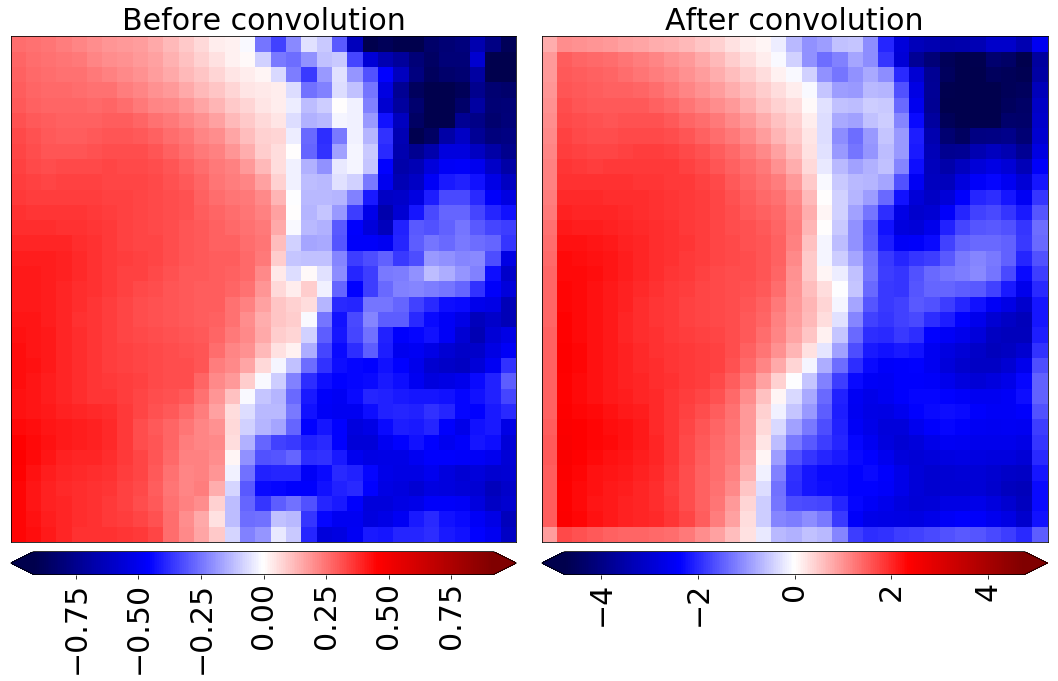

In [19]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1)
)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=True, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output feature map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

## Random Convolution: Example 2

Example 1 shows that, when the input data are **not** zero-centered, edge-padding with zeros is a bad idea.  It leads to artifacts around the edge of the output feature map.

The following example does not use edge-padding (otherwise, it is the same as example 1).  This means that the kernel can occupy only $31 \times 31$, rather than $33 \times 33$, positions in the input feature map.  Thus, the output feature map is $31 \times 31$.  In other words, convolution without edge-padding shrinks the feature maps.  In general, if the input feature maps are $M \times N$ and the kernel is $J \times K$, the output feature maps will be $(M - J + 1) \times (N - K + 1)$.

Again, feel free to play with `num_kernel_rows` and `num_kernel_columns`.  As you increase these values, the size of the output feature map will decrease.

What else happens as you increase `num_kernel_rows` and `num_kernel_columns`?  What happens when you make the two values unequal?

Shape of output feature map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

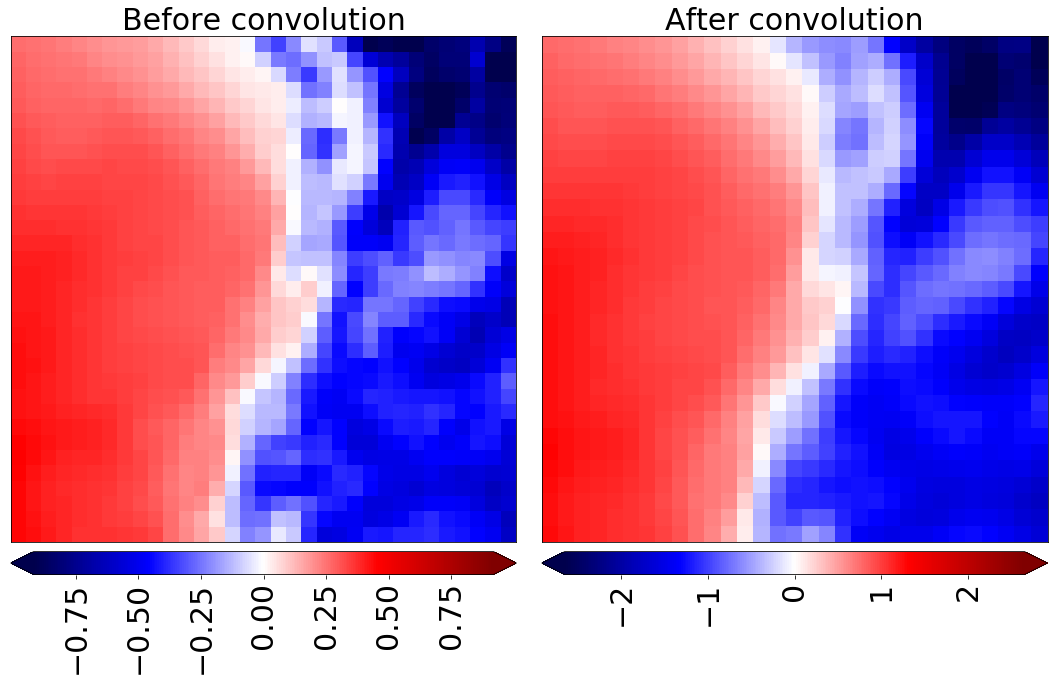

In [20]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1)
)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output feature map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

## Random Convolution: Example 3

The following example does strided convolution (otherwise, it is the same as example 2).

The stride length is 2 pixels, so the output feature maps are decreased in size by a factor of 2.  Actually, they're decreased by a little more than this, because again we're not doing edge-padding.

For strided convolution **with** edge-padding, if the input feature maps are $M \times N$, kernel is $J \times K$, and stride length is $L$, the output feature maps will be $\left\lfloor \frac{M}{L} \right\rfloor \times \left\lfloor \frac{N}{L} \right\rfloor$, where $\left\lfloor \textrm{ } \right\rfloor$ is the floor function.

For strided convolution **without** edge-padding, if the input feature maps are $M \times N$, kernel is $J \times K$, and stride length is $L$, the output feature maps will be $\left\lfloor \frac{M - J + 1}{L} \right\rfloor \times \left\lfloor \frac{N - K + 1}{L} \right\rfloor$.

Feel free to play with `num_kernel_rows`, `num_kernel_columns`, and `stride_length_px` -- and see what happens.

Shape of output feature map = (16, 16)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

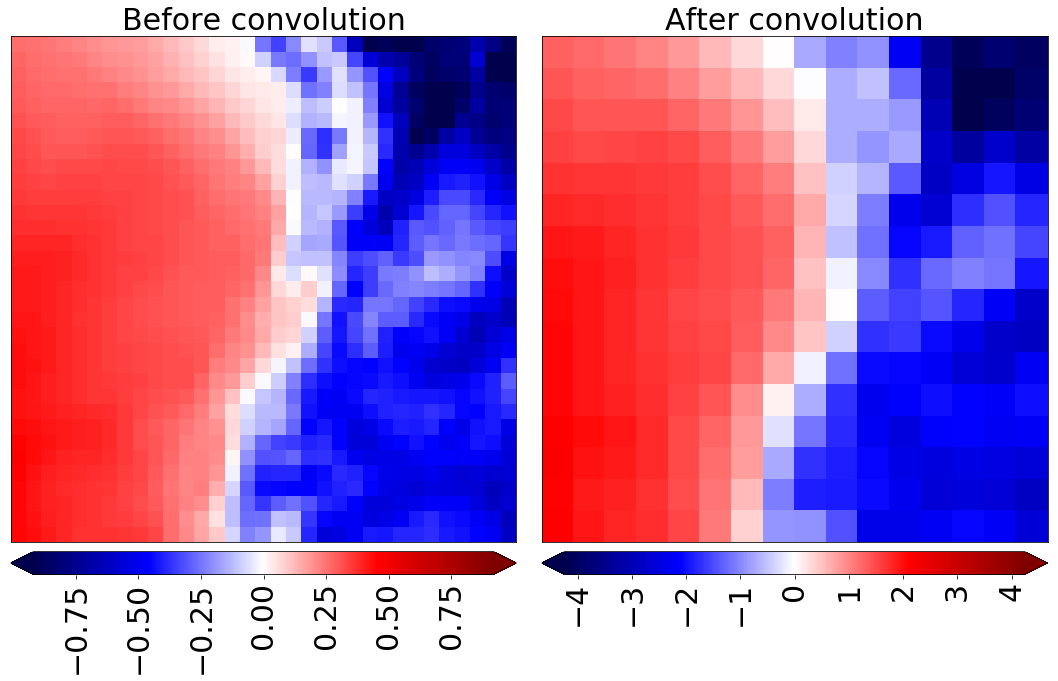

In [21]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1)
)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=2)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output feature map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

## Edge Detection: Example 1

The next cell does convolution with the following options:

 - One input channel and one output channel (same as random examples 1-3).
 - Stride length = 1 (same as random examples 1-2).
 - No edge-padding (same as random examples 2-3).

The difference here is that the kernel is pre-determined, rather than generated randomly, using `EDGE_DETECTOR_MATRIX1`, defined at the top of the notebook.  `EDGE_DETECTOR_MATRIX1` is known to be a good edge-detector and was used in image-processing long before deep learning.

We expect the output feature map to "light up" (have large absolute values) where the input feature map has edges (large gradients).  The input feature map contains wet-bulb potential temperature ($\theta_w$), and large gradients of $\theta_w$ are often caused by a front.

Note where you see the largest values in the output feature map.  What do you see in corresponding areas of the input ($\theta_w$) map?  Note that the input map uses a perceptually uniform colour scheme.

Shape of output feature map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

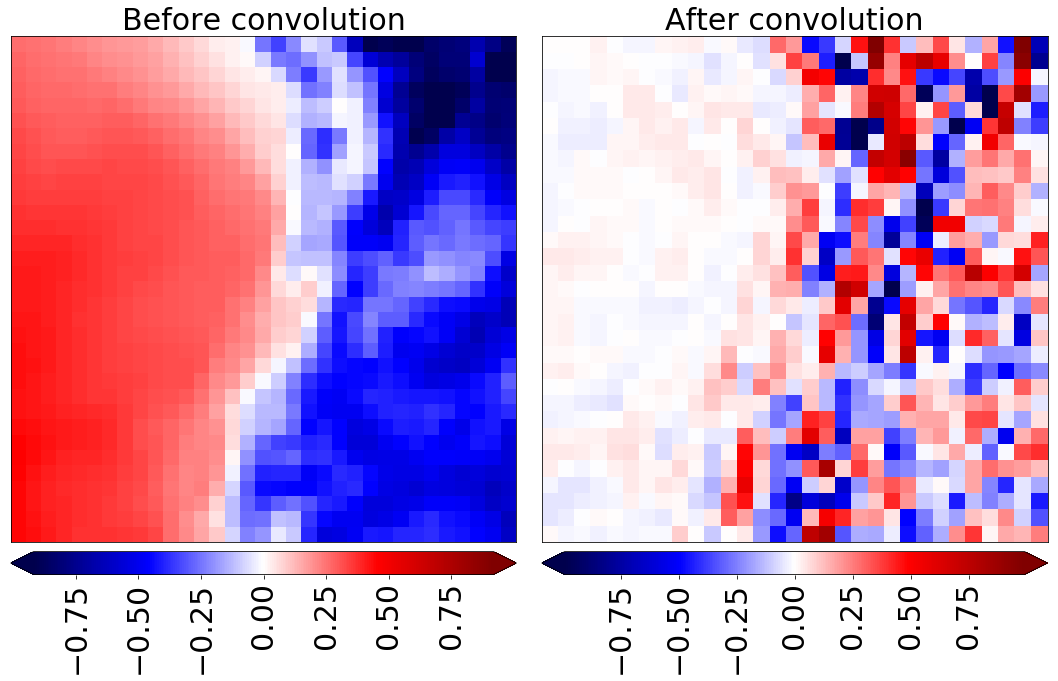

In [22]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output feature map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

## Edge Detection: Example 2

The following example is the same as edge-detection example 1, but with a different pre-defined kernel (`EDGE_DETECTOR_MATRIX2`).  `EDGE_DETECTOR_MATRIX2` is also known to be a good edge-detector and has been used in image-processing for a long time.

Shape of output feature map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

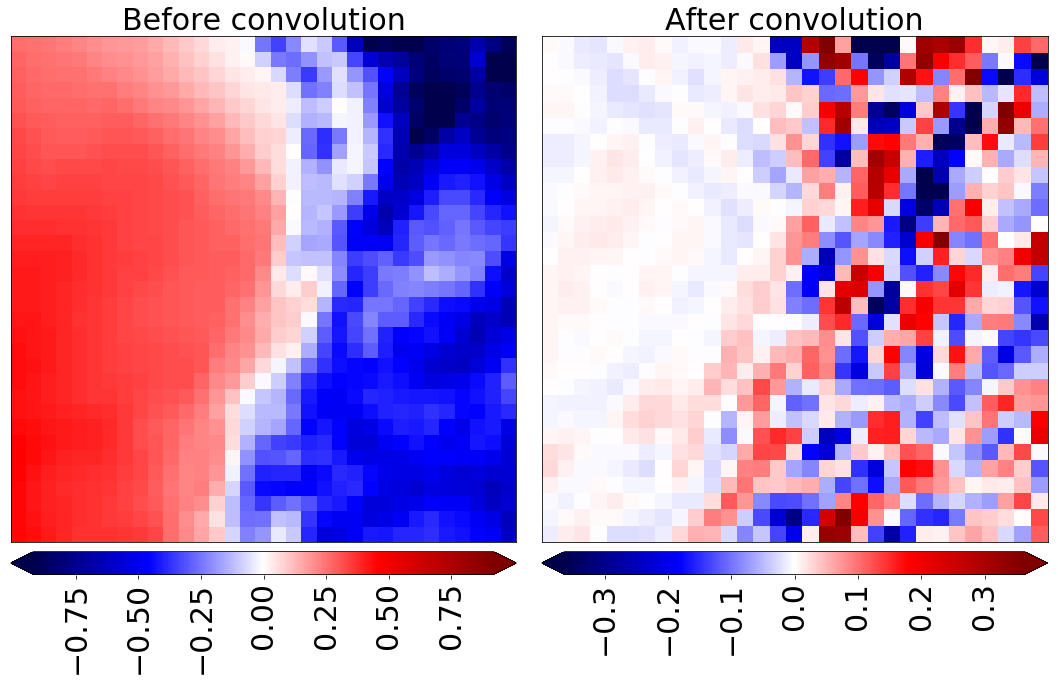

In [24]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX2, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output feature map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

## Edge Detection: Example 3

Same as examples 1 and 2, but with yet another pre-defined kernel (`EDGE_DETECTOR_MATRIX3`).

Shape of output feature map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

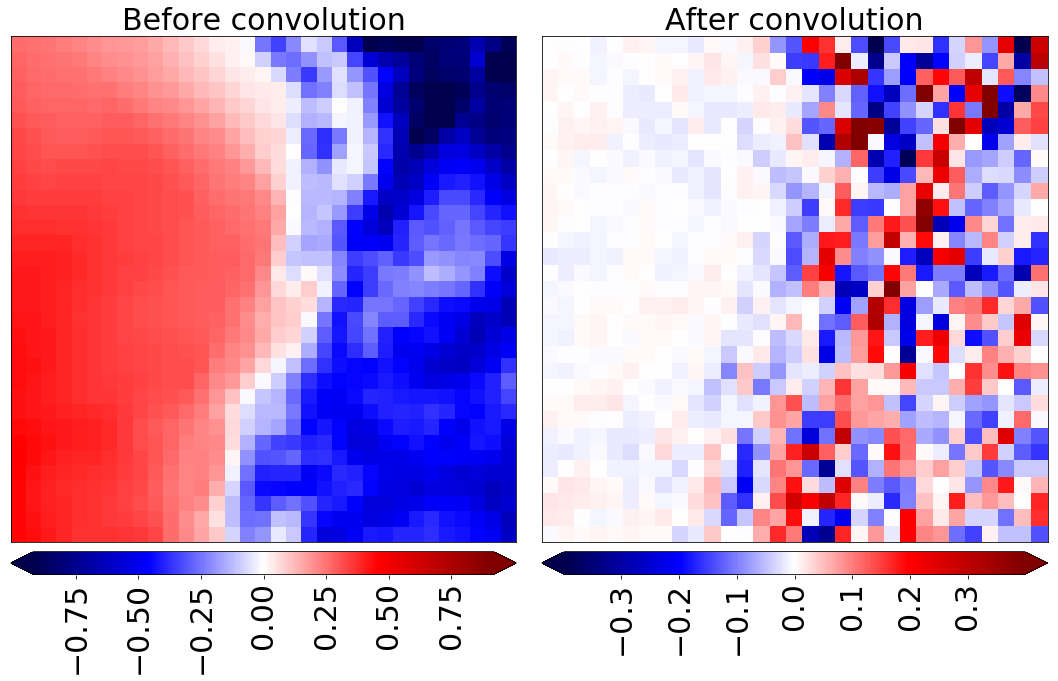

In [25]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX3, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output feature map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Plotting Wind Fields

The following method plots a wind field, which you will need for the upcoming example on multi-channel convolution.  Wind velocity is a vector (containing both $u$- and $v$-components), so a wind field is a vector field, with two components at each grid cell.  This necessitates a special plotting method, `plot_wind_barbs`.  If you haven't seen wind barbs before, don't worry.  For the purposes of this notebook, there are only two things you need to know:

1. At the end of each wind barb are one or more "appendages" (short lines, long lines, and flags).  In standard meteorological plots, each short line is 5 kt of wind speed; each long line is 10 kt; and each flag is 50 kt.  1 kt = 1 nautical mile per hour = 1.15 statute miles per hour = 1.15 mph.

  However, in this case, the wind fields have already been normalized and we do not know the original speeds.  Thus, short lines, long lines, and flags correspond to 0.1, 0.2, and 1.0 normalized units, respectively.  The take-home point is that barbs with more appendages signify greater wind speeds.

2. The end of the wind barb (the one with all the appendages) points in the **direction of origin**.  This is the direction that the wind is **blowing from**, not the direction it is blowing towards.

In [93]:
def plot_wind_barbs(
        u_wind_matrix, v_wind_matrix, axes_object=None,
        colour_map_object=WIND_COLOUR_MAP_OBJECT, min_colour_speed=-1.,
        max_colour_speed=0., barb_length=8, empty_barb_radius=0.1):
    """Uses barbs to plot wind field.

    Default input args for `colour_map_object`, `min_colour_speed`, and
    `max_colour_speed` will make all wind barbs black, regardless of their
    speed.

    :param u_wind_matrix: M-by-N numpy array of eastward velocities.
    :param v_wind_matrix: M-by-N numpy array of northward velocities.
    :param axes_object: See doc for `plot_feature_map`.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_speed: Minimum speed (velocity magnitude) in colour map.
    :param max_colour_speed: Max speed in colour map.
    :param barb_length: Length of each wind barb.
    :param empty_barb_radius: Radius for "empty" wind barb (zero speed).
    :return: axes_object: See doc for `plot_feature_map`.
    """

    error_checking.assert_is_numpy_array_without_nan(u_wind_matrix)
    error_checking.assert_is_numpy_array(u_wind_matrix, num_dimensions=2)

    error_checking.assert_is_numpy_array_without_nan(v_wind_matrix)
    error_checking.assert_is_numpy_array(
        v_wind_matrix, exact_dimensions=numpy.array(u_wind_matrix.shape)
    )

    error_checking.assert_is_greater(max_colour_speed, min_colour_speed)
    error_checking.assert_is_geq(max_colour_speed, 0.)

    barb_size_dict = {
        'emptybarb': empty_barb_radius
    }
    barb_increment_dict = {
        'half': 0.1,
        'full': 0.2,
        'flag': 1.
    }

    wind_speed_matrix = numpy.sqrt(u_wind_matrix ** 2 + v_wind_matrix ** 2)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    axes_object.barbs(
        u_wind_matrix, v_wind_matrix, wind_speed_matrix, length=barb_length,
        sizes=barb_size_dict, barb_increments=barb_increment_dict,
        fill_empty=True, rounding=False, cmap=colour_map_object,
        clim=numpy.array([min_colour_speed, max_colour_speed])
    )

    return axes_object

## Example: Multi-channel Convolution

The following cell does stand-alone convolution with multiple channels.  There are 3 input channels, listed below:

 - Wet-bulb potential temperature ($\theta_w$)
 - $u$-wind
 - $v$-wind

Also, there are 3 output channels.  The output channels cannot easily be given meaningful names, because each output channel is produced by convolving over all 3 input channels.  Thus, each output channel is a different transformation of the 3 input variables.

Once again, the kernel is pre-defined.  In general the kernel matrix is $J \times K \times C_i \times C_o$, where $J$ = number of kernel rows; $K$ = number of kernel columns; $C_i$ = number of input channels; and $C_o$ = number of output channels.  Thus, in this case the kernel matrix is $3 \times 3 \times 3 \times 3$.  For all input channels $c$, `kernel_matrix[c, :, :, 0] = EDGE_DETECTOR_MATRIX1`; in other words, the part of the kernel connecting to output channel 0 uses `EDGE_DETECTOR_MATRIX1` to detect edges in all 3 input channels.  Similarly, `kernel_matrix[c, :, :, 1] = EDGE_DETECTOR_MATRIX2` and `kernel_matrix[c, :, :, 2] = EDGE_DETECTOR_MATRIX3`.  In other words, the part connecting to output channel 1 uses `EDGE_DETECTOR_MATRIX2`, and the part connecting to output channel 2 uses `EDGE_DETECTOR_MATRIX3`, to detect edges in all 3 input channels.

Keep in mind that, during the training of an actual CNN, all weights in the kernel matrix are **learned**.

Where do the output feature maps light up?  Why?

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it wi

(31, 31, 3)
0.62790006


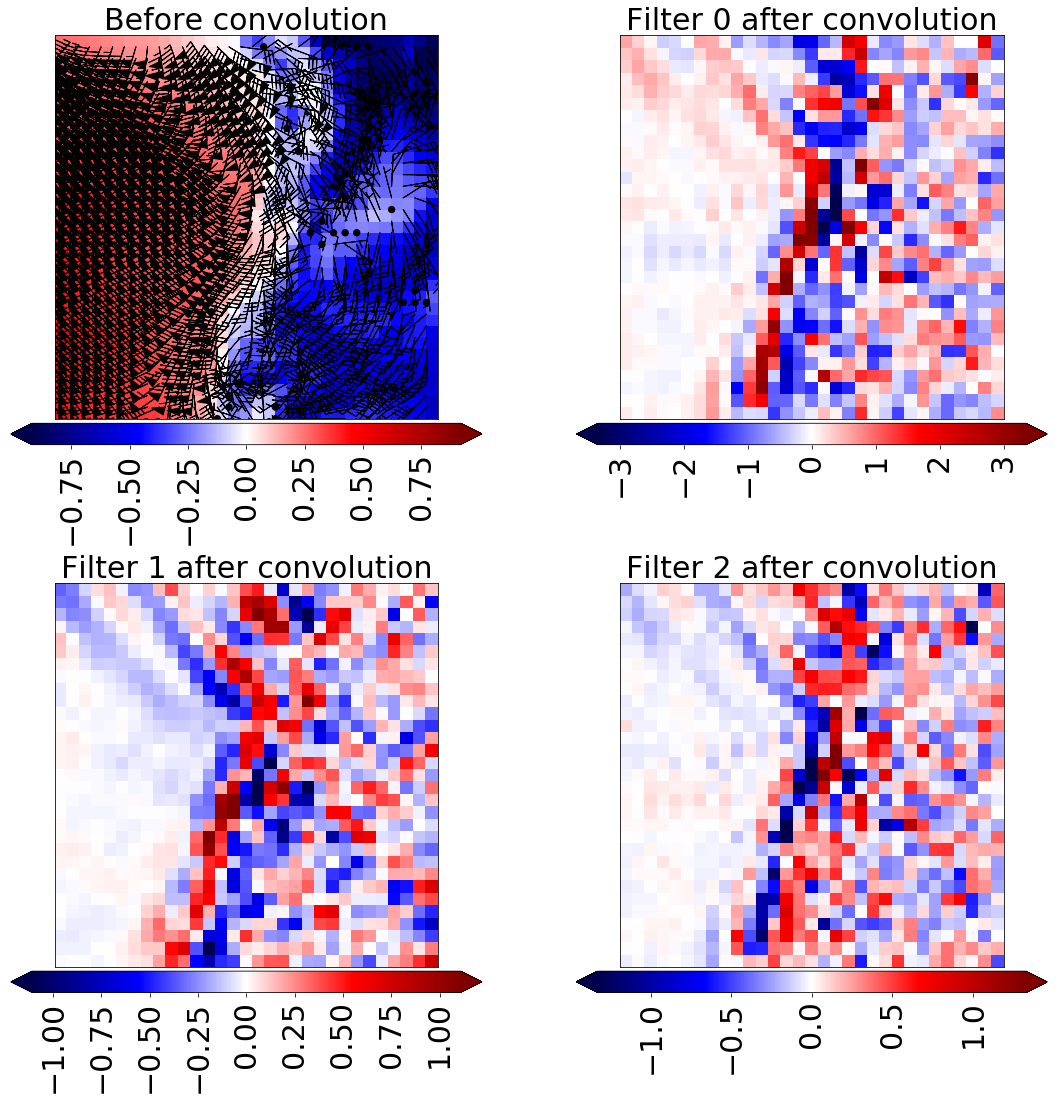

In [109]:
temperature_matrix = predictor_matrix[
    8, ..., predictor_names.index(TEMPERATURE_NAME)
]
u_wind_matrix = predictor_matrix[
    8, ..., predictor_names.index(U_WIND_GRID_RELATIVE_NAME)
]
v_wind_matrix = predictor_matrix[
    8, ..., predictor_names.index(V_WIND_GRID_RELATIVE_NAME)
]

_, axes_object_matrix = _create_paneled_figure(
    num_rows=2, num_columns=2,
    horizontal_spacing=0.2, vertical_spacing=0.2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
plot_wind_barbs(
    u_wind_matrix=u_wind_matrix, v_wind_matrix=v_wind_matrix,
    axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

kernel_matrix_to_channel0 = numpy.repeat(
    a=numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1), repeats=3, axis=-1
)
kernel_matrix_to_channel1 = numpy.repeat(
    a=numpy.expand_dims(EDGE_DETECTOR_MATRIX2, axis=-1), repeats=3, axis=-1
)
kernel_matrix_to_channel2 = numpy.repeat(
    a=numpy.expand_dims(EDGE_DETECTOR_MATRIX3, axis=-1), repeats=3, axis=-1
)
kernel_matrix = numpy.stack((
    kernel_matrix_to_channel0, kernel_matrix_to_channel1,
    kernel_matrix_to_channel2
), axis=-1)

feature_matrix = numpy.stack(
    (temperature_matrix, u_wind_matrix, v_wind_matrix), axis=-1
)
feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

feature_matrix = feature_matrix[0, ...]
num_output_channels = feature_matrix.shape[-1]

for k in range(num_output_channels):
    this_axes_object = numpy.ravel(axes_object_matrix)[k + 1]
    plot_feature_map(
        feature_matrix=feature_matrix[..., k], axes_object=this_axes_object
    )

    this_axes_object.set_title('Filter {0:d} after convolution'.format(k))

# Activation

After each convolutional layer (and each dense layer, as you will see later), the feature maps should be passed through a non-linear activation function.  Convolution is a linear operation, and any series of linear operations is still linear, so without non-linear activations the CNN would be unable to learn non-linear relationships.  This is important because most real-world problems (especially in meteorology) are non-linear.

The following method uses one of six activations (see `VALID_ACTIVATION_FUNCTION_NAMES` at the top of this notebook) to transform an array of input values (with any dimensions) to an array of output values (with the same dimensions).  The output values are called "activations" (there is no standard name for the input values, except maybe "activation-function inputs").

In [7]:
def do_activation(input_values, function_name, alpha_parameter=0.2):
    """Runs input array through activation function.

    :param input_values: Input numpy array.
    :param function_name: Name of activation function (must be accepted by
        `_check_activation_function`).
    :param alpha_parameter: Slope (used only for eLU and leaky ReLU functions).
    :return: output_values: Output numpy array (after activation).  Same
        dimensions.
    """

    _check_activation_function(function_name)
    input_object = K.placeholder()

    if function_name == ELU_FUNCTION_NAME:
        function_object = K.function(
            [input_object],
            [keras.layers.ELU(alpha=alpha_parameter)(input_object)]
        )
    elif function_name == LEAKY_RELU_FUNCTION_NAME:
        function_object = K.function(
            [input_object],
            [keras.layers.LeakyReLU(alpha=alpha_parameter)(input_object)]
        )
    else:
        function_object = K.function(
            [input_object],
            [keras.layers.Activation(function_name)(input_object)]
        )

    return function_object([input_values])[0]

## Activation Example 1

The following example graphs three "standard" activation functions.  The sigmoid and tanh (hyperbolic tangent) functions have been used in machine learning for a long time.  The ReLU (rectified linear unit) function is relatively new (Nair and Hinton 2010) but has become very common.

The following example is adapted from the [Swirlnet tutorial](https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb), which demonstrates the use of deep learning to predict mesocyclones in numerically modeled supercell thunderstorms.  Swirlnet is another great resource for learning about deep learning and its applications to meteorology.

Nair, V., and G. Hinton, 2010: "Rectified linear units improve restricted Boltzmann machines." *International Conference on Machine Learning*, Haifa, Israel, International Machine Learning Society. [[link]](https://www.cs.toronto.edu/~hinton/absps/reluICML.pdf)

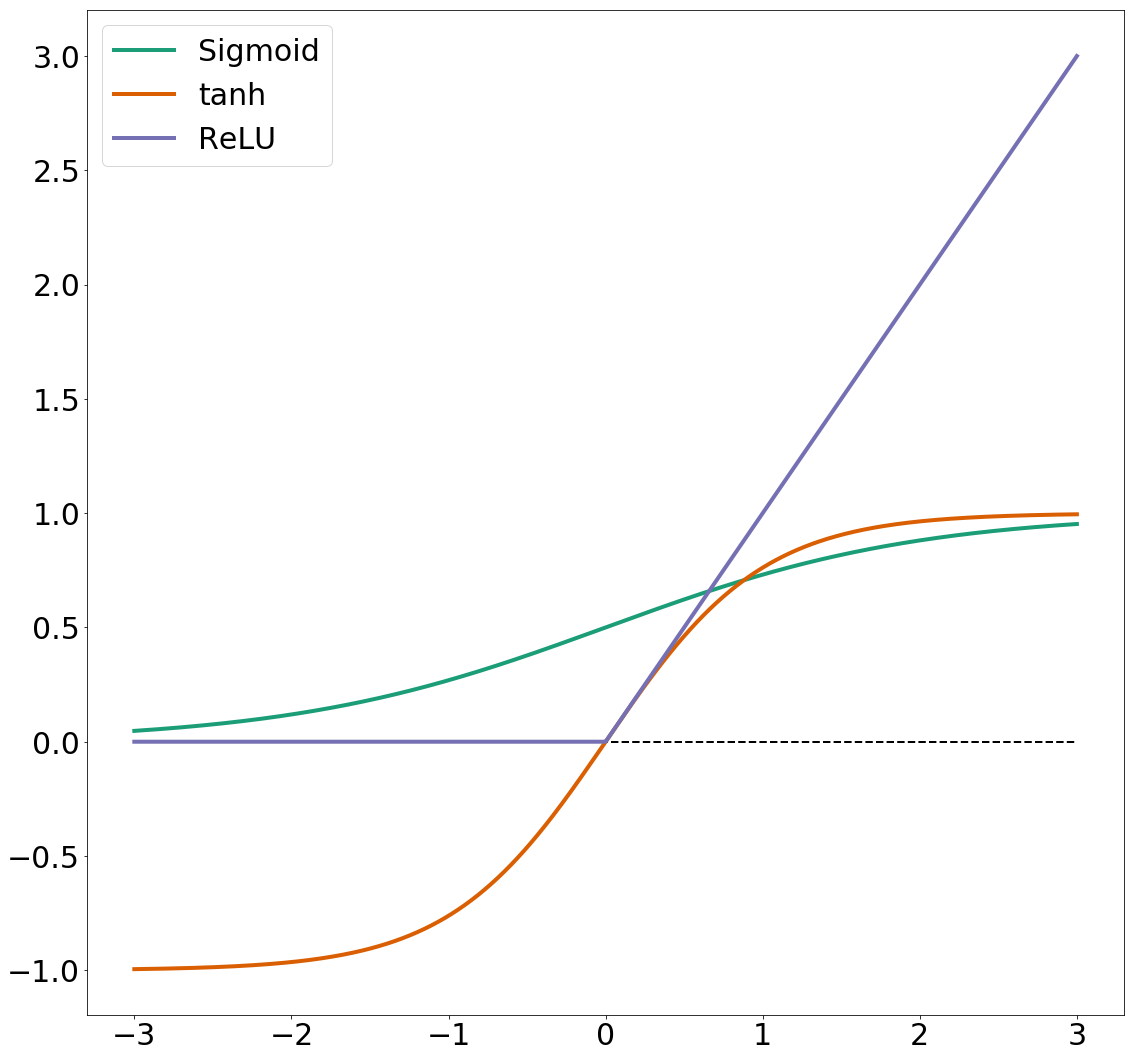

In [9]:
function_names_keras = [
    SIGMOID_FUNCTION_NAME, TANH_FUNCTION_NAME, RELU_FUNCTION_NAME
]
function_names_fancy = ['Sigmoid', 'tanh', 'ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

line_width = 4
colour_by_function = numpy.array([[27, 158, 119],
                                  [217, 95, 2],
                                  [117, 112, 179]], dtype=float) / 255

_, axes_objects_2d_list = _init_figure_panels(num_rows=1, num_columns=1)
axes_object = axes_objects_2d_list[0][0]

axes_object.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=line_width / 2, linestyle='dashed', color=numpy.full(3, 0.))

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i])

    axes_object.plot(
        input_values, these_output_values,
        linewidth=line_width, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i])

axes_object.legend()
pyplot.savefig('/home/ryan.lagerquist/Downloads/classes/cs5033_fall2018/standard_activations.jpg', dpi=600)

## Activation Example 2

The following example graphs three "fancy" activation functions: eLU (exponential linear unit; Clevert *et al.* 2016), SeLU (scaled exponential linear unit; Klambauer *et al.* 2017), and leaky ReLU (Maas *et al.* 2013).  The benefit of all these functions is that they preserve some information from negative inputs, whereas plain ReLU transforms all negative inputs to zero.

Clevert, D.-A., T. Unterthiner, and S. Hochreiter, 2016: "Fast and accurate deep network learning by exponential linear units (ELUs)." *arXiv e-prints*, **1511 (07289v5)**. [[link]](https://arxiv.org/abs/1511.07289)

Klambauer, G., T. Unterthiner, A. Mayr, and S. Hochreiter, 2017: "Self-normalizing neural networks." *arXiv e-prints*, **1706 (02515v5)**. [[link]](https://arxiv.org/abs/1706.02515)

Maas, A.L., A.Y. Hannun, and A.Y. Ng: "Rectifier nonlinearities improve neural network acoustic models." *International Conference on Machine Learning*, Atlanta, GA, International Machine Learning Society. [[link]](https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)

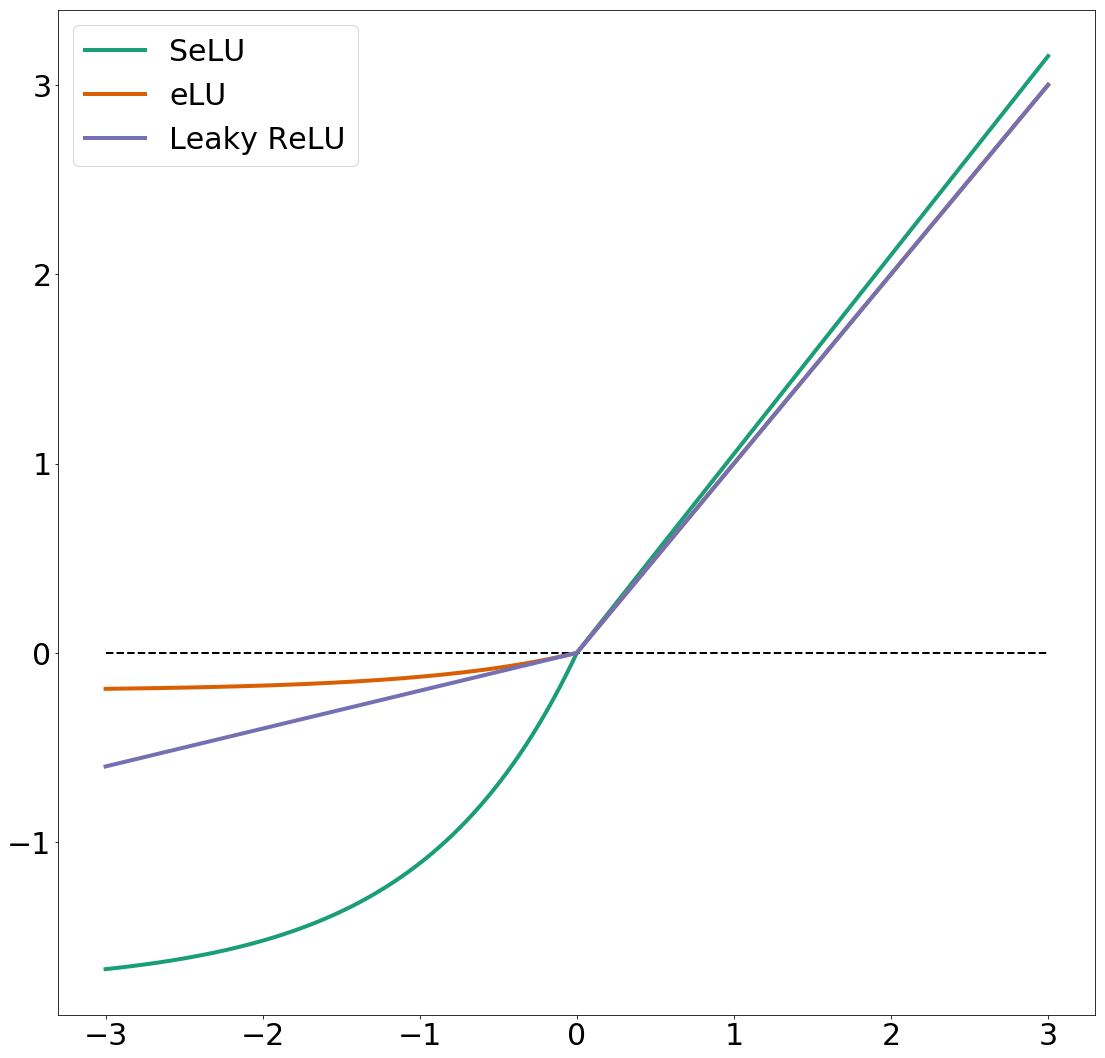

In [10]:
function_names_keras = [
    SELU_FUNCTION_NAME, ELU_FUNCTION_NAME, LEAKY_RELU_FUNCTION_NAME
]
function_names_fancy = ['SeLU', 'eLU', 'Leaky ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

line_width = 4
colour_by_function = numpy.array([[27, 158, 119],
                                  [217, 95, 2],
                                  [117, 112, 179]], dtype=float) / 255

_, axes_objects_2d_list = _init_figure_panels(num_rows=1, num_columns=1)
axes_object = axes_objects_2d_list[0][0]

axes_object.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=line_width / 2, linestyle='dashed', color=numpy.full(3, 0.))

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i])

    axes_object.plot(
        input_values, these_output_values,
        linewidth=line_width, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i])

axes_object.legend()
pyplot.savefig('/home/ryan.lagerquist/Downloads/classes/cs5033_fall2018/fancy_activations.jpg', dpi=600)

# Pooling

The following method performs stand-alone 2-D pooling.  Again, "stand-alone" means that the pooling is done outside of CNN-training.  "2-D" means that both the input and output feature maps are 2-D.

In [30]:
def do_2d_pooling(
        feature_matrix, stride_length_px=2, pooling_type_string='max'):
    """Runs 2-D feature maps through pooling filter.

    M = number of rows before pooling
    N = number of columns after pooling
    m = number of rows after pooling
    n = number of columns after pooling

    :param feature_matrix: Input feature maps (numpy array).  Dimensions must be
        M x N x C_i or 1 x M x N x C_i.
    :param stride_length_px: Stride length (pixels).  The pooling window will
        move by this many rows or columns at a time as it slides over each input
        feature map.
    :param pooling_type_string: Pooling type (must be accepted by
        `_check_pooling_type`).
    :return: feature_matrix: Output feature maps (numpy array).  Dimensions will
        be 1 x m x n x C.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 2)
    _check_pooling_type(pooling_type_string)

    if len(feature_matrix.shape) == 3:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)

    feature_tensor = K.pool2d(
        x=K.variable(feature_matrix), pool_mode=pooling_type_string,
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px), padding='valid',
        data_format='channels_last')
    return feature_tensor.eval(session=K.get_session())

## Pooling Example 1

Unlike convolution, a pooling layer cannot change the number of feature maps.  Thus, if a pooling layer receives $C$ feature maps, it must output $C$ feature maps.

Instead, pooling decreases the spatial resolution of the feature maps.  Specifically, a pooling layer with stride length $L$ decreases the resolution by a factor of $L$.  If the input feature maps have dimensions of $M \times N$ ($M$ rows and $N$ columns), the output feature maps will have dimensions of $\left\lfloor \frac{M}{L} \right\rfloor \times \left\lfloor \frac{N}{L} \right\rfloor$.

There are two types of pooling: max and mean.  In max (mean)-pooling, each value in the output map is produced by taking the max (mean) within an $L \times L$ window of the input map.

The following example does max-pooling with a stride length of 2 pixels.  The input feature map is $33 \times 33$ and has 32-km grid spacing (because it comes directly from the NARR).  The output map is $16 \times 16$ and has 64-km grid spacing.

Text(0.5,1,'After max-pooling')

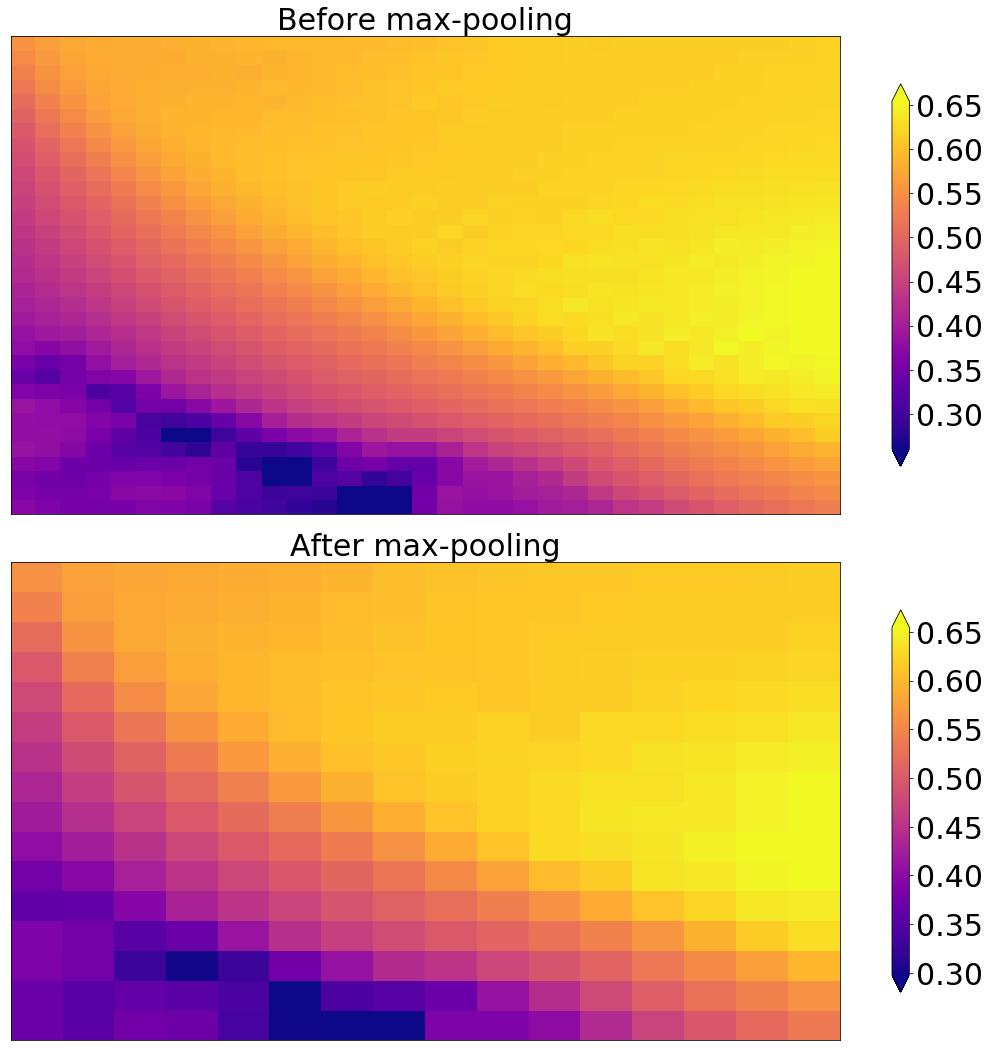

In [31]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before max-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After max-pooling')

## Pooling Example 2

This example does mean-pooling with a stride length of 2 pixels.

Text(0.5,1,'After mean-pooling')

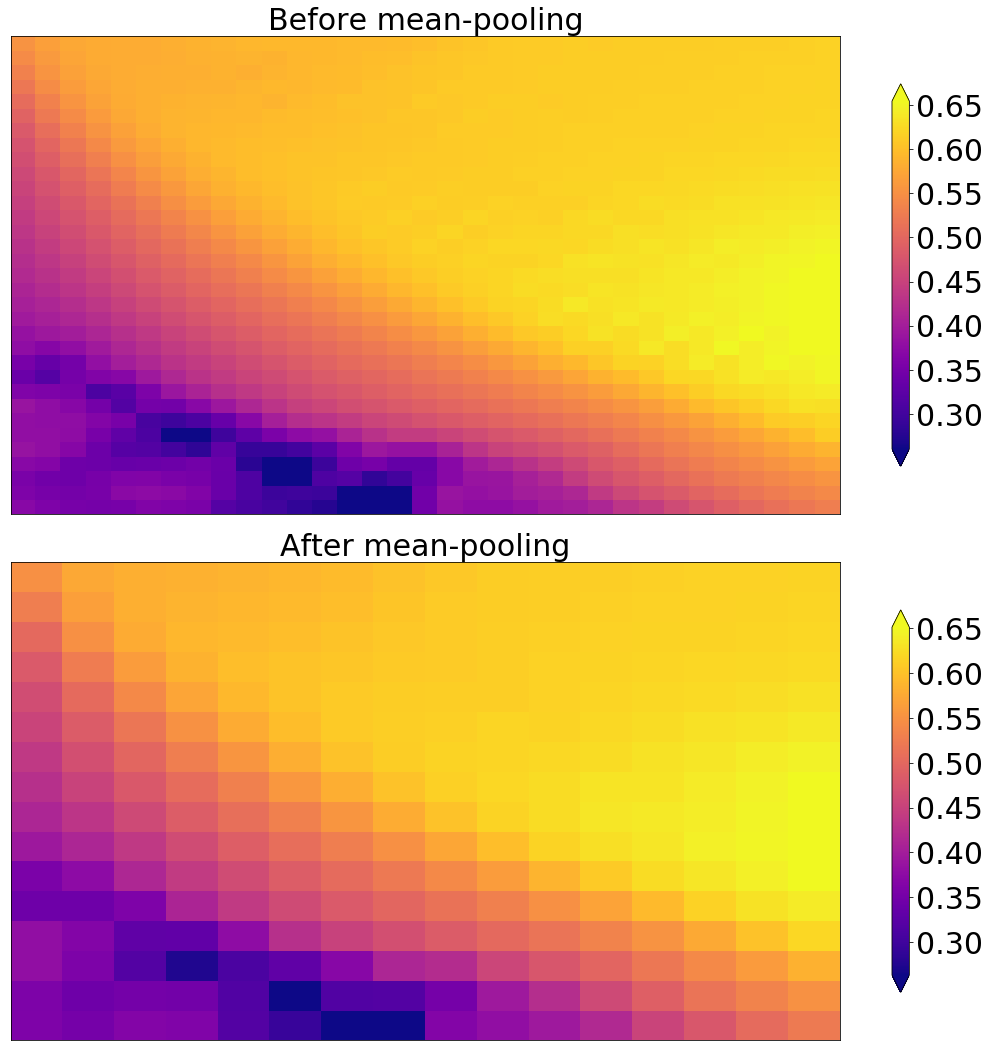

In [32]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before mean-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MEAN_POOLING_TYPE_STRING)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After mean-pooling')

## Pooling Example 3

This example does max-pooling with a stride length of 4 pixels.

Try other combinations of stride length and pooling type.  What do you discover?

Text(0.5,1,'After max-pooling')

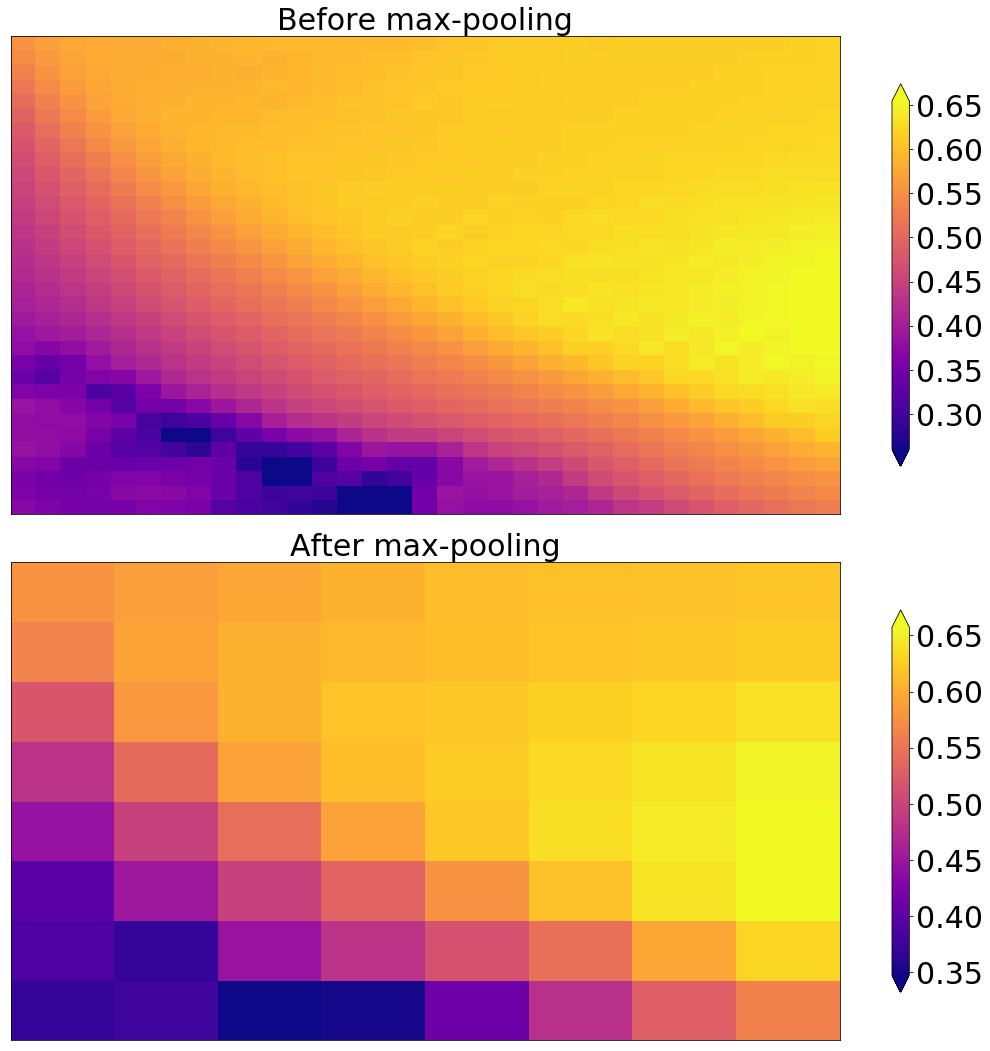

In [33]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before max-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=4,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After max-pooling')

# Workflow of a CNN: Example 1

In a real CNN, a convolutional layer is often followed by an activation layer, then a pooling layer.  Pooling allows deeper convolutional layers to learn larger-scale features.

The following example shows one sequence of convolution, activation, and pooling.

Text(0.5,1,'After pooling')

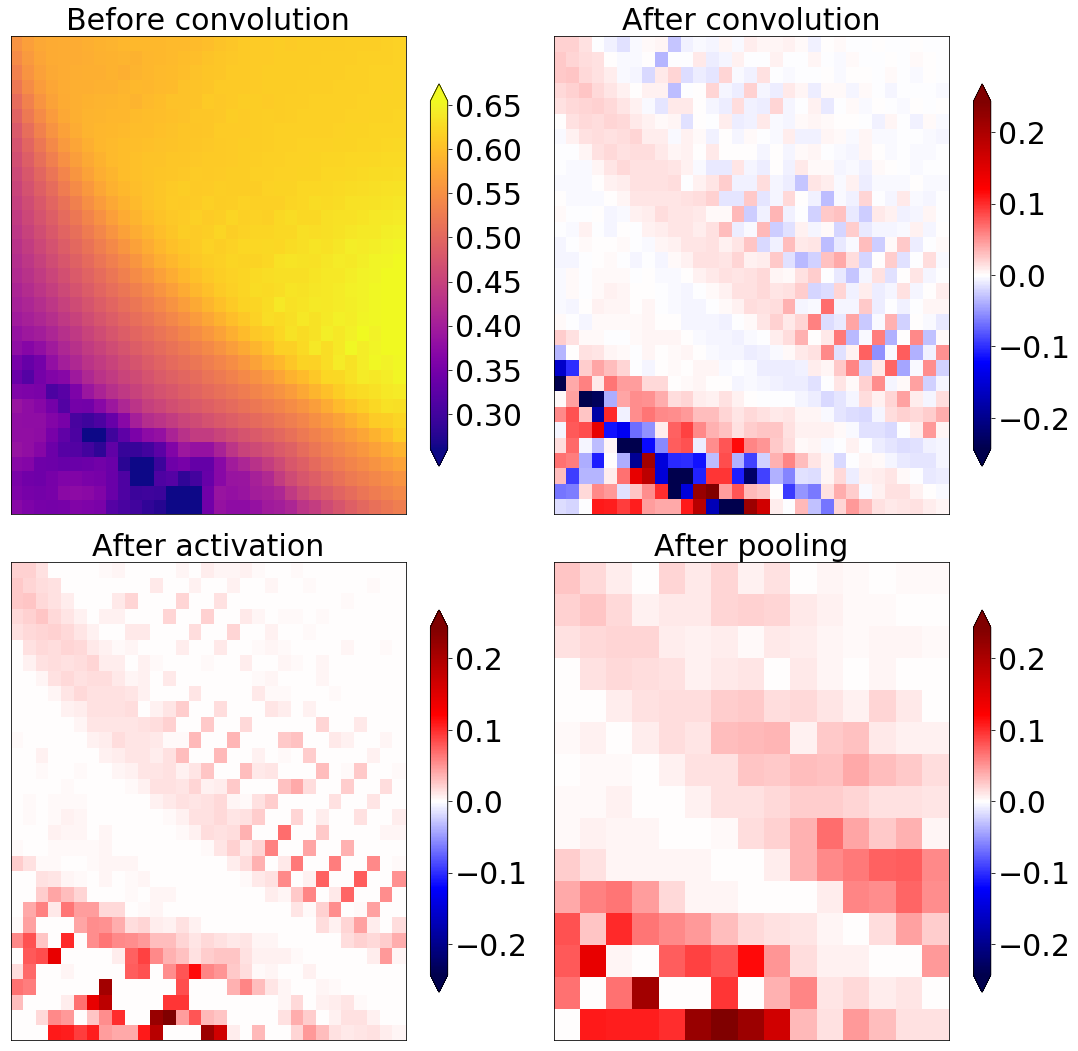

In [34]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=2)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[0][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[0][1].set_title('After convolution')

feature_matrix = do_activation(
    input_values=feature_matrix, function_name='relu')

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][0].set_title('After activation')

feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][1].set_title('After pooling')

# Batch Normalization

Batch normalization (Ioffe and Szegedy 2015) is essentially normalization for features, as opposed to the raw input data.  You can read more about the benefit of batch normalization [here](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c).

Batch normalization is typically applied after the activation layer.  Batch normalization is applied separately to each feature $x_j$ in each batch, using the following equation.  $\overline{x_{j}}$ is the mean value of $x_j$ within the batch, $s_j$ is the standard deviation of $x_j$ within the batch; $\gamma$ is the scale parameter; $\beta$ is the shift parameter; $x_{ij}$ is the original value for example $i$; and $x'_{ij}$ is the batch-normalized value for example $i$.  $\gamma$ and $\beta$ are **learned** during training.

$x'_{ij} = \gamma \frac{x_{ij} - \overline{x_{j}}}{s_j} + \beta$

Ioffe, S., and C. Szegedy, 2015: "Batch normalization: Accelerating deep network training by reducing internal covariate shift." *International Conference on Machine Learning*, Lille, France, International Machine Learning Society. [[link]](https://arxiv.org/abs/1502.03167)

In [35]:
def do_batch_normalization(
        feature_matrix, scale_parameter=1., shift_parameter=0.):
    """Performs batch normalization on each feature in the batch.

    :param feature_matrix: E-by-M-by-N-by-C numpy array of feature values.
    :param scale_parameter: Scale parameter (beta in the equation on page 3 of
        Ioffe and Szegedy 2015).
    :param shift_parameter: Shift parameter (gamma in the equation).
    :return: feature_matrix: Feature matrix after batch norm (same dimensions).
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)
    error_checking.assert_is_greater(scale_parameter, 0.)

    # The following matrices will be M x N x C.
    stdev_matrix = numpy.std(feature_matrix, axis=0, ddof=1)
    mean_matrix = numpy.mean(feature_matrix, axis=0)

    # The following matrices will be E x M x N x C.
    stdev_matrix = numpy.expand_dims(stdev_matrix, axis=0)
    stdev_matrix = numpy.repeat(stdev_matrix, feature_matrix.shape[0], axis=0)
    mean_matrix = numpy.expand_dims(mean_matrix, axis=0)
    mean_matrix = numpy.repeat(mean_matrix, feature_matrix.shape[0], axis=0)

    return shift_parameter + scale_parameter * (
        (feature_matrix - mean_matrix) / (stdev_matrix + K.epsilon())
    )

# Batch Normalization: Example 1

The following example applies batch normalization with the default $\gamma$ and $\beta$ ($\gamma = 1$ and $\beta = 0$, which corresponds to $z$-score normalization).

Text(0.5,1,'After batch normalization')

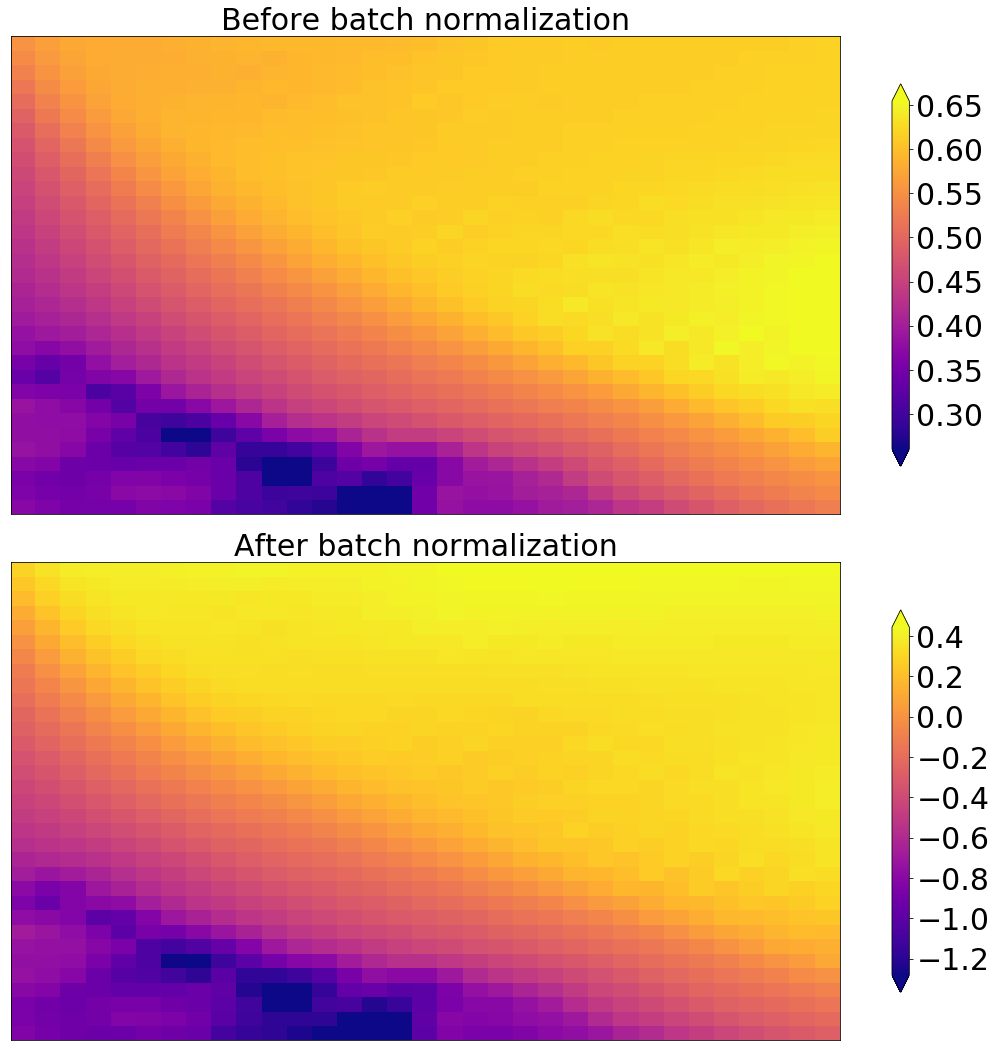

In [36]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix[0, ...],
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before batch normalization')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=1., shift_parameter=0.)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After batch normalization')

# Batch Normalization: Example 2

The following example applies batch normalization with custom values of $\gamma$ and $\beta$.

Try different values of $\gamma$ and $\beta$ (`scale_parameter` and `shift_parameter`, respectively).  See what happens.

Text(0.5,1,'After batch normalization')

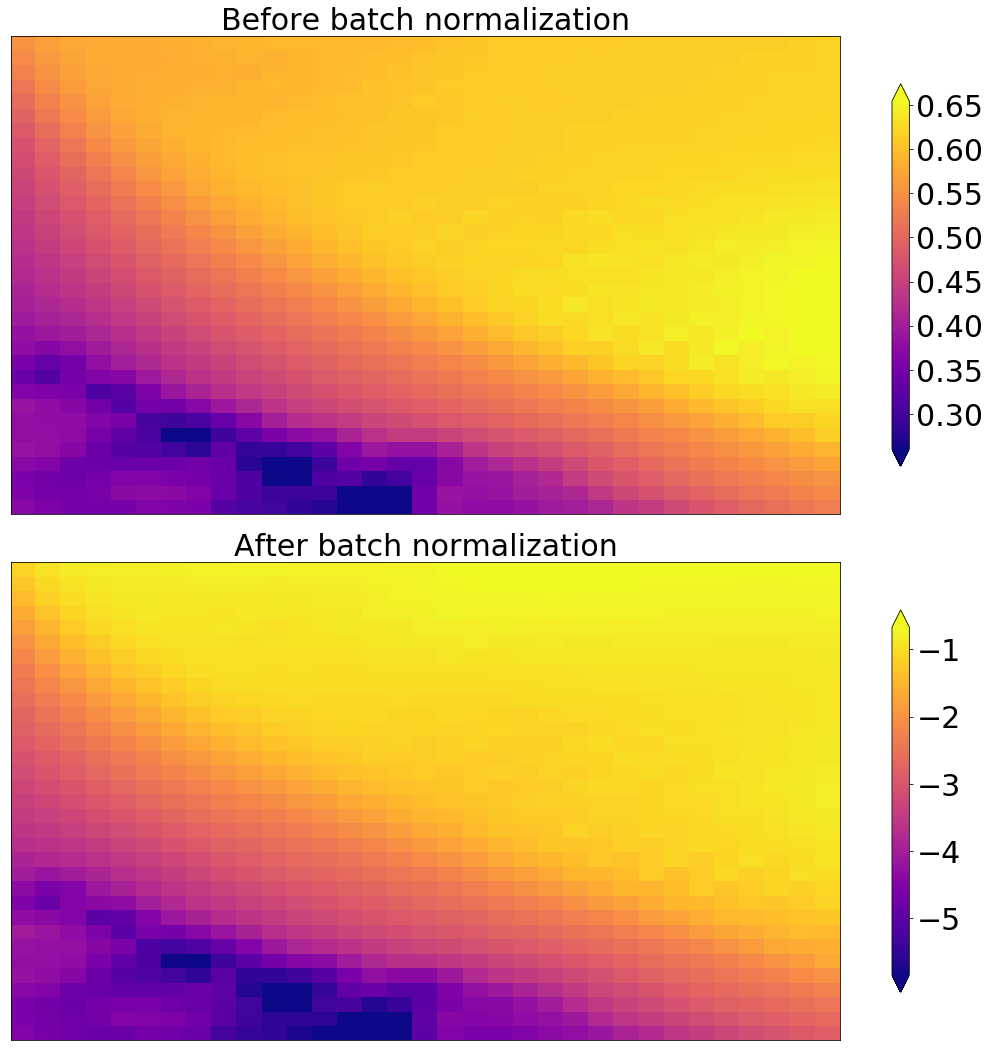

In [37]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix[0, ...],
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before batch normalization')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=3., shift_parameter=-2.)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After batch normalization')

# Workflow of a CNN: Example 2

The following example shows one sequence of convolution, activation, batch normalization, and pooling.

Note that the previous examples used only the first training example, whereas this one uses all training examples in the batch.  Why?

Try adjusting parameters to see if you can make the two "edges" in the input map ($\theta_w$ grid) light up even more in the last feature map.

Convolving over example 1 of 512...
Convolving over example 11 of 512...
Convolving over example 21 of 512...
Convolving over example 31 of 512...
Convolving over example 41 of 512...
Convolving over example 51 of 512...
Convolving over example 61 of 512...
Convolving over example 71 of 512...
Convolving over example 81 of 512...
Convolving over example 91 of 512...
Convolving over example 101 of 512...
Convolving over example 111 of 512...
Convolving over example 121 of 512...
Convolving over example 131 of 512...
Convolving over example 141 of 512...
Convolving over example 151 of 512...
Convolving over example 161 of 512...
Convolving over example 171 of 512...
Convolving over example 181 of 512...
Convolving over example 191 of 512...
Convolving over example 201 of 512...
Convolving over example 211 of 512...
Convolving over example 221 of 512...
Convolving over example 231 of 512...
Convolving over example 241 of 512...
Convolving over example 251 of 512...
Convolving over example

[]

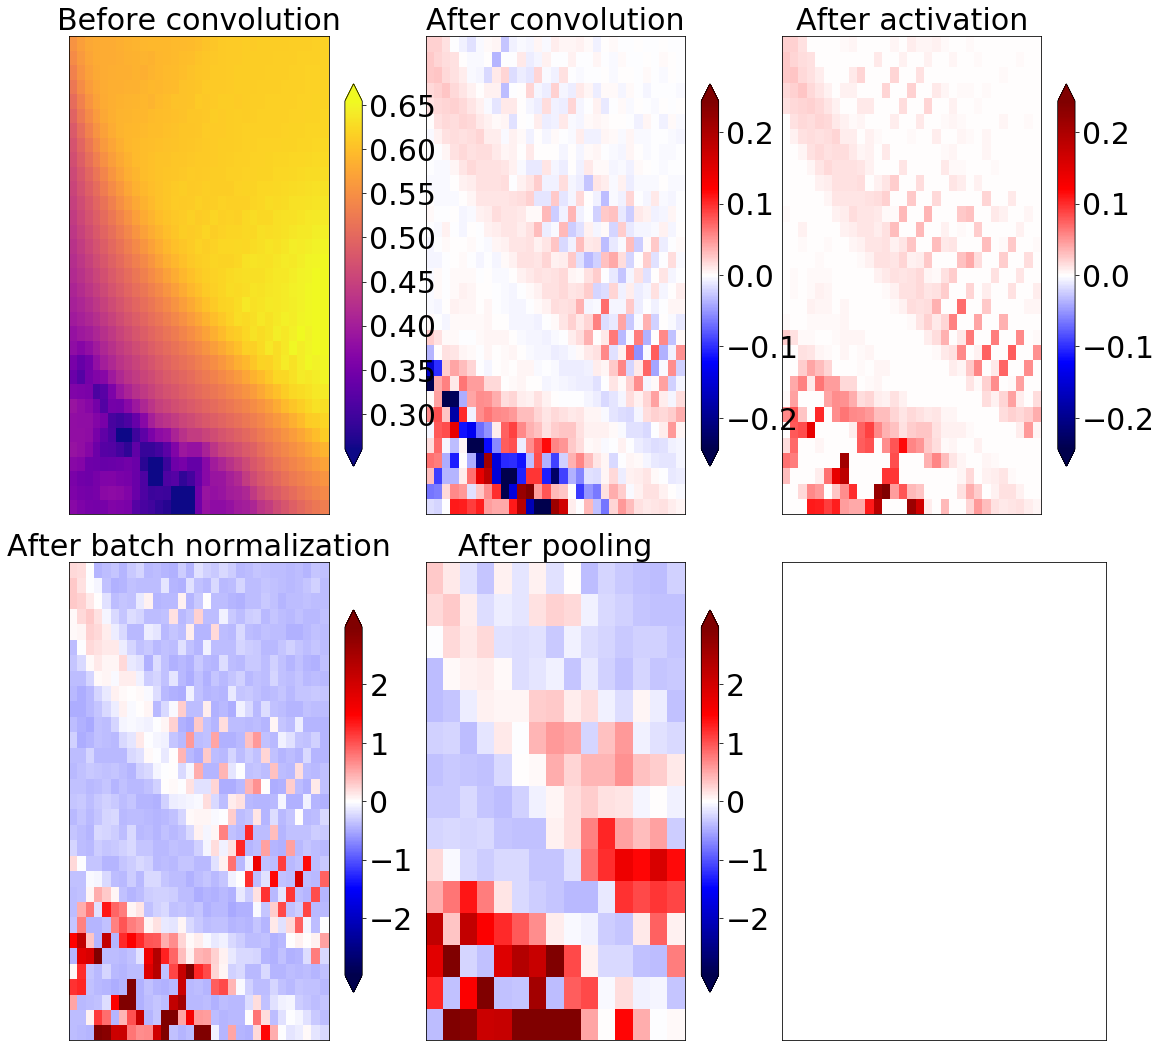

In [38]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[..., wet_bulb_theta_index]
# wet_bulb_theta_matrix = predictor_matrix[:50, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=3)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix[0, ...],
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

orig_feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = None
num_examples = orig_feature_matrix.shape[0]

for i in range(num_examples):
    if numpy.mod(i, 10) == 0:
        print 'Convolving over example {0:d} of {1:d}...'.format(
            i + 1, num_examples)

    this_feature_matrix = do_2d_convolution(
        feature_matrix=orig_feature_matrix[[i], ...],
        kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1)

    if feature_matrix is None:
        feature_matrix = this_feature_matrix + 0.
    else:
        feature_matrix = numpy.concatenate(
            (feature_matrix, this_feature_matrix), axis=0)

max_colour_value = numpy.percentile(
    numpy.absolute(feature_matrix[0, ...]), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[0][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[0][1].set_title('After convolution')

feature_matrix = do_activation(
    input_values=feature_matrix, function_name='relu')

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[0][2],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[0][2].set_title('After activation')

feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=1., shift_parameter=0.)
feature_matrix = feature_matrix[[0], ...]

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][0].set_title('After batch normalization')

feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][1].set_title('After pooling')

axes_objects_2d_list[1][2].set_xticks([])
axes_objects_2d_list[1][2].set_yticks([])

# Creating a Full CNN

There are three steps in creating a full CNN:

1. Define the architecture (layers and connections between layers).
2. Define the loss function.  During training, weights in the network will be updated to minimize the loss function.
3. Define the optimizer (algorithm used to adjust weights and minimize the loss function).  Modern optimizers tend to be very complicated and are beyond the scope of this notebook.  Fundamentally, they are just fancy versions of stochastic gradient descent.

In this notebook we use the Adam optimizer and cross-entropy loss function.  Cross-entropy is defined in the following equation.  $y_{ik}$ = 1 if the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ class and 0 otherwise; $\hat{y}_{ik}$ is the predicted probability that the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ class; $K = 3$ is the number of target classes (NF, WF, CF); $N$ is the number of examples in the batch; and $\epsilon$ is the resulting cross-entropy.  Cross-entropy varies from $\left[0, \infty\right)$, and lower is better.

$\epsilon = -\frac{1}{N} \sum\limits_{i = 1}^{N} \sum\limits_{k = 1}^{K} y_{ik}\textrm{ log}_2(p_{ik})$

## Helper Methods

The following helper methods are used to create CNN layers.  They can be safely ignored without loss of understanding.

In [39]:
def _get_activation_layer(function_name, alpha_parameter=0.2):
    """Creates activation layer.

    :param function_name: See doc for `do_activation`.
    :param alpha_parameter: Same.
    :return: layer_object: Instance of `keras.layers.Activation`,
        `keras.layers.ELU`, or `keras.layers.LeakyReLU`.
    """

    if function_name == ELU_FUNCTION_NAME:
        return keras.layers.ELU(alpha=alpha_parameter)

    if function_name == LEAKY_RELU_FUNCTION_NAME:
        return keras.layers.LeakyReLU(alpha=alpha_parameter)

    return keras.layers.Activation(function_name)


def _get_batch_norm_layer():
    """Creates batch-normalization layer.

    :return: layer_object: Instance of `keras.layers.BatchNormalization`.
    """

    return keras.layers.BatchNormalization(
        axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)


def _get_2d_pooling_layer(stride_length_px, pooling_type_string):
    """Creates 2-D pooling layer.
    
    :param stride_length_px: See doc for `do_pooling`.
    :param pooling_type_string: Same.
    :return: layer_object: Instance of `keras.layers.MaxPooling2D` or
        `keras.layers.AveragePooling2D`.
    """

    if pooling_type_string == MAX_POOLING_TYPE_STRING:
        return keras.layers.MaxPooling2D(
            pool_size=(stride_length_px, stride_length_px),
            strides=(stride_length_px, stride_length_px),
            padding='valid', data_format='channels_last')

    return keras.layers.AveragePooling2D(
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px),
        padding='valid', data_format='channels_last')


def _get_dense_layer_dimensions(
        num_features, num_predictions, num_dense_layers):
    """Returns dimensions (num input and output features) for each dense layer.

    D = number of dense layers

    :param num_features: Number of features (inputs to the first dense layer).
    :param num_predictions: Number of predictions (outputs from the last dense
        layer).
    :param num_dense_layers: Number of dense layers.
    :return: num_inputs_by_layer: length-D numpy array with number of input
        features per dense layer.
    :return: num_outputs_by_layer: length-D numpy array with number of output
        features per dense layer.
    """

    e_folding_param = (
        float(-1 * num_dense_layers) /
        numpy.log(float(num_predictions) / num_features)
    )

    dense_layer_indices = numpy.linspace(
        0, num_dense_layers - 1, num=num_dense_layers, dtype=float)
    num_inputs_by_layer = num_features * numpy.exp(
        -1 * dense_layer_indices / e_folding_param)
    num_inputs_by_layer = numpy.round(num_inputs_by_layer).astype(int)

    num_outputs_by_layer = numpy.concatenate((
        num_inputs_by_layer[1:],
        numpy.array([num_predictions], dtype=int)
    ))

    return num_inputs_by_layer, num_outputs_by_layer

## CNN Architecture: Example 1

The following example defines a simple CNN architecture.  This architecture is similar to the one defined in [https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), which is used to classify $28 \times 28$ greyscale images of handwritten digits.

The table shown at the end is created by `model_object.summary()`.  Sadly, I haven't found Python code that creates a nice graphical flow chart.  However, [http://alexlenail.me/NN-SVG/AlexNet.html](http://alexlenail.me/NN-SVG/AlexNet.html) allows you to do so by entering just a few numbers.

In [40]:
num_grid_rows = training_example_dict[PREDICTOR_MATRIX_KEY].shape[1]
num_grid_columns = training_example_dict[PREDICTOR_MATRIX_KEY].shape[2]
num_channels = training_example_dict[PREDICTOR_MATRIX_KEY].shape[3]

input_layer_object = keras.layers.Input(
    shape=(num_grid_rows, num_grid_columns, num_channels)
)
last_layer_object = input_layer_object

conv_layer_object = keras.layers.Conv2D(
    filters=24, kernel_size=(3, 3), strides=(1, 1),
    padding='valid', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='relu')
last_layer_object = activation_layer_object(last_layer_object)

conv_layer_object = keras.layers.Conv2D(
    filters=48, kernel_size=(3, 3), strides=(1, 1),
    padding='valid', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='relu')
last_layer_object = activation_layer_object(last_layer_object)

pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

flattening_layer_object = keras.layers.Flatten()
last_layer_object = flattening_layer_object(last_layer_object)

dense_layer_object = keras.layers.Dense(
    128, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros')
last_layer_object = dense_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='relu')
last_layer_object = activation_layer_object(last_layer_object)

dropout_layer_object = keras.layers.Dropout(rate=0.5)
last_layer_object = dropout_layer_object(last_layer_object)

dense_layer_object = keras.layers.Dense(
    3, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros')
last_layer_object = dense_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='softmax')
last_layer_object = activation_layer_object(last_layer_object)

model_object = keras.models.Model(
    inputs=input_layer_object, outputs=last_layer_object)
model_object.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=LIST_OF_METRIC_FUNCTIONS)

model_object.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 33, 33, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 24)        672       
_________________________________________________________________
activation_7 (Activation)    (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 48)        10416     
_________________________________________________________________
activation_8 (Activation)    (None, 29, 29, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9408)              0         
__________

# The Generator

There are two ways to train Keras models: with pre-loaded data, by calling `model_object.fit`, and with data generated on the fly from input files, by calling `model_object.fit_generator`.  The advantage of `fit_generator` is that if the dataset is too large to hold in memory at once, you can still train on the whole dataset.  Only a small portion of the dataset is held in memory at once (the next few batches required by the model), and data are flushed out of memory when they are no longer needed.  The disadvantages of `fit_generator` are that (a) if the whole dataset can fit into memory at once, reading data on the fly is slower; (b) it is more complicated.  The `fit_generator` method has an argument called `generator`, which is a function that you must define.  This function should loop over input files and, at the end of each loop iteration, `yield` the predictor and target values required by the model.

The function defined below (`input_generator`) satisfies these criteria.  Note that the function contains an infinite loop (`while True`), which looks very wrong.  However, this is required for all Keras generators.  The details are handled by the Keras backend, and the loop eventually terminates (when training is done).

In [41]:
def input_generator(
        top_training_dir_name, predictor_names, num_examples_per_batch,
        num_half_rows, num_half_columns):
    """Generates input examples for training Keras model on the fly.

    :param top_training_dir_name: Name of top-level directory with training
        examples (see doc for `find_training_file`).
    :param predictor_names: See doc for `read_input_examples`.
    :param num_examples_per_batch: Number of examples to generate per batch.
    :param num_half_rows: See doc for `read_input_examples`.
    :param num_half_columns: Same.
    :return: predictor_matrix: E-by-M-by-N-by-C numpy array of predictor
        variables.
    :return: target_matrix: E-by-K numpy array of target values.  If
        target_matrix[i, k] = 1, the [i]th example belongs to the [k]th class.
        Class-to-integer encodings are defined with the "ENUM" constants at the
        top of this notebook.
    """

    error_checking.assert_is_integer(num_examples_per_batch)
    error_checking.assert_is_geq(num_examples_per_batch, 100)

    training_file_names = find_many_training_files(
        top_training_dir_name=top_training_dir_name,
        first_batch_number=0, last_batch_number=int(1e10))
    random.shuffle(training_file_names)

    num_files = len(training_file_names)
    file_index = 0
    batch_indices = numpy.linspace(
        0, num_examples_per_batch - 1, num=num_examples_per_batch, dtype=int)

    num_examples_in_memory = 0
    full_predictor_matrix = None
    full_target_matrix = None

    while True:
        while num_examples_in_memory < num_examples_per_batch:
            print 'Reading data from: "{0:s}"...'.format(
                training_file_names[file_index])

            this_example_dict = read_input_examples(
                netcdf_file_name=training_file_names[file_index],
                predictor_names_to_keep=predictor_names,
                num_half_rows_to_keep=num_half_rows,
                num_half_columns_to_keep=num_half_columns)

            file_index += 1
            if file_index >= num_files:
                file_index = 0

            this_num_examples = len(this_example_dict[TARGET_TIMES_KEY])
            if this_num_examples == 0:
                continue

            if full_target_matrix is None or full_target_matrix.size == 0:
                full_predictor_matrix = (
                    this_example_dict[PREDICTOR_MATRIX_KEY] + 0.
                )
                full_target_matrix = this_example_dict[TARGET_MATRIX_KEY] + 0
            else:
                full_predictor_matrix = numpy.concatenate(
                    (full_predictor_matrix,
                     this_example_dict[PREDICTOR_MATRIX_KEY]),
                    axis=0)
                full_target_matrix = numpy.concatenate(
                    (full_target_matrix, this_example_dict[TARGET_MATRIX_KEY]),
                    axis=0)

            num_examples_in_memory = full_target_matrix.shape[0]

        predictor_matrix = full_predictor_matrix[batch_indices, ...].astype(
            'float32')
        target_matrix = full_target_matrix[batch_indices, ...].astype('float64')

        class_fractions = numpy.sum(target_matrix, axis=0)
        print 'Number of examples in each class: {0:s}'.format(
            str(class_fractions))

        num_examples_in_memory = 0
        full_predictor_matrix = None
        full_target_matrix = None

        yield (predictor_matrix, target_matrix)

# The Training Method

The training method (`train_model`) is defined below.  If we were training without a generator (*i.e.*, using `fit` rather than `fit_generator`), this method would be even simpler.  The most complicated part of the training method is determining when and where the model is saved.  This is handled by `checkpoint_object`, which is an instance of `keras.callbacks.ModelCheckpoint`.  The first input argument to `keras.callbacks.ModelCheckpoint` specifies the output location, which is an HDF5 file.  `period=1` specifies that the model will be saved after each "epoch" (which will be defined later).  `save_best_only=True` specifies that the new model will be saved only if it is "better" than the previous model (one epoch ago).  "Better" is defined by the input arguments `monitor` and `min`.  `monitor` is the quantity that will be used to assess the goodness of the model, and `mode` indicates whether lower or higher values of this quantity are better.  `monitor='val_loss'` and `mode='min'` indicate that the monitor is validation loss (cross-entropy) and lower values are better.  Thus, the new model will be saved after epoch $t$ only if its validation cross-entropy is lower than it was after epoch $t - 1$.  Otherwise, training will continue but the new model will not be saved.  This is a way to prevent overfitting (saving the new model even though it does not perform as well on non-training data).

In [42]:
def train_model(
        model_object, output_model_file_name, num_epochs,
        num_examples_per_batch, num_training_batches_per_epoch,
        top_training_dir_name, num_validation_batches_per_epoch,
        top_validation_dir_name, predictor_names, num_half_rows,
        num_half_columns):
    """Trains Keras model.

    This method returns nothing.  The main effect is that after each epoch the
    updated model is saved to `output_model_file_name`.

    :param model_object: Model with pre-defined architecture (instance of
        `keras.models`).
    :param output_model_file_name: Path to output file.  The model will be saved
        here, after each epoch, in HDF5 format.
    :param num_epochs: Number of epochs.
    :param num_examples_per_batch: Number of examples per batch.
    :param num_training_batches_per_epoch: Number of training batches per epoch.
    :param top_training_dir_name: Name of top-level directory with training data
        (see `find_training_file`).
    :param num_validation_batches_per_epoch: Number of validation (monitoring)
        batches per epoch.
    :param top_validation_dir_name: Name of top-level directory with
        "validation" (monitoring) data.  See `find_training_file`.
    :param predictor_names: See doc for `read_input_examples`.
    :param num_half_rows: Same.
    :param num_half_columns: Same.
    """

    error_checking.assert_is_string(output_model_file_name)
    error_checking.assert_is_integer(num_epochs)
    error_checking.assert_is_geq(num_epochs, 1)
    error_checking.assert_is_integer(num_training_batches_per_epoch)
    error_checking.assert_is_geq(num_training_batches_per_epoch, 1)
    error_checking.assert_is_integer(num_validation_batches_per_epoch)
    error_checking.assert_is_geq(num_validation_batches_per_epoch, 1)

    checkpoint_object = keras.callbacks.ModelCheckpoint(
        output_model_file_name, monitor='val_loss', verbose=1,
        save_best_only=True, save_weights_only=False, mode='min', period=1)

    model_object.fit_generator(
        generator=input_generator(
            top_training_dir_name=top_training_dir_name,
            predictor_names=predictor_names,
            num_examples_per_batch=num_examples_per_batch,
            num_half_rows=num_half_rows,
            num_half_columns=num_half_columns),
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, class_weight=None, callbacks=[checkpoint_object],
        validation_data=input_generator(
            top_training_dir_name=top_validation_dir_name,
            predictor_names=predictor_names,
            num_examples_per_batch=num_examples_per_batch,
            num_half_rows=num_half_rows,
            num_half_columns=num_half_columns),
        validation_steps=num_validation_batches_per_epoch)

# Performance Metrics

Performance metrics are used to assess the quality of the model's predictions.  Most performance metrics are based on the contingency table (or "confusion matrix"), defined below for the 3-class problem (NF, WF, or CF).  The figure below is from Lagerquist *et al.* 2018 (full reference at top of notebook).

<img src="ternary_contingency_table.jpg" alt="3-class contingency table" width="500" />

For the sake of simplicity, I will focus on performance metrics for the 2-class problem ("front or no front").  3-class predictions are converted to 2-class predictions by ignoring the front type, so both WF and CF predictions are called "front predictions"; similarly, both WF and CF labels are called "front labels".

<img src="binary_contingency_table.jpg" alt="2-class contingency table" width="500" />

 - $a$ = number of true positives (fronts correctly identified as fronts)
 - $b$ = number of false positives (non-fronts erroneously identified as fronts)
 - $c$ = number of false negatives (fronts erroneously identified as non-fronts)
 - $d$ = number of true negatives (non-fronts correctly identified as non-fronts)

Note that the contingency table requires deterministic predictions ("yes" and "no"), whereas the CNN outputs only probabilities (of NF, WF, and CF).  Since it is beyond the scope of this notebook, I will gloss over the conversion of probabilistic to deterministic predictions.

The following binary performance metrics are reported by Keras after each batch (on the training data) and each epoch (on the validation data).

 - POD = probability of detection = $\frac{a}{a + c}$.  This is the fraction of fronts correctly identified as fronts.  POD varies from $\left[0, 1\right]$, and higher is better.
 - POFD = probability of false detection = $\frac{b}{b + d}$.  This is the fraction of non-fronts erroneously identified as fronts.  POFD varies from $\left[0, 1\right]$, and lower is better.
 - Peirce score = POD - POFD.  Peirce score varies from $\left[-1, 1\right]$, and higher is better.
 - CSI = critical success index = $\frac{a}{a + b + c}$.  This is accuracy without correct negatives.  CSI varies from $\left[0, 1\right]$, and higher is better.
 - Frequency bias = $\frac{a + b}{a + c} = \frac{\textrm{number of predicted fronts}}{\textrm{number of actual fronts}}$.  Frequency bias varies from $\left[0, \infty\right)$, and the best value is 1.0.
 - Success ratio = $\frac{a}{a + b}$.  This is the fraction of predicted fronts that are actually fronts.
 
All these performance metrics are based on deterministic predictions, **but** the values reported during training are based on probabilistic predictions.  I have "fudged" the formulas, because during training it is unclear how probabilistic predictions should be converted to deterministic (what the best probability threshold is).  Nonetheless, I find that the values reported during training are useful -- especially the Peirce score (I hope for values $>$ 0.45).

## Training the Simple CNN

The following example trains the "simple CNN" defined a few cells above.  This example uses the following parameters:

 - 1024 examples per batch.  This means that each weight update is based on 1024 training examples (with an average of 512 NF, 256 WF, and 256 CF examples).
 - 32 training batches per epoch.  This means that each epoch consists of 32 weight updates, based on 1024 training examples each.  In other words, each epoch uses 32 768 training examples.
 - 32 validation batches per epoch.  This means that the validation results reported at the end of each epoch are based on 32 batches, each containing 1024 examples.  In other words, each set of validation statistics is based on 32 768 examples.  The training period is 1500 UTC 5 Nov 2008 - 24 Dec 2100 UTC 2014, and the validation period is 2015.  Thus, no training example occurs within one week of a validation example, so the two datasets can be considered independent.
 - 5 epochs.  This means that the above procedure -- updating weights 32 times, based on 1024 examples each time, then reporting statistics of the new model on 32 768 validation examples -- is repeated 5 times.  This is probably not enough for convergence (the validation loss should still be decreasing after 5 epochs), but it should be enough to create a fairly skillful model.

In [43]:
output_model_file_name = '{0:s}/simple_cnn.h5'.format(OUTPUT_DIR_NAME)

num_grid_rows = training_example_dict[PREDICTOR_MATRIX_KEY].shape[1]
num_half_rows = (num_grid_rows - 1) / 2
num_grid_columns = training_example_dict[PREDICTOR_MATRIX_KEY].shape[2]
num_half_columns = (num_grid_columns - 1) / 2

train_model(
    model_object=model_object,
    output_model_file_name=output_model_file_name, num_epochs=5,
    num_examples_per_batch=1024, num_training_batches_per_epoch=32,
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    num_validation_batches_per_epoch=32,
    top_validation_dir_name=TOP_VALIDATION_DIR_NAME,
    predictor_names=training_example_dict[PREDICTOR_NAMES_KEY],
    num_half_rows=num_half_rows, num_half_columns=num_half_columns)

Epoch 1/5
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140155.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches0800000-0800999/downsized_3d_examples_batch0800468.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140016.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches0800000-0800999/downsized_3d_examples_batch0800438.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140034.nc"...
Number of examples in each class: [520. 259. 245.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches0800000-0800999/downsized_3d_examples_batch0800104.nc"...
Number of examples in each class: [561. 235. 228.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches01

Number of examples in each class: [516. 260. 248.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140124.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140015.nc"...
19/32 [================>.............] - ETA: 27s - loss: 1.1243 - accuracy: 0.1297 - binary_pod: 0.5597 - binary_pofd: 0.5214 - binary_peirce_score: 0.0383 - binary_csi: 0.3563 - binary_frequency_bias: 1.0947 - binary_success_ratio: 0.5085Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140339.nc"...
Number of examples in each class: [480. 280. 264.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140315.nc"...
20/32 [=================>............] - ETA: 25s - loss: 1.1136 - accuracy: 0.1308 - binary_pod: 0.5588 - binary_pofd: 0.

KeyboardInterrupt: 

Number of examples in each class: [519. 244. 261.]


## CNN Architecture: Example 2

The following example creates a more sophisticated CNN architecture.  New features include $L_1$ regularization, $L_2$ regularization, and dropout -- all strategies to prevent overfitting.

$L_1$ and $L_2$ regularization are applied to the convolutional layers only.  $L_1$ regularization adds $\lambda_1\textrm{ SAW}$ to the loss function, where $\lambda_1$ is `l1_weight` and SAW is the sum of absolute values of all weights in the convolutional layers.  Similarly, $L_2$ regularization adds $\lambda_2\textrm{ SSW}$ to the loss function, where $\lambda_2$ is `l2_weight` and SSW is the sum of squared values of all weights in the conv layers.

Dropout is applied to the dense layers only.  A dropout fraction of $d$ means that, whenever the CNN generates a prediction, $d \times 100\%$ of weights in each dense layer are randomly dropped out.  Dropout is done only during training.  After training, when the model is applied to a new example (*e.g.*, testing data), all weights are used.

Feel free to play with the values listed at the top (`l1_weight`, `l2_weight`, `first_num_filters`, etc.).  You might also want to try successive convolutional layers (*i.e.*, two or more convolutional layers before the next pooling layer, as in the "simple CNN" example), which increases the number of conv layers learning from the higher-resolution feature maps, which increases the model's ability to learn small-scale features and may improve overall performance.

In [44]:
l1_weight = 0.
l2_weight = 0.001
first_num_filters = 16
num_kernel_rows = 3
num_kernel_columns = 3
activation_function_name = LEAKY_RELU_FUNCTION_NAME + ''
use_batch_normalization = False
pooling_type_string = MAX_POOLING_TYPE_STRING + ''
num_conv_layers = 2
num_dense_layers = 3
dense_layer_dropout_fraction = 0.5

regularizer_object = keras.regularizers.l1_l2(l1=l1_weight, l2=l2_weight)
input_layer_object = keras.layers.Input(
    shape=training_example_dict[PREDICTOR_MATRIX_KEY].shape[1:]
)

last_layer_object = input_layer_object
next_num_filters = None

for _ in range(num_conv_layers):
    if next_num_filters is None:
        next_num_filters = first_num_filters + 0
    else:
        next_num_filters = 2 * next_num_filters

    conv_layer_object = keras.layers.Conv2D(
        filters=next_num_filters,
        kernel_size=(num_kernel_rows, num_kernel_columns),
        strides=(1, 1),
        padding='valid', data_format='channels_last', dilation_rate=(1, 1),
        activation=None, use_bias=True,
        kernel_regularizer=regularizer_object)
    last_layer_object = conv_layer_object(last_layer_object)

    activation_layer_object = _get_activation_layer(
        function_name=activation_function_name)
    last_layer_object = activation_layer_object(last_layer_object)

    if use_batch_normalization:
        batch_norm_layer_object = _get_batch_norm_layer()
        last_layer_object = batch_norm_layer_object(last_layer_object)

    pooling_layer_object = _get_2d_pooling_layer(
        stride_length_px=2, pooling_type_string=pooling_type_string)
    last_layer_object = pooling_layer_object(last_layer_object)

these_dimensions = numpy.array(
    last_layer_object.get_shape().as_list()[1:], dtype=int)
num_scalar_features = numpy.prod(these_dimensions)

flattening_layer_object = keras.layers.Flatten()
last_layer_object = flattening_layer_object(last_layer_object)

_, num_outputs_by_dense_layer = _get_dense_layer_dimensions(
    num_features=num_scalar_features, num_predictions=3,
    num_dense_layers=num_dense_layers)

for i in range(num_dense_layers):
    dense_layer_object = keras.layers.Dense(
        num_outputs_by_dense_layer[i], activation=None, use_bias=True,
        kernel_initializer='glorot_uniform', bias_initializer='zeros',
        kernel_regularizer=regularizer_object)
    last_layer_object = dense_layer_object(last_layer_object)

    if i == num_dense_layers - 1:
        activation_layer_object = _get_activation_layer(
            function_name='softmax')
        last_layer_object = activation_layer_object(last_layer_object)
        break

    activation_layer_object = _get_activation_layer(
        function_name=activation_function_name)
    last_layer_object = activation_layer_object(last_layer_object)

    if use_batch_normalization:
        batch_norm_layer_object = _get_batch_norm_layer()
        last_layer_object = batch_norm_layer_object(last_layer_object)

    if dense_layer_dropout_fraction > 0:
        dropout_layer_object = keras.layers.Dropout(
            rate=dense_layer_dropout_fraction)
        last_layer_object = dropout_layer_object(last_layer_object)

model_object = keras.models.Model(
    inputs=input_layer_object, outputs=last_layer_object)
model_object.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=LIST_OF_METRIC_FUNCTIONS)

model_object.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 33, 33, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 16)        448       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 31, 31, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
__________

## Training the Fancy CNN

The next cell trains the "fancy CNN" defined above.  This is the exact same as the code for training the "simple CNN," except that the output location is different.

In [45]:
output_model_file_name = '{0:s}/fancy_cnn.h5'.format(OUTPUT_DIR_NAME)

num_grid_rows = training_example_dict[PREDICTOR_MATRIX_KEY].shape[1]
num_half_rows = (num_grid_rows - 1) / 2
num_grid_columns = training_example_dict[PREDICTOR_MATRIX_KEY].shape[2]
num_half_columns = (num_grid_columns - 1) / 2

train_model(
    model_object=model_object,
    output_model_file_name=output_model_file_name, num_epochs=5,
    num_examples_per_batch=1024, num_training_batches_per_epoch=32,
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    num_validation_batches_per_epoch=32,
    top_validation_dir_name=TOP_VALIDATION_DIR_NAME,
    predictor_names=training_example_dict[PREDICTOR_NAMES_KEY],
    num_half_rows=num_half_rows, num_half_columns=num_half_columns)

Epoch 1/5
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches0800000-0800999/downsized_3d_examples_batch0800435.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140193.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches0800000-0800999/downsized_3d_examples_batch0800445.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140028.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches0800000-0800999/downsized_3d_examples_batch0800024.nc"...
Number of examples in each class: [509. 260. 255.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140171.nc"...
Number of examples in each class: [533. 250. 241.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/validation/batches

Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140178.nc"...
Number of examples in each class: [485. 280. 259.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140315.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140022.nc"...
19/32 [================>.............] - ETA: 24s - loss: 1.3475 - accuracy: 0.1275 - binary_pod: 0.5518 - binary_pofd: 0.5237 - binary_peirce_score: 0.0281 - binary_csi: 0.3627 - binary_frequency_bias: 1.0715 - binary_success_ratio: 0.5156Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140335.nc"...
Number of examples in each class: [510. 259. 255.]
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch014

KeyboardInterrupt: 

Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140251.nc"...
Reading data from: "/home2/lagerqui/input_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140277.nc"...
Number of examples in each class: [525. 245. 254.]


# Testing Files

## Finding a Testing File

The following cell defines `find_testing_file` and `find_many_testing_files`, which -- as you probably guessed -- locate one and many testing files, respectively.  These methods are very similar to `find_training_file` and `find_many_training_files`.

In [46]:
def _file_name_to_times(testing_file_name):
    """Parses start/end times from name of testing file.

    :param testing_file_name: See doc for `find_testing_file`.
    :return: first_time_unix_sec: First time in file.
    :return: last_time_unix_sec: Last time in file.
    :raises: ValueError: if times cannot be found in file name.
    """

    pathless_file_name = os.path.split(testing_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]
    time_strings = extensionless_file_name.split(
        'downsized_3d_examples_')[-1].split('-')

    first_time_unix_sec = time_conversion.string_to_unix_sec(
        time_strings[0], TIME_FORMAT)
    last_time_unix_sec = time_conversion.string_to_unix_sec(
        time_strings[-1], TIME_FORMAT)

    return first_time_unix_sec, last_time_unix_sec


def find_testing_file(
        top_testing_dir_name, first_time_unix_sec, last_time_unix_sec,
        raise_error_if_missing=True):
    """Locates file with testing examples.

    :param top_testing_dir_name: Name of top-level directory with testing
        examples.
    :param first_time_unix_sec: First time in desired file.
    :param last_time_unix_sec: Last time in desired file.
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: testing_file_name: Path to file with testing examples.  If file
        is missing and `raise_error_if_missing = False`, this method will just
        return the expected path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_testing_dir_name)
    error_checking.assert_is_integer(first_time_unix_sec)
    error_checking.assert_is_integer(last_time_unix_sec)
    error_checking.assert_is_geq(last_time_unix_sec, first_time_unix_sec)
    error_checking.assert_is_boolean(raise_error_if_missing)

    testing_file_name = (
        '{0:s}/downsized_3d_examples_{1:s}-{2:s}.nc'
    ).format(
        top_testing_dir_name,
        time_conversion.unix_sec_to_string(first_time_unix_sec, TIME_FORMAT),
        time_conversion.unix_sec_to_string(last_time_unix_sec, TIME_FORMAT)
    )

    if raise_error_if_missing and not os.path.isfile(testing_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            testing_file_name)
        raise ValueError(error_string)

    return testing_file_name


def find_many_testing_files(
        top_testing_dir_name, first_time_unix_sec, last_time_unix_sec):
    """Finds many files with testing examples.

    :param top_testing_dir_name: See doc for `find_testing_file`.
    :param first_time_unix_sec: First desired time.
    :param last_time_unix_sec: Last desired time.
    :return: testing_file_names: 1-D list of paths to testing files.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_testing_dir_name)
    error_checking.assert_is_integer(first_time_unix_sec)
    error_checking.assert_is_integer(last_time_unix_sec)
    error_checking.assert_is_geq(last_time_unix_sec, first_time_unix_sec)

    testing_file_pattern = (
        '{0:s}/downsized_3d_examples_{1:s}-{1:s}.nc'
    ).format(top_testing_dir_name, TIME_FORMAT_REGEX, TIME_FORMAT_REGEX)

    testing_file_names = glob.glob(testing_file_pattern)
    if len(testing_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            testing_file_names)
        raise ValueError(error_string)

    testing_file_names.sort()

    file_start_times_unix_sec = numpy.array(
        [_file_name_to_times(f)[0] for f in testing_file_names],
        dtype=int)
    file_end_times_unix_sec = numpy.array(
        [_file_name_to_times(f)[1] for f in testing_file_names],
        dtype=int)

    good_indices = numpy.where(numpy.invert(numpy.logical_or(
        file_start_times_unix_sec > last_time_unix_sec,
        file_end_times_unix_sec < first_time_unix_sec
    )))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with time from {0:s} to {1:s}.'
        ).format(
            time_conversion.unix_sec_to_string(
                first_time_unix_sec, TIME_FORMAT),
            time_conversion.unix_sec_to_string(
                last_time_unix_sec, TIME_FORMAT)
        )
        raise ValueError(error_string)

    return [testing_file_names[i] for i in good_indices]

# Predicting on New Data

The following method (`make_predictions`) uses a trained CNN to make predictions on new data.  Thus, we have graduated from the training phase to the testing phase!  `make_predictions` returns 3 variables, listed below.  $E$ is the number of testing examples.

 - `class_probability_matrix` is an $E \times 3$ matrix, where `class_probability_matrix[i, k]` is the predicted probability that the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ class.  The sum across each row is 1.0, because the sum of all probabilities for each example is 1.0, because the classes are MECE (mutually exclusive and collectively exhaustive).
 - `target_values` is a length-$E$ vector, indicating the true label (0 for NF, 1 for WF, 2 for CF) for each example.
 - `permuted_probability_matrix` is an $E \times 3 \times C$ matrix, where $C$ is the number of channels (predictor variables).  `permuted_probability_matrix[..., m]` is the version of `class_probability_matrix` obtained by permuting values of the $m^{\textrm{th}}$ channel (randomizing the spatial field for each example).  This will be used later (see "Permutation Test") to assess how **important** each predictor is.

In [47]:
def make_predictions(model_object, testing_file_names, predictor_names_to_keep):
    """Uses a trained CNN to make predictions.

    :param model_object: Trained CNN (instance of `keras.models`).
    :param testing_file_names: 1-D list of paths to testing files (will be read
        by `read_input_examples`).
    :param predictor_names_to_keep: See doc for `read_input_examples`.
    :return: class_probability_matrix: E-by-3 numpy array of predicted
        probabilities.  class_probability_matrix[i, k] is the predicted
        probability that the [i]th example belongs to the [k]th class.
    :return: target_values: length-E numpy array of target values (integers).
        Possible values are `NO_FRONT_ENUM`, `WARM_FRONT_ENUM`, and
        `WARM_FRONT_ENUM`, listed at the top of this notebook.
    :return: permuted_probability_matrix: E-by-3-by-C numpy array, where
        permuted_probability_matrix[..., m] is the version of
        `class_probability_matrix` obtained when values of the [m]th predictor
        are permuted (spatially randomized for each example).
    """

    input_dimensions = numpy.array(
        model_object.layers[0].input.get_shape().as_list()[1:], dtype=int)

    num_grid_rows = input_dimensions[0]
    num_half_rows = (num_grid_rows - 1) / 2
    num_grid_columns = input_dimensions[1]
    num_half_columns = (num_grid_columns - 1) / 2
    num_predictors = len(predictor_names_to_keep)

    class_probability_matrix = None
    target_values = None
    permuted_probability_matrix = None

    for this_file_name in testing_file_names:
        print 'Reading data from: "{0:s}"...'.format(this_file_name)
        this_example_dict = read_input_examples(
            netcdf_file_name=this_file_name,
            predictor_names_to_keep=predictor_names_to_keep,
            num_half_rows_to_keep=num_half_rows,
            num_half_columns_to_keep=num_half_columns)

        print 'Making predictions with CNN...\n'
        these_target_values = numpy.argmax(
            this_example_dict[TARGET_MATRIX_KEY], axis=1)
        this_num_examples = len(these_target_values)

        this_probability_matrix = model_object.predict(
            this_example_dict[PREDICTOR_MATRIX_KEY],
            batch_size=this_num_examples)

        this_permuted_probability_matrix = None

        for m in range(num_predictors):
            this_permuted_predictor_matrix = (
                this_example_dict[PREDICTOR_MATRIX_KEY] + 0.
            )

            for i in range(this_num_examples):
                this_permuted_predictor_matrix[i, ..., m] = (
                    numpy.random.permutation(
                        this_permuted_predictor_matrix[i, ..., m]
                    )
                )

            this_new_probability_matrix = model_object.predict(
                this_permuted_predictor_matrix, batch_size=this_num_examples)
            this_new_probability_matrix = numpy.expand_dims(
                this_new_probability_matrix, axis=-1)

            if this_permuted_probability_matrix is None:
                this_permuted_probability_matrix = (
                    this_new_probability_matrix + 0.
                )
            else:
                this_permuted_probability_matrix = numpy.concatenate(
                    (this_permuted_probability_matrix,
                     this_new_probability_matrix),
                    axis=-1)

        if class_probability_matrix is None:
            class_probability_matrix = this_probability_matrix + 0.
            target_values = these_target_values + 0.
            permuted_probability_matrix = this_permuted_probability_matrix + 0.
        else:
            class_probability_matrix = numpy.concatenate(
                (class_probability_matrix, this_probability_matrix), axis=0)
            target_values = numpy.concatenate((
                target_values, these_target_values))
            permuted_probability_matrix = numpy.concatenate(
                (permuted_probability_matrix, this_permuted_probability_matrix),
                axis=0)

    return (class_probability_matrix, target_values.astype(int),
            permuted_probability_matrix)

## Predicting on Testing Data

The next cell uses `make_predictions` to generate probabilistic predictions for Feb 2017 (part of the testing period).

In [48]:
best_model_object = traditional_cnn.read_keras_model(BEST_MODEL_FILE_NAME)

first_testing_time_string = '2017020100'
last_testing_time_string = '2017022821'
testing_file_names = find_many_testing_files(
    top_testing_dir_name=TOP_TESTING_DIR_NAME,
    first_time_unix_sec=time_conversion.string_to_unix_sec(
        first_testing_time_string, '%Y%m%d%H'),
    last_time_unix_sec=time_conversion.string_to_unix_sec(
        last_testing_time_string, '%Y%m%d%H')
)

predictor_names_to_keep = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME, TEMPERATURE_NAME,
    SPECIFIC_HUMIDITY_NAME
]

(class_probability_matrix, target_values, permuted_probability_matrix
) = make_predictions(
    model_object=best_model_object, testing_file_names=testing_file_names,
    predictor_names_to_keep=predictor_names_to_keep)

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020100-2017020121.nc"...
Making predictions with CNN...

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020200-2017020221.nc"...
Making predictions with CNN...

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020300-2017020321.nc"...
Making predictions with CNN...

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020400-2017020421.nc"...
Making predictions with CNN...

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020500-2017020521.nc"...
Making predictions with CNN...

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020600-2017020621.nc"...
Making predictions with CNN...

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020700-2017020721.nc"...
Making predictions with CNN...

Readin

## Determinization

The next cell "determinizes" CNN predictions -- *i.e.*, converts from probabilities to deterministic labels -- using the following equation.  $p_{NF}$, $p_{WF}$, and $p_{CF}$ are the class probabilities predicted by the CNN; $P$ is the resulting deterministic label.  The threshold (0.611) was determined by a validation procedure discussed in the journal paper.

$P = \begin{cases}
\textrm{NF},{\quad}p_{NF} \ge 0.611\textrm{;}\quad\textrm{otherwise:} \\
\textrm{CF},{\quad}p_{CF} \ge p_{WF} \\
\textrm{WF},{\quad}p_{CF} < p_{WF}
\end{cases}
$

The above equation is implemented by `eval_utils.determinize_probabilities`.

In [49]:
probability_threshold = 0.611
predicted_labels = eval_utils.determinize_probabilities(
    class_probability_matrix=class_probability_matrix,
    binarization_threshold=probability_threshold)

contingency_matrix = eval_utils.get_contingency_table(
    predicted_labels=predicted_labels, observed_labels=target_values,
    num_classes=3)

print 'Contingency table:\n{0:s}\n'.format(str(contingency_matrix))

accuracy = eval_utils.get_accuracy(contingency_matrix)
peirce_score = eval_utils.get_peirce_score(contingency_matrix)
heidke_score = eval_utils.get_heidke_score(contingency_matrix)
gerrity_score = eval_utils.get_gerrity_score(contingency_matrix)

print (
    'Accuracy = {0:.4f} ... Peirce score = {1:.4f} ... Heidke score = '
    '{2:.4f} ... Gerrity score = {3:.4f}\n'
).format(accuracy, peirce_score, heidke_score, gerrity_score)

Contingency table:
[[16648    23    35]
 [ 2160   174    24]
 [ 2850    24   162]]

Accuracy = 0.7685 ... Peirce score = 0.6410 ... Heidke score = 0.0984 ... Gerrity score = 0.6196



/home/ubuntu/anaconda3/envs/tensorflow_p27_tutorial/lib/python2.7/site-packages/GeneralExam-0.1-py2.7.egg/generalexam/machine_learning/evaluation_utils.py:238: RuntimeWarning: divide by zero encountered in divide
  a_vector_reciprocal = 1. / a_vector


## Binarization

The next cell "binarizes" deterministic predictions (*i.e.*, converts them from 3-class to 2-class, where the 2-class problem is "front or no front").  This cell also reports the performance metrics defined above (under "Performance Metrics").

As shown below, the frequency bias is $\sim12$, meaning that the model predicts fronts $\sim12\times$ more often than they occur.  This overprediction is mitigated by an object-conversion procedure discussed in the journal paper.

In [50]:
binary_ct_as_dict = binary_eval.get_contingency_table(
    forecast_labels=(predicted_labels > 0).astype(int),
    observed_labels=(target_values > 0).astype(int))

binary_pod = binary_eval.get_pod(binary_ct_as_dict)
binary_pofd = binary_eval.get_pofd(binary_ct_as_dict)
binary_success_ratio = binary_eval.get_success_ratio(binary_ct_as_dict)
binary_focn = binary_eval.get_focn(binary_ct_as_dict)
binary_accuracy = binary_eval.get_accuracy(binary_ct_as_dict)
binary_csi = binary_eval.get_csi(binary_ct_as_dict)
binary_frequency_bias = binary_eval.get_frequency_bias(binary_ct_as_dict)

print (
    'POD (probability of detection) = fraction of fronts correctly '
    'identified = {0:.4f}'
).format(binary_pod)
print (
    'POFD (probability of false detection) = fraction of non-fronts '
    'erroneously identified as fronts = {0:.4f}'
).format(binary_pofd)
print (
    'CSI (critical success index) = accuracy without correct negatives = '
    '{0:.4f}'
).format(binary_csi)
print (
    'Frequency bias = number of predicted over actual fronts = {0:.4f}'
).format(binary_frequency_bias)
print (
    'Success ratio = fraction of predicted fronts that are actual fronts = '
    '{0:.4f}'
).format(binary_success_ratio)

POD (probability of detection) = fraction of fronts correctly identified = 0.8688
POFD (probability of false detection) = fraction of non-fronts erroneously identified as fronts = 0.2313
CSI (critical success index) = accuracy without correct negatives = 0.0704
Frequency bias = number of predicted over actual fronts = 12.2036
Success ratio = fraction of predicted fronts that are actual fronts = 0.0712


# Contingency Tables

The following methods plot contingency tables.

In [51]:
def plot_3class_contingency_table(contingency_matrix, axes_object=None):
    """Plots 3-class contingency table.

    :param contingency_matrix: 3-by-3 numpy array.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    pyplot.imshow(
        contingency_matrix, axes=axes_object, origin='upper',
        cmap=pyplot.cm.binary, vmin=numpy.max(contingency_matrix),
        vmax=numpy.max(contingency_matrix) + 1)

    text_colour = numpy.array([31, 120, 180], dtype=float) / 255
    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            axes_object.text(
                i, j, contingency_matrix[j, i], fontsize=50, color=text_colour,
                horizontalalignment='center', verticalalignment='center')

    tick_locations = numpy.array([0, 1, 2], dtype=int)
    x_tick_labels = ['NF (no front)', 'WF (warm front)', 'CF (cold front)']
    y_tick_labels = ['NF', 'WF', 'CF']

    pyplot.xticks(tick_locations, x_tick_labels)
    pyplot.xlabel('Actual')
    pyplot.yticks(tick_locations, y_tick_labels)
    pyplot.ylabel('Predicted')

    return axes_object


def plot_2class_contingency_table(contingency_matrix, axes_object=None):
    """Plots 2-class contingency table.

    :param contingency_matrix: 2-by-2 numpy array.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    pyplot.imshow(
        contingency_matrix, axes=axes_object, origin='upper',
        cmap=pyplot.cm.binary, vmin=numpy.max(contingency_matrix),
        vmax=numpy.max(contingency_matrix) + 1)

    text_colour = numpy.array([31, 120, 180], dtype=float) / 255
    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            axes_object.text(
                i, j, contingency_matrix[j, i], fontsize=50, color=text_colour,
                horizontalalignment='center', verticalalignment='center')

    tick_locations = numpy.array([0, 1], dtype=int)
    x_tick_labels = ['Any front (warm or cold)', 'No front']
    y_tick_labels = ['Front', 'No front']

    pyplot.xticks(tick_locations, x_tick_labels)
    pyplot.xlabel('Actual')
    pyplot.yticks(tick_locations, y_tick_labels)
    pyplot.ylabel('Predicted')

    return axes_object

## Contingency Tables for Feb 2017

The following cell calls `plot_3class_contingency_table` and `plot_2class_contingency_table` to plot contingency tables for Feb 2017 (part of the testing period).

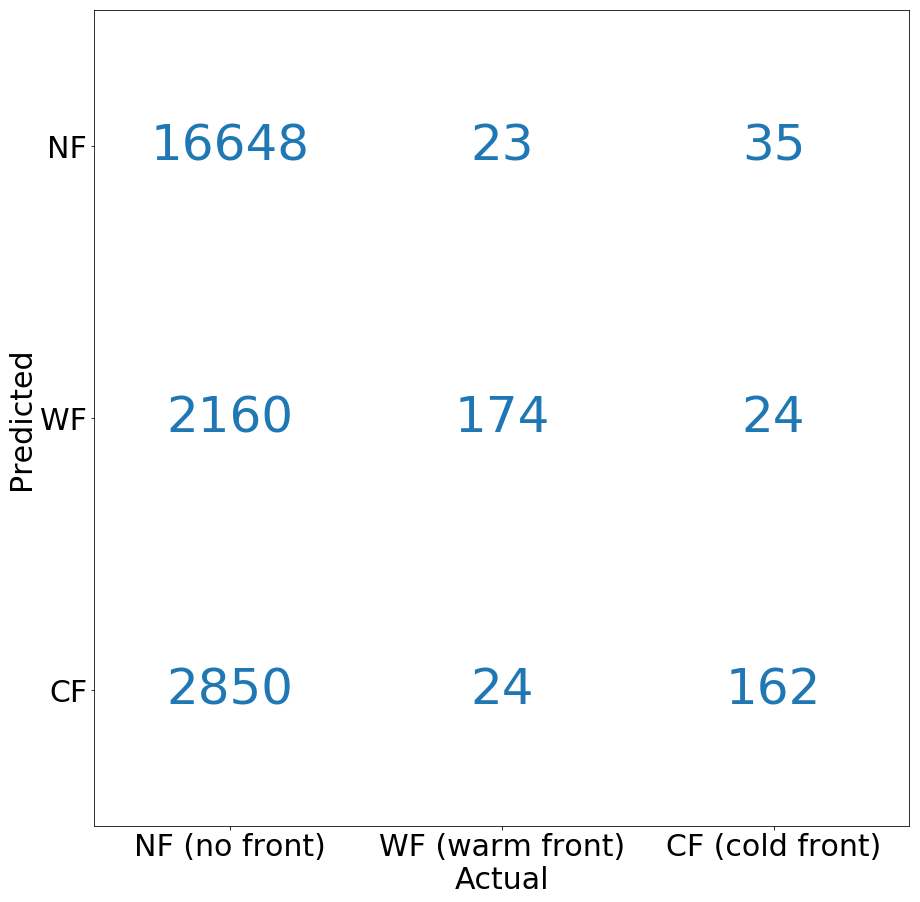

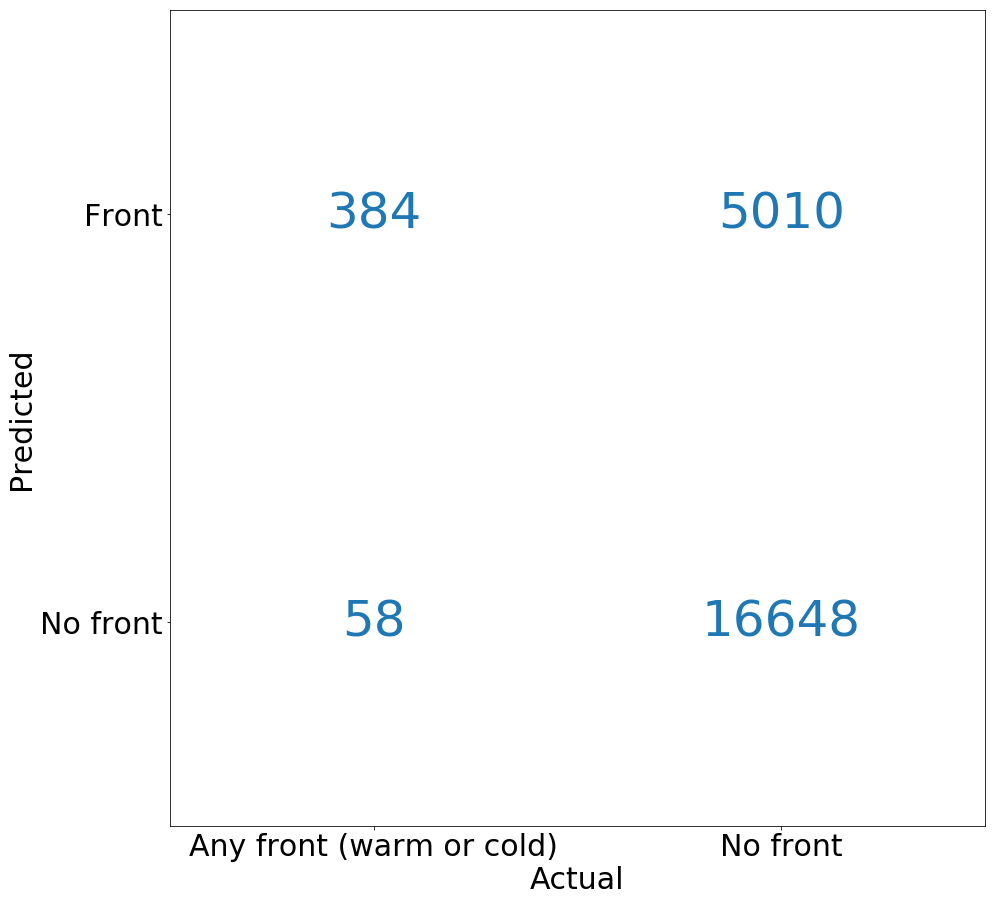

In [52]:
contingency_matrix = eval_utils.get_contingency_table(
    predicted_labels=predicted_labels, observed_labels=target_values,
    num_classes=3)

binary_ct_as_dict = binary_eval.get_contingency_table(
    forecast_labels=(predicted_labels > 0).astype(int),
    observed_labels=(target_values > 0).astype(int))

a = binary_ct_as_dict[binary_eval.NUM_TRUE_POSITIVES_KEY]
b = binary_ct_as_dict[binary_eval.NUM_FALSE_POSITIVES_KEY]
c = binary_ct_as_dict[binary_eval.NUM_FALSE_NEGATIVES_KEY]
d = binary_ct_as_dict[binary_eval.NUM_TRUE_NEGATIVES_KEY]
binary_contingency_matrix = numpy.array([[a, b], [c, d]])

plot_3class_contingency_table(contingency_matrix=contingency_matrix)
plot_2class_contingency_table(contingency_matrix=binary_contingency_matrix)

# ROC Curves

The following method plots a ROC (receiver operating characteristic) curve for the binary problem ("front or no front").

Note that there are two other ways to binarize the problem: "warm front or not" and "cold front or not".  In general, for a $K$-class problem, there are $K$ ways to binarize the problem, using the "one vs. all" approach for each class.  Binarization allows you to plot standard graphics like the ROC curve, performance diagram, and reliability curve, which are difficult to plot for more than two classes at once.

In [53]:
def plot_binary_roc_curve(
        class_probability_matrix, target_values, axes_object=None):
    """Plots binary ("front or no front") ROC curve.
    
    :param class_probability_matrix: See doc for `make_predictions`.
    :param target_values: Same.
    :param axes_object: See doc for `plot_feature_map`.
    :return: auc: Area under ROC curve.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    front_probabilities = (
        numpy.sum(class_probability_matrix, axis=1) -
        numpy.sum(class_probability_matrix[:, [NO_FRONT_ENUM]], axis=1)
    )

    pofd_by_threshold, pod_by_threshold = binary_eval.get_points_in_roc_curve(
        forecast_probabilities=front_probabilities,
        observed_labels=(target_values > 0).astype(int), threshold_arg=1001)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    random_x_coords, random_y_coords = binary_eval.get_random_roc_curve()
    random_line_colour = numpy.full(3, 152. / 255)
    actual_line_colour = numpy.array([228, 26, 28], dtype=float) / 255

    axes_object.plot(
        random_x_coords, random_y_coords, color=random_line_colour,
        linestyle='dashed', linewidth=2)

    nan_flags = numpy.logical_or(
        numpy.isnan(pofd_by_threshold), numpy.isnan(pod_by_threshold)
    )
    plot_indices = numpy.where(numpy.invert(nan_flags))[0]
    axes_object.plot(
        pofd_by_threshold[plot_indices], pod_by_threshold[plot_indices],
        color=actual_line_colour, linestyle='solid', linewidth=4)

    axes_object.set_xlabel('POFD (probability of false detection)')
    axes_object.set_ylabel('POD (probability of detection)')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    auc = binary_eval.get_area_under_roc_curve(
        pofd_by_threshold=pofd_by_threshold, pod_by_threshold=pod_by_threshold)
    title_string = 'Area under ROC curve = {0:.4f}'.format(auc)
    axes_object.set_title(title_string)

    return auc, axes_object

## ROC Curve for Feb 2017

The next cell calls `plot_binary_roc_curve` for Feb 2017 (part of the testing period).

(0.9019388820617005, <matplotlib.axes._subplots.AxesSubplot at 0x7f1468dcf850>)

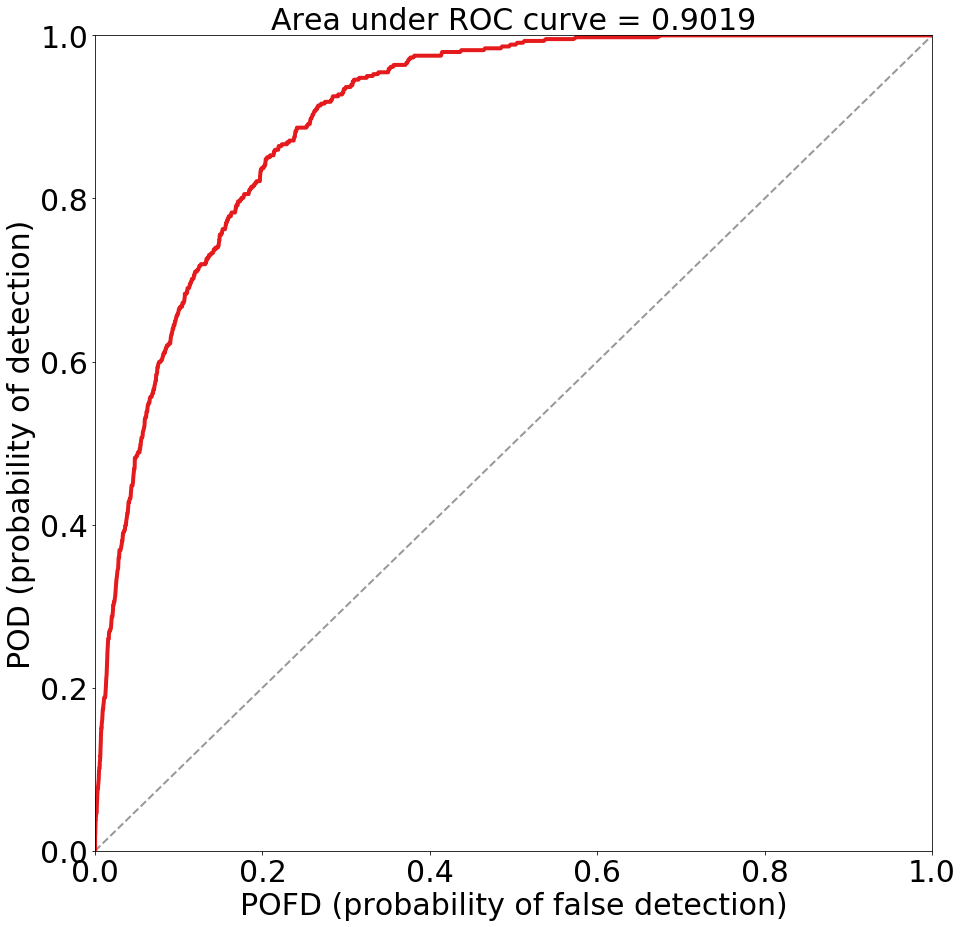

In [54]:
plot_binary_roc_curve(class_probability_matrix=class_probability_matrix,
                      target_values=target_values)

# Performance Diagram

The following method plots a performance diagram (Roebber 2009) for the binary problem ("front or no front").

Roebber, P., 2009: "Visualizing multiple measures of forecast quality." *Weather and Forecasting*, **24 (2)**, 601-608. [[link]](https://journals.ametsoc.org/doi/abs/10.1175/2008WAF2222159.1)

In [55]:
def _get_csi_colour_scheme():
    """Returns colour scheme for CSI (critical success index).

    :return: colour_map_object: Colour scheme (instance of
        `matplotlib.colors.ListedColormap`).
    :return: colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.
    """

    this_colour_map_object = pyplot.cm.Blues
    this_colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_CSI_CONTOURS, this_colour_map_object.N)

    rgba_matrix = this_colour_map_object(this_colour_norm_object(
        LEVELS_FOR_CSI_CONTOURS))
    colour_list = [
        rgba_matrix[i, ..., :-1] for i in range(rgba_matrix.shape[0])
    ]

    colour_map_object = matplotlib.colors.ListedColormap(colour_list)
    colour_map_object.set_under(numpy.array([1, 1, 1]))
    colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_CSI_CONTOURS, colour_map_object.N)

    return colour_map_object, colour_norm_object


def plot_binary_perf_diagram(
        class_probability_matrix, target_values, axes_object=None):
    """Plots binary ("front or no front") performance diagram.

    :param class_probability_matrix: See doc for `make_predictions`.
    :param target_values: Same.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    front_probabilities = (
        numpy.sum(class_probability_matrix, axis=1) -
        numpy.sum(class_probability_matrix[:, [NO_FRONT_ENUM]], axis=1)
    )

    (success_ratio_by_threshold, pod_by_threshold
    ) = binary_eval.get_points_in_performance_diagram(
        forecast_probabilities=front_probabilities,
        observed_labels=(target_values > 0).astype(int), threshold_arg=1001)

    csi_by_threshold = binary_eval.csi_from_sr_and_pod(
        success_ratio_by_threshold, pod_by_threshold)
    max_csi = numpy.nanmax(csi_by_threshold)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    # Compute CSI and frequency-bias grids for background contours.
    success_ratio_matrix, pod_matrix = binary_eval.get_sr_pod_grid()
    csi_matrix = binary_eval.csi_from_sr_and_pod(
        success_ratio_matrix, pod_matrix)
    frequency_bias_matrix = binary_eval.frequency_bias_from_sr_and_pod(
        success_ratio_matrix, pod_matrix)

    # Plot CSI contours.
    colour_map_object, colour_norm_object = _get_csi_colour_scheme()
    pyplot.contourf(
        success_ratio_matrix, pod_matrix, csi_matrix, LEVELS_FOR_CSI_CONTOURS,
        cmap=colour_map_object, norm=colour_norm_object, vmin=0.,
        vmax=1., axes=axes_object)

    colour_bar_object = _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=csi_matrix, min_colour_value=0.,
        max_colour_value=1., colour_norm_object=colour_norm_object,
        orientation_string='vertical', extend_min=False, extend_max=False)
    colour_bar_object.set_label('CSI (critical success index)')

    # Plot frequency-bias contours.
    bias_colour = numpy.full(3, 152. / 255)
    bias_colour_tuple = ()
    for _ in range(len(LEVELS_FOR_BIAS_CONTOURS)):
        bias_colour_tuple += (bias_colour,)

    bias_contour_object = pyplot.contour(
        success_ratio_matrix, pod_matrix, frequency_bias_matrix,
        LEVELS_FOR_BIAS_CONTOURS, colors=bias_colour_tuple,
        linewidths=2, linestyles='dashed', axes=axes_object)
    pyplot.clabel(
        bias_contour_object, inline=True, inline_spacing=10, fmt='%.2f',
        fontsize=FONT_SIZE)

    # Plot the actual curve.
    nan_flags = numpy.logical_or(
        numpy.isnan(success_ratio_by_threshold), numpy.isnan(pod_by_threshold)
    )
    plot_indices = numpy.where(numpy.invert(nan_flags))[0]

    actual_line_colour = numpy.array([228, 26, 28], dtype=float) / 255
    axes_object.plot(
        success_ratio_by_threshold[plot_indices],
        pod_by_threshold[plot_indices],
        color=actual_line_colour, linestyle='solid', linewidth=4)

    axes_object.set_xlabel('Success ratio (1 - FAR)')
    axes_object.set_ylabel('POD (probability of detection)')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    title_string = 'Max CSI = {0:.4f}'.format(max_csi)
    axes_object.set_title(title_string)
    
    return axes_object

## Performance Diagram for Feb 2017

The next cell calls `plot_binary_perf_diagram` for Feb 2017 (part of the testing period).

While the ROC curve looks excellent, the performance diagram doesn't look very good.  This is because for rare events (fronts occur in only 1.05% of all examples) it is much easier to minimize POFD (the $x$-axis of the ROC curve) than maximize success ratio (the $x$-axis of the performance diagram).  POFD = $\frac{b}{b + d}$, where $b$ is the number of false positives and $b + d$ is the number of non-front examples.  The number of non-front examples is huge (98.95% of the dataset), so the denominator is huge, so it is easy to obtain a low POFD even with a poor model.  Success ratio = $\frac{a}{a + b}$, where $a$ is the number of true positives and $b$ is the number of false positives.  For rare events many positive predictions end up being wrong, simply because the event is rare, so it is difficult to have a large $a$ without having a large $b$, which makes it difficult to obtain a high success ratio.

Again, this problem is mitigated by an object-conversion procedure discussed in the journal paper.

The dashed grey lines in the background are frequency bias.  The blue colour fill is CSI.

/home/ubuntu/anaconda3/envs/tensorflow_p27_tutorial/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:543: RuntimeWarning: invalid value encountered in less
  if numpy.any(input_variable < base_value):
/home/ubuntu/anaconda3/envs/tensorflow_p27_tutorial/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:591: RuntimeWarning: invalid value encountered in greater
  if numpy.any(input_variable > base_value):
/home/ubuntu/anaconda3/envs/tensorflow_p27_tutorial/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/model_evaluation.py:1103: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ubuntu/anaconda3/envs/tensorflow_p27_tutorial/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


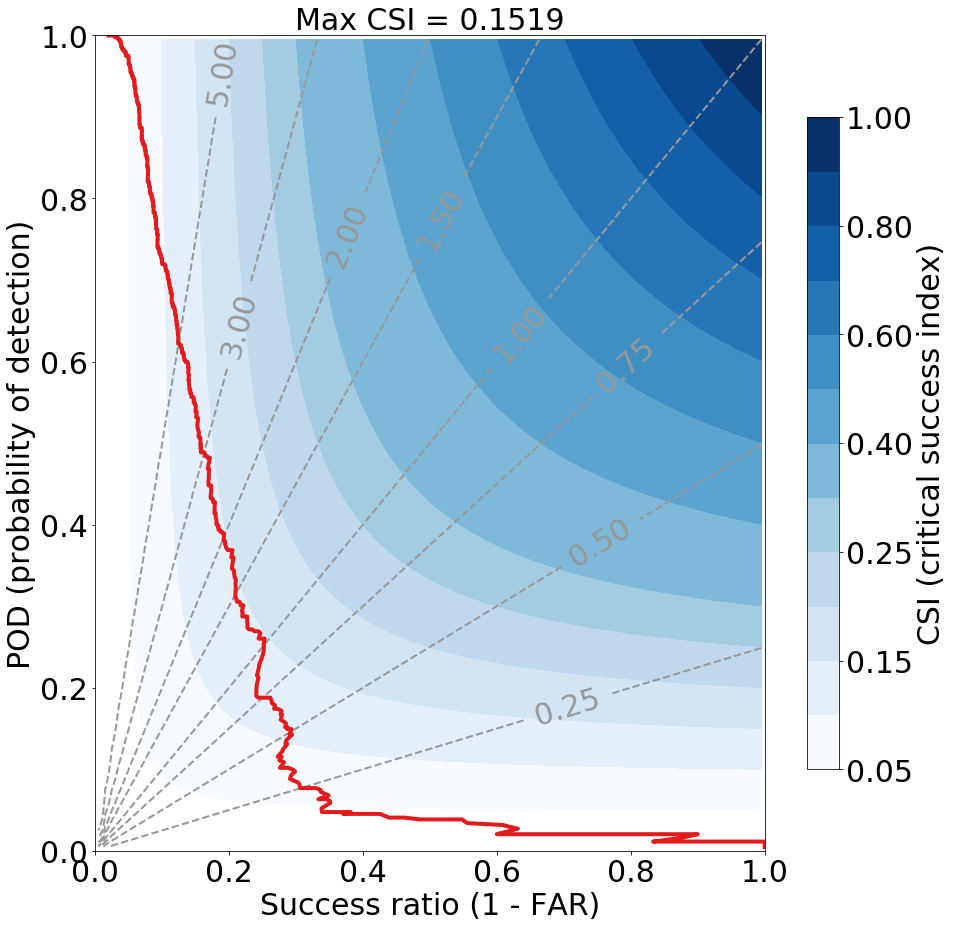

In [56]:
plot_binary_perf_diagram(class_probability_matrix=class_probability_matrix,
                         target_values=target_values)

# Reliability Curve

The following method plots a reliability curve (Hsu and Murphy 1986) for the binary problem ("front or no front").  Reliability curves are a good complement to ROC curves and performance diagrams, because the latter plot deterministic predictions while reliability curves plot probabilistic predictions.

Hsu, W., and A. Murphy, 1986: "The attributes diagram: A geometrical framework for assessing the quality of probability forecasts." *International Journal of Forecasting*, **2 (3)**, 285-293.  [[link]](https://www.sciencedirect.com/science/article/pii/0169207086900488)

In [57]:
def plot_binary_relia_curve(
        class_probability_matrix, target_values, axes_object=None):
    """Plots binary ("front or no front") reliability curve.

    :param class_probability_matrix: See doc for `make_predictions`.
    :param target_values: Same.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    front_probabilities = (
        numpy.sum(class_probability_matrix, axis=1) -
        numpy.sum(class_probability_matrix[:, [NO_FRONT_ENUM]], axis=1)
    )

    (mean_front_prob_by_bin, front_frequency_by_bin, _
    ) = binary_eval.get_points_in_reliability_curve(
        forecast_probabilities=front_probabilities,
        observed_labels=(target_values > 0).astype(int),
        num_forecast_bins=20)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    (perfect_x_coords, perfect_y_coords
     ) = binary_eval.get_perfect_reliability_curve()
    perfect_line_colour = numpy.full(3, 152. / 255)
    actual_line_colour = numpy.array([228, 26, 28], dtype=float) / 255

    axes_object.plot(
        perfect_x_coords, perfect_y_coords, color=perfect_line_colour,
        linestyle='dashed', linewidth=2)

    nan_flags = numpy.logical_or(
        numpy.isnan(mean_front_prob_by_bin), numpy.isnan(front_frequency_by_bin)
    )
    plot_indices = numpy.where(numpy.invert(nan_flags))[0]
    axes_object.plot(
        mean_front_prob_by_bin[plot_indices],
        front_frequency_by_bin[plot_indices],
        color=actual_line_colour, linestyle='solid', linewidth=4)

    axes_object.set_xlabel('Predicted front probability')
    axes_object.set_ylabel('Conditional front frequency')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    return axes_object

## Reliability Curve for Feb 2017

The next cell calls `plot_binary_relia_curve` for Feb 2017 (part of the testing period).

 - The reliability curve shows predicted front probability vs. conditional front frequency.
 - In other words, it answers the question: "Given a predicted probability of $p$, how likely is there to be an actual front?"
 - The dashed grey line is a perfect reliability curve.
 - Points below the dashed grey line mean that the model is "overconfident" (it predicts fronts more often than they actually occur).
 - Points above the dashed grey line mean that the model is "underconfident" (predicts fronts less often than they actually occur).

The poor reliability curve is caused by the same overprediction problem discussed above, which is mitigated by an object-conversion procedure discussed in the journal paper.

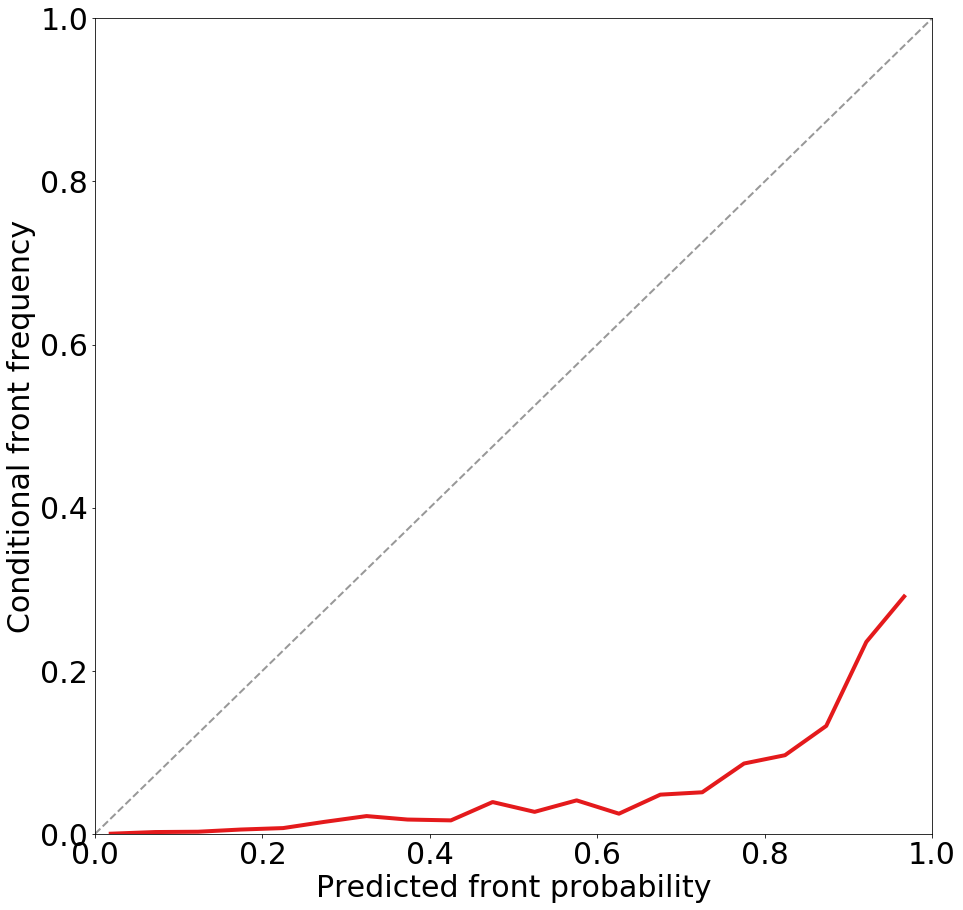

In [58]:
plot_binary_relia_curve(class_probability_matrix=class_probability_matrix,
                        target_values=target_values)

# Model Interpretation

There are many ways of interpreting a machine-learning model.  We discuss only two in this notebook (the permutation variable-importance test and saliency maps).

 - Permutation variable-importance test (Lakshmanan *et al.* 2015)
 - Saliency maps (Simonyan *et al.* 2014)
 - Feature optimization or "backwards optimization" (Olah *et al.* 2017, Gagne II *et al.* 2018[a, b])
 - Novelty detection (Wagstaff and Lee 2018)

Gagne II, D., 2018: "Hail forecasting with interpretable deep learning." *Conference on Weather Analysis and Forecasting*, Denver, Colorado, American Meteorological Society. [[link]](https://ams.confex.com/ams/29WAF25NWP/webprogram/Paper345629.html)

Gagne II, D., S. Haupt, and D. Nychka, 2018: "Interpretable deep learning for spatial severe hail forecasting." *Monthly Weather Review*, **submitted**, 2018.

Lakshmanan, V., C. Karstens, J. Krause, K. Elmore, A. Ryzhkov, and S. Berkseth, 2015: "Which polarimetric variables are important for weather/no-weather discrimination?" *Journal of Atmospheric and Oceanic Technology*, **32 (6)**, 1209-1223. [[link]](https://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00205.1)

Olah, C., A. Mordvintsev, and L. Schubert, 2017: "Feature visualization." *Distill*. [[link]](https://distill.pub/2017/feature-visualization/)

Simonyan, K., A. Vevaldi, and A. Zisserman, 2014: "Deep inside convolutional networks: Visualizing image classification models and saliency maps." *arXiv e-prints*, **1312 (6034v2)**. [[link]](https://arxiv.org/abs/1312.6034)

Wagstaff, K., and J. Lee, 2018: "Interpretable discovery in large image data sets." *arXiv e-prints*, **1806 (08340)**. [[link]](https://arxiv.org/abs/1806.08340)

## Permutation Test

Step 1 of the permutation test (where only one variable at a time is permuted) is carried out in `make_predictions` (method defined above).  The next cell plots the ROC curve obtained by permuting each of the four predictor variables: $u$-wind, $v$-wind, temperature, and specific humidity.  Keep in mind that the AUC (area under ROC curve) for the unpermuted data is 0.9019.  The **most important** variable, according to the permutation test, is that whose **permutation decreases AUC the most**.  If permuting a variable $x_j$ has no effect on performance, this means that either (a) it is irrelevant or (b) the information contained in $x_j$ is also contained in the other variables.

Keep in mind that the permutation test can use any performance metric -- there is nothing special about AUC.  Feel free to plot performance diagrams, plot reliability curves, or compute any other performance metric for the four channels of `permuted_probability_matrix`.  You might find something interesting.  Which aspects of performance suffer more/less from permuting an input variable?

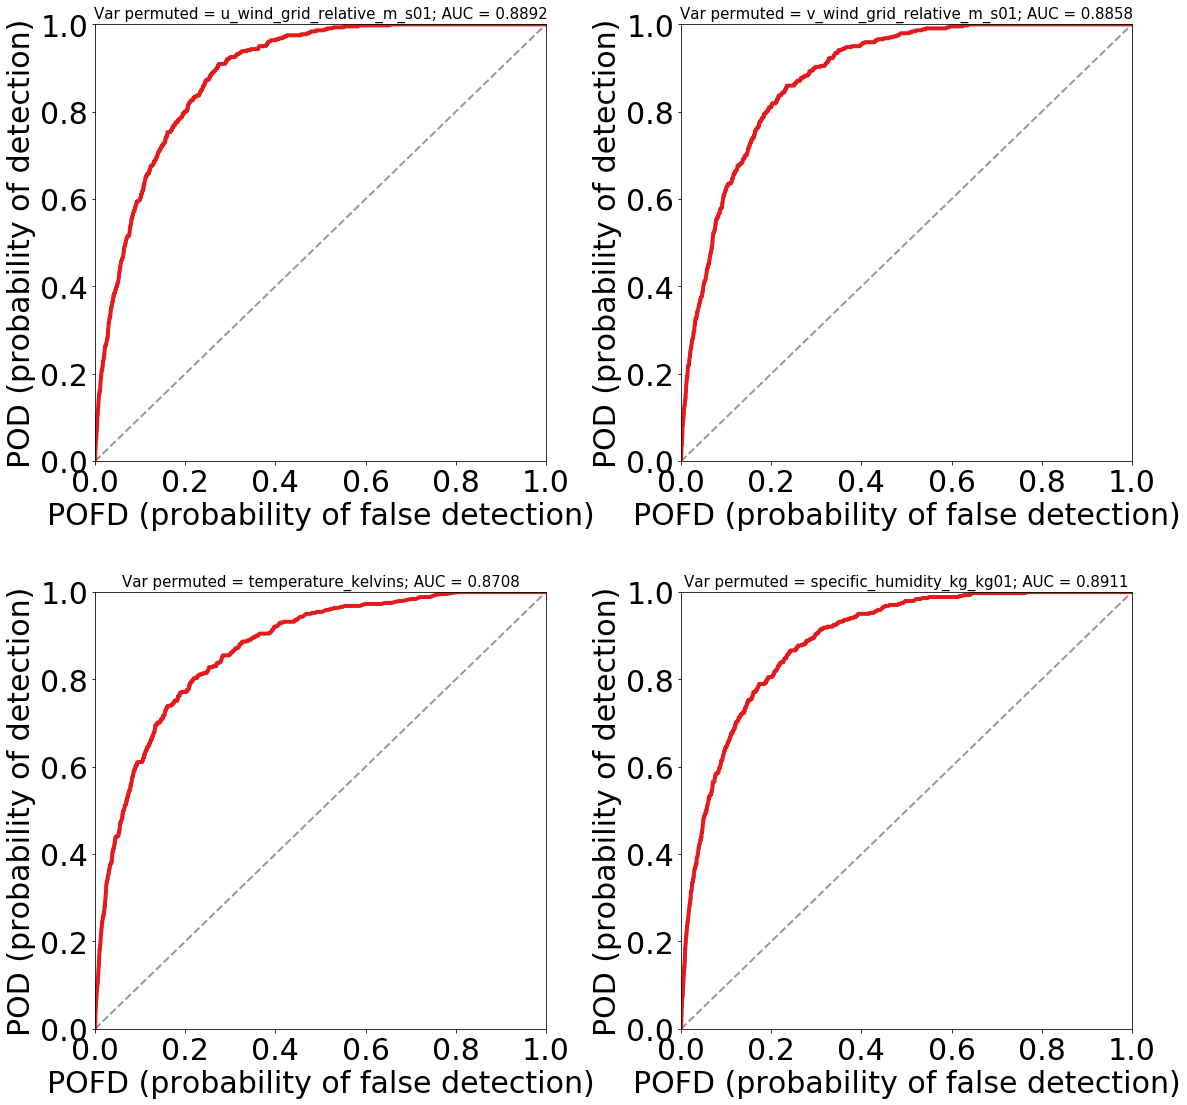

In [59]:
num_predictors = len(predictor_names_to_keep)
num_panel_rows = 2
num_panel_columns = int(numpy.ceil(float(num_predictors) / num_panel_rows))

_, axes_objects_2d_list = _init_figure_panels(
    num_rows=num_panel_rows, num_columns=num_panel_columns,
    horizontal_space_fraction=0.3, vertical_space_fraction=0.3)

for m in range(num_predictors):
    this_panel_row, this_panel_column = numpy.unravel_index(
        m, (num_panel_rows, num_panel_columns))

    this_auc, _ = plot_binary_roc_curve(
        class_probability_matrix=permuted_probability_matrix[..., m],
        target_values=target_values,
        axes_object=axes_objects_2d_list[this_panel_row][this_panel_column]
    )

    this_title_string = 'Var permuted = {0:s}; AUC = {1:.4f}'.format(
        predictor_names_to_keep[m], this_auc)
    axes_objects_2d_list[this_panel_row][this_panel_column].set_title(
        this_title_string, fontsize=15)

## Saliency Maps

The following method computes a saliency map for one example, according to one CNN.  The saliency map has the same dimensions as the predictor matrix: $M \times N \times C$, where $M$ = number of rows in the grid; $N$ = number of columns; and $C$ = number of channels (predictor variables).  The "saliency" of an input value $x$ is the gradient of the CNN's prediction (probability of class $k$, where $k$ is the input argument `target_class`) with respect to $x$, or $\frac{\partial p_k}{\partial x}$.  Thus, `saliency_matrix[i, j, m]` is the gradient of $p_k$ with respect to variable $m$ at grid cell $(i, j)$.  Inputs with greater absolute saliency values are assumed to be more important for predicting class $k$.

`get_saliency_maps` is also adapted from the [Swirlnet tutorial](https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb).

In [60]:
def get_saliency_maps(model_object, target_class, predictor_matrix):
    """Computes saliency map for each example in `predictor_matrix`.

    :param model_object: Trained CNN (instance of `keras.models`).  Saliency
        will be computed for this CNN only.  Different models give different
        answers.
    :param target_class: Target class (integer).  Possible values are
        `NO_FRONT_ENUM`, `WARM_FRONT_ENUM`, and `WARM_FRONT_ENUM`, listed at the
        top of this notebook.
    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: saliency_matrix: E-by-M-by-N-by-C numpy array of saliency values.
    """

    loss_tensor = K.mean(
        (model_object.layers[-1].output[..., target_class] - 1) ** 2)

    gradient_tensor = K.gradients(loss_tensor, [model_object.input])[0]
    gradient_tensor = gradient_tensor / K.maximum(
        K.std(gradient_tensor), K.epsilon()
    )

    inputs_to_gradients_function = K.function(
        [model_object.input, K.learning_phase()], [gradient_tensor])

    saliency_matrix = inputs_to_gradients_function([predictor_matrix, 0])[0]
    return -1 * saliency_matrix

## Plotting Saliency Maps

The following method plots the saliency map for one example, according to one CNN.

In [61]:
def plot_saliency_one_example(
        predictor_matrix, saliency_matrix, predictor_names):
    """Plots saliency maps for one example.
    
    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param saliency_matrix: M-by-N-by-C numpy array of saliency values.
    :param predictor_names: length-C list of predictor variables.
    """

    max_saliency = numpy.percentile(numpy.absolute(saliency_matrix), 99.)
    min_saliency = -1 * max_saliency
    saliency_contour_levels = numpy.linspace(
        min_saliency, max_saliency, num=21, dtype=float)

    num_predictors = len(predictor_names)
    num_panel_rows = 2
    num_panel_columns = int(numpy.ceil(float(num_predictors) / num_panel_rows))

    _, axes_objects_2d_list = _init_figure_panels(
        num_rows=num_panel_rows, num_columns=num_panel_columns,
        horizontal_space_fraction=0.15, vertical_space_fraction=0.15)

    for m in range(num_predictors):
        this_panel_row, this_panel_column = numpy.unravel_index(
            m, (num_panel_rows, num_panel_columns))
        plot_feature_map(
            feature_matrix=predictor_matrix[..., m],
            axes_object=axes_objects_2d_list[this_panel_row][this_panel_column],
            colour_map_object=pyplot.cm.Oranges)

        axes_objects_2d_list[this_panel_row][this_panel_column].contour(
            saliency_matrix[..., m], saliency_contour_levels,
            cmap=pyplot.cm.PRGn, vmin=min_saliency, vmax=max_saliency,
            linewidths=4, linestyles='solid')

        this_title_string = 'Saliency for {0:s}'.format(predictor_names[m])
        axes_objects_2d_list[this_panel_row][this_panel_column].set_title(
            this_title_string, fontsize=20)

## Example 1: WF saliency map for NF example

The following cell plots a WF saliency map for an NF example (the true label is NF).  Thus, the value at each pixel is the gradient of WF probability with respect to the underlying value.

 - Large **positive** gradients mean that, if the underlying value were **increased**, the predicted WF probability would increase.
 - Large **negative** gradients mean that, if the underlying value were **decreased**, the predicted WF probability would increase.
 - Near-zero gradients mean that the underlying value has little effect on the predicted WF probability.
 - **Purple (green) contours indicate negative (positive) saliency values.**

In the following example, the saliency map for temperature is the most interesting.  It indicates that if temperature were decreased along the north edge of the grid (where it is already relatively quite cold) and increased just southeast of that (where it is relatively quite warm), the model would be more likely to classify the example as a warm front.  This would definitely make the example look more like a front in general, by juxtaposing much colder air next to much warmer air.

Reading data from: "/home2/lagerqui/input_examples/testing/downsized_3d_examples_2017020100-2017020121.nc"...


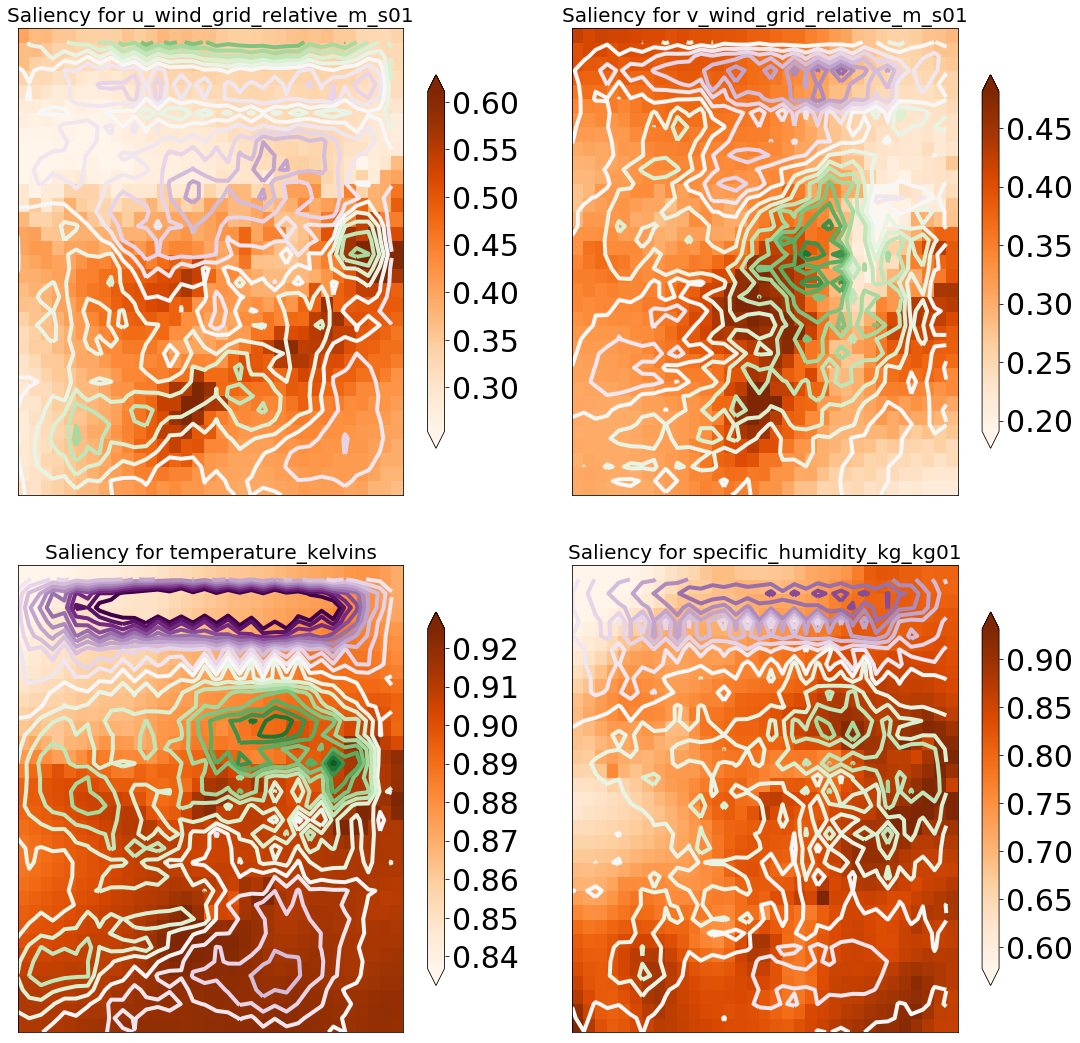

In [62]:
input_dimensions = numpy.array(
    best_model_object.layers[0].input.get_shape().as_list()[1:], dtype=int)

num_grid_rows = input_dimensions[0]
num_half_rows = (num_grid_rows - 1) / 2
num_grid_columns = input_dimensions[1]
num_half_columns = (num_grid_columns - 1) / 2

print 'Reading data from: "{0:s}"...'.format(testing_file_names[0])
example_dict = read_input_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=predictor_names_to_keep,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

no_front_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, NO_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][no_front_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object, target_class=WARM_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)

## Example 2: CF saliency map for NF example

The following cell plots the CF saliency map for the same NF example.  Again, **purple (green) contours indicate negative (positive) saliency values.**

The CF saliency map is similar to the WF saliency map, but moreso for the temperature and specific-humidity fields than for the wind fields.  This makes sense, as the wind direction determines whether a front is warm (warm air replacing cold air) or cold (vice-versa).

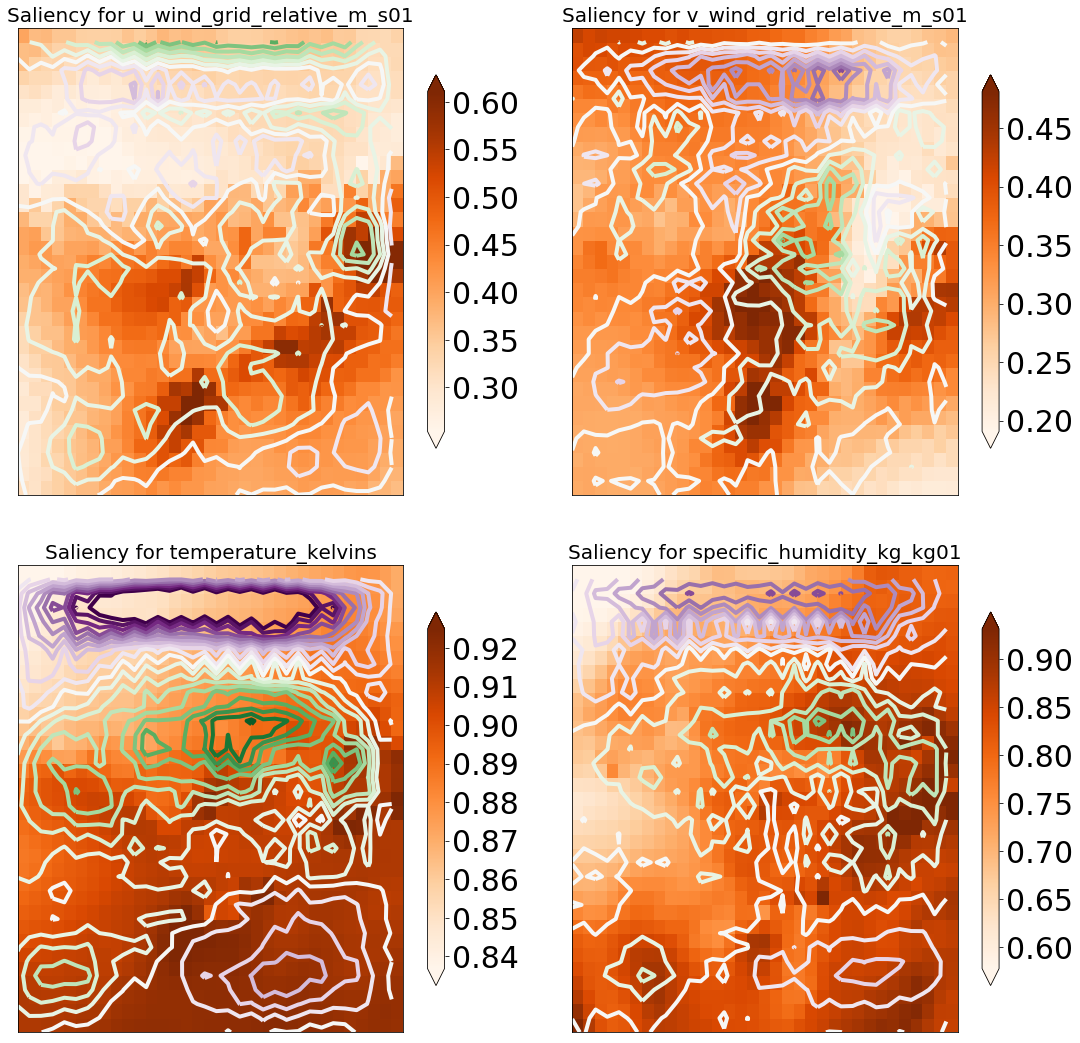

In [63]:
saliency_matrix = get_saliency_maps(
    model_object=best_model_object,
    target_class=COLD_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)

## Example 3: CF saliency map for CF example

The following cell plots the CF saliency map for a CF example.  Again, **purple (green) contours indicate negative (positive) saliency values.**

Keep in mind that $u$-wind is the eastward component (towards the right of the grid) and $v$ is the northward component (towards the top of the grid).  Thus, the saliency maps for $u$ and $v$ indicate that if flow from the northwest of the grid increased towards the southeast, the model would be more likely to classify the example as a cold front.  This makes sense, because the northwest corner of the grid contains relatively very cold air.  Strong southeastward flow from this area would push the very cold air to adjacent areas, replacing warm air, which is what a cold front does.

The saliency map for temperature indicates that, if temperature decreased even more in the northwest corner of the grid and increased just to the southeast of this cold pocket, the model would be more likely to classify the example as a cold front.  This result also makes sense, because it would juxtapose even colder air with even warmer air, thus strengthening the front.  The saliency map for specific humidity (kg of water vapour per kg of air) is similar, which makes sense because colder air tends to be drier.

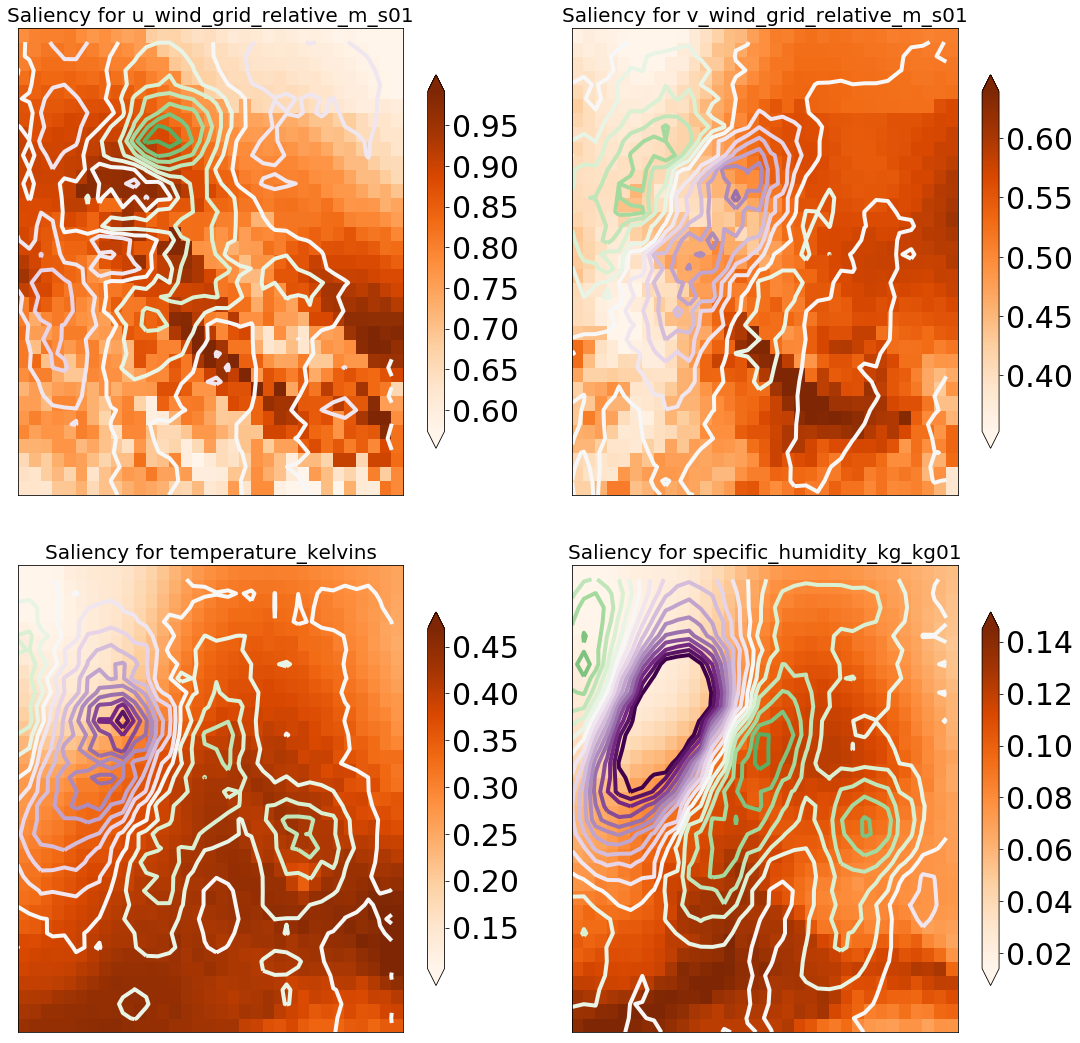

In [64]:
cold_front_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, COLD_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][cold_front_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object,
    target_class=COLD_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)

## Example 4: WF saliency map for CF example

The following cell plots the WF saliency map for the same CF example.  Again, **purple (green) contours indicate negative (positive) saliency values.**

Do you see anything interesting?  Compare these maps to the ones above.

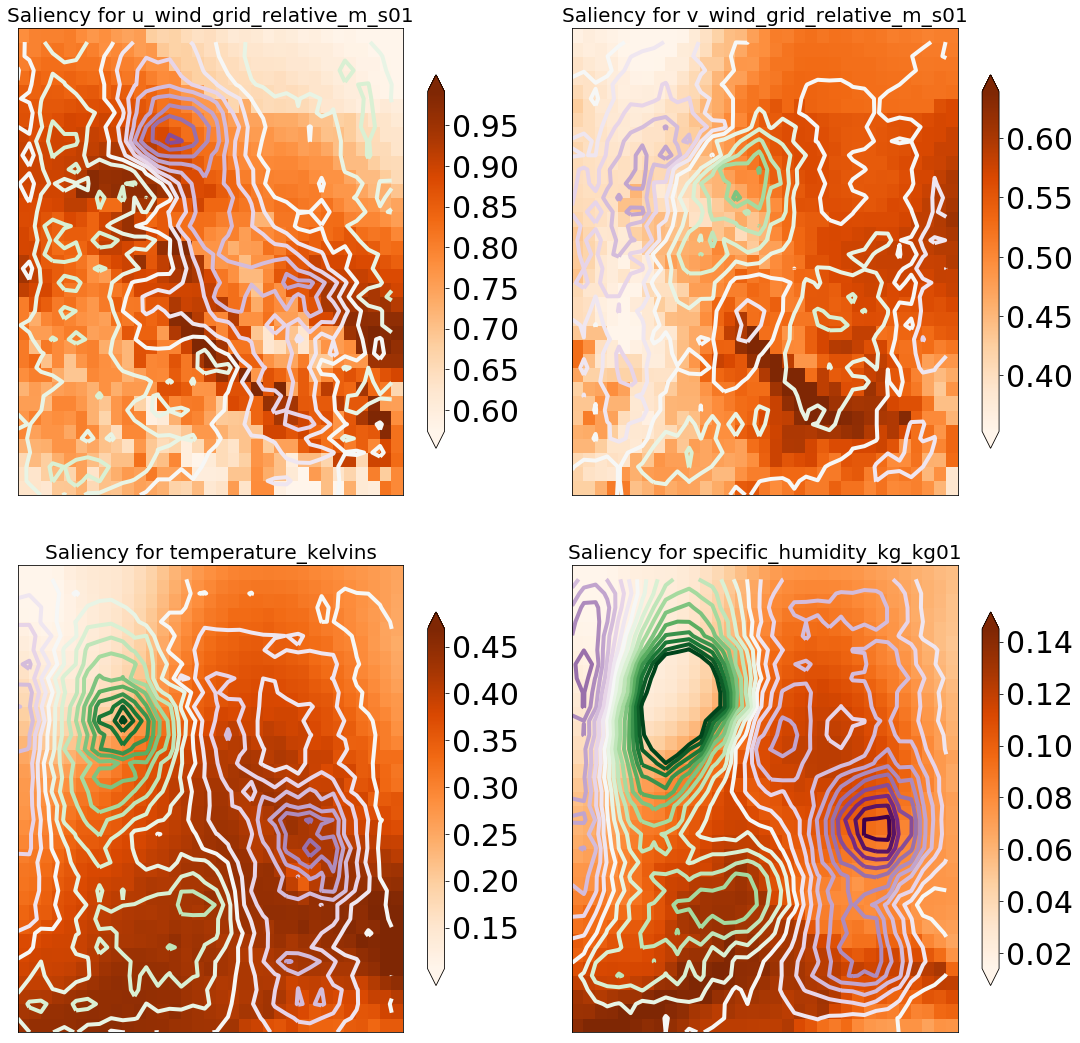

In [65]:
saliency_matrix = get_saliency_maps(
    model_object=best_model_object,
    target_class=WARM_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)